In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl


In [2]:
!pip install imread
!pip install tensorflow
!pip install tensorflow_hub
!pip install --upgrade pip

     |████████████████████████████████| 1.6 MB 2.0 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 1.5 MB 3.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 20.2.4
    Uninstalling pip-20.2.4:
      Successfully uninstalled pip-20.2.4


In [3]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scattertext as st
import plotly.graph_objects as go
from plotly.offline import plot
from imread import imread, imsave
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from IPython.display import IFrame
import os, pkgutil, json, urllib
from urllib.request import urlopen
from IPython.core.display import display, HTML
from scattertext import CorpusFromPandas, produce_scattertext_explorer
from IPython.display import IFrame
from sklearn.svm import LinearSVC

import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import tokenization

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
display(HTML("<style>.container { width:98% !important; }</style>"))

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

#### Reading the data

In [5]:
disaster_tweets_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv",  dtype={'id': np.int16, 'target': np.int8})
disaster_tweets_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv",dtype={'id': np.int16})

#### Data description

In [6]:
disaster_tweets_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
disaster_tweets_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int16 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int8  
dtypes: int16(1), int8(1), object(3)
memory usage: 200.9+ KB


### Data Cleaning
##### looking for missing values in the dataset

In [8]:
disaster_tweets_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
missing_cols = ['keyword', 'location']
for df in [disaster_tweets_train, disaster_tweets_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

In [10]:
# word_count
disaster_tweets_train['word_count'] = disaster_tweets_train['text'].apply(lambda x: len(str(x).split()))
disaster_tweets_test['word_count'] = disaster_tweets_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
disaster_tweets_train['unique_word_count'] = disaster_tweets_train['text'].apply(lambda x: len(set(str(x).split())))
disaster_tweets_test['unique_word_count'] = disaster_tweets_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
disaster_tweets_train['stop_word_count'] = disaster_tweets_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
disaster_tweets_test['stop_word_count'] = disaster_tweets_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
disaster_tweets_train['url_count'] = disaster_tweets_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
disaster_tweets_test['url_count'] = disaster_tweets_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
disaster_tweets_train['mean_word_length'] = disaster_tweets_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
disaster_tweets_test['mean_word_length'] = disaster_tweets_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
disaster_tweets_train['char_count'] = disaster_tweets_train['text'].apply(lambda x: len(str(x)))
disaster_tweets_test['char_count'] = disaster_tweets_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
disaster_tweets_train['punctuation_count'] = disaster_tweets_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
disaster_tweets_test['punctuation_count'] = disaster_tweets_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
disaster_tweets_train['hashtag_count'] = disaster_tweets_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
disaster_tweets_test['hashtag_count'] = disaster_tweets_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
disaster_tweets_train['mention_count'] = disaster_tweets_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
disaster_tweets_test['mention_count'] = disaster_tweets_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

From the above we can see that we have lot of missing values in location and the column key word also has few missing values

## Plots for understanding or analysis
#### Target Variable Distribution


Text(0, 0.5, 'samples')

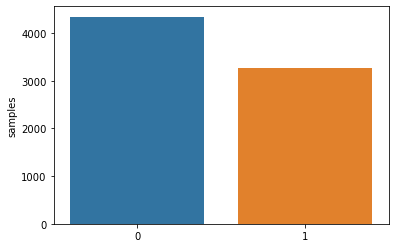

In [11]:
x=disaster_tweets_train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

From the above graph we can say that the data is almost balanced

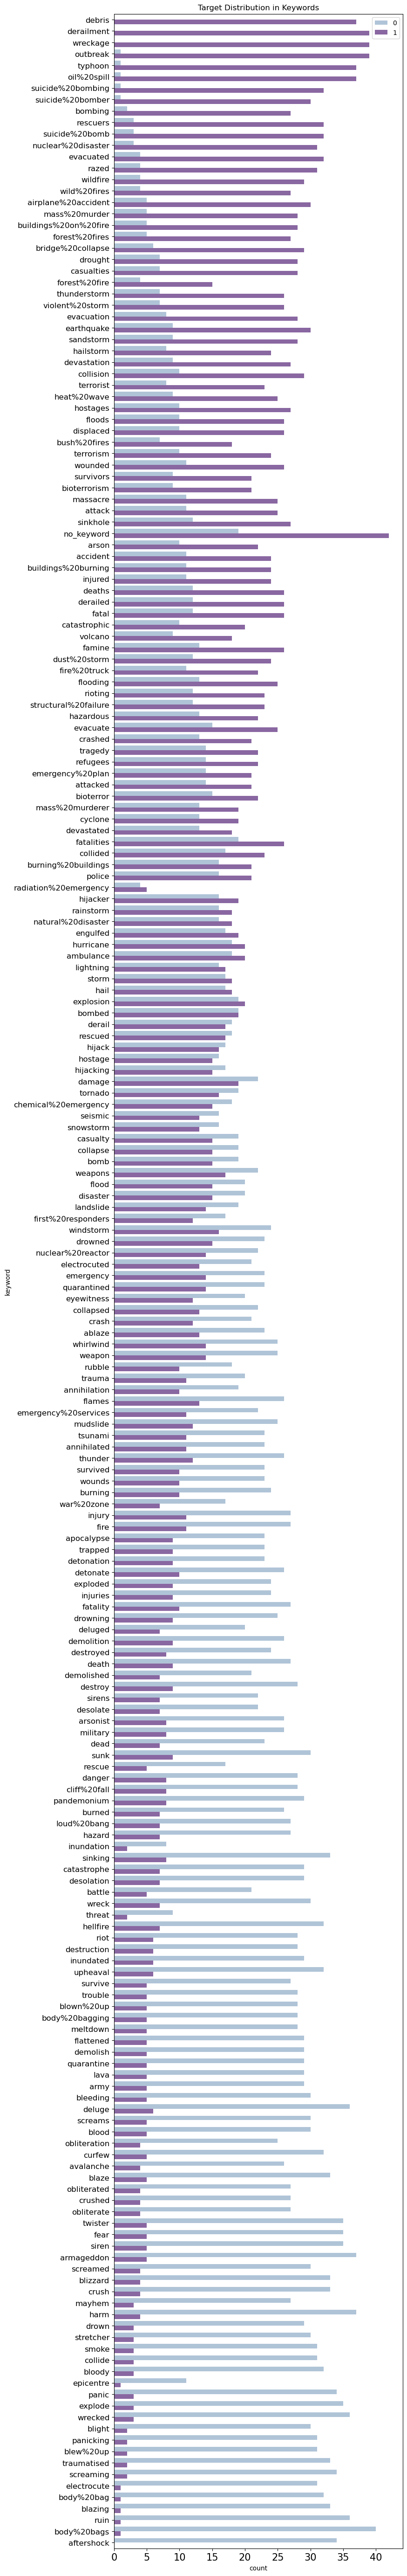

In [12]:
disaster_tweets_train['target_mean'] = disaster_tweets_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=disaster_tweets_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=disaster_tweets_train.sort_values(by='target_mean', ascending=False)['target'], palette = "BuPu")

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

disaster_tweets_train.drop(columns=['target_mean'], inplace=True)

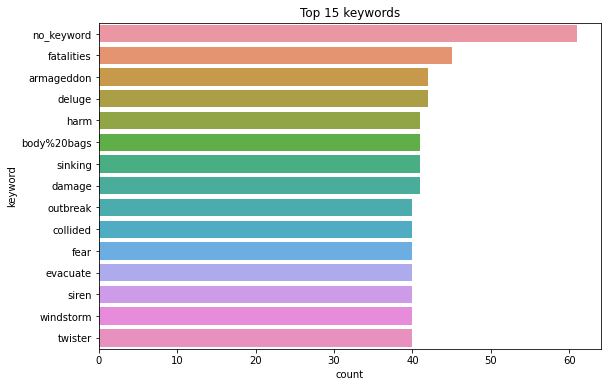

In [13]:
plt.figure(figsize=(9,6))
sns.countplot(y=disaster_tweets_train.keyword, order = disaster_tweets_train.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()

In [14]:
all_words = disaster_tweets_train['text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

fig.show()

#### WordClouds

In [15]:
words = disaster_tweets_train["text"].values

In [16]:
fire_64 = b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAMCAggICAgICAoICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAoICAgICgoKCAgLDQoIDQgICggBAwQEBgUGCgYGCg0NCg0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDf/AABEIAgABgQMBEQACEQEDEQH/xAAdAAABBAMBAQAAAAAAAAAAAAAGAgMEBQABBwgJ/8QAUBAAAgECAwYCBwQGBgkDBAEFAQIRAAMEEiEFBhMiMUFRYQcUIzJxgZEIQlKhFmJygpKxFTNTosHRJENjc7LC0uHwk6PiCTSD8bMlNURUZP/EABwBAQABBQEBAAAAAAAAAAAAAAAFAQIEBgcDCP/EAEMRAAIBAwEFBQYDBwIFBAMBAAABAgMEEQUSITFBUQYTYXGBIjKRobHBFELRIzNSYnLh8AeSFSSCovE0Q0RTY7LCc//aAAwDAQACEQMRAD8A+oWP2ghRwGQkowADAkkggAAGSSdIFABmwsG63rbMrKqmSzKQAIPUkAAfOgCXefELcssqEO0qcqEM0BhOgk6UBUbo2zbuMbgNsZCJcFROZdJaNYB08qAkb5HicPh+0jPOTnicsTlmJg9fCgH90GFtGFz2ZLyA/KSMo1AaJHnQFXvTYZ7uZAXXKozICwkTIlQRpQBDu/i1SyisyqwBlWIVhzE6gwRprQAftPAXGuXCqOQzuQQrEEFiQQQIII1BHWgDrE4+2UYB0JKkABlkmIgCes6RQATsXBOt22zK6qGBLMpAAHckgACgCneXEq9l1Qq7HLCqQzGGUmAJJga0BS7o2Tbus1wFF4ZEuCokshiWAE6HTyoCXvgeILfD9pBacnPEgROWYnzoBW57cNXFz2ZLAgPyEiOoDRNAV+9dlrl3MgLrkAzICwkFpEqCJHhQF9u7ilSyiuyowzSrEKwlmIkGCNDNACW1cC7XbjKjsC7EEKxBBJgggEEHtBoA3u7Sti2ZZZCGQCC0hemUSSfICaBLLwAm71ss1m6oJtko4uAE2ykzmDjlKx3mKF0k02msBjvJiVey6oVdjlhVIZjDqTAEkwAToKFpRbqWTbulnBRcjDM4KiSVgS0CdDpPagJ++DcRUFv2hDEkJzkAjQnLMT50Brc88MXOJ7OSIz8kwDMZomJ7UBC3ttG5dDWwXXhgSgLCQz6SsidRp5igLvdrEqllFcqjDNKsQrCXYiQYOo1oAV2zgna7cZVdlLEgqrEEHoQQCDPlQBxYxyBAC6SFAjMJkCIies9qAA9mYG4ty2WRwFdCxKsAAGBJJIgADUk0AY7wYtXsuqMrsQIVSGY8wOgEk6a0APbrWGS7muAooVhmcFRJiBLACTQFnve4uIgt+0IeSE5iBlOpCyQKAa3O9nxOJ7OckZ+SYzTGaJiR9aAi73WzcuKbYLgIBKAsJzMYlZEwRp50Bc7s31SyquQjS3K5CkSxjRoOtADG3MG7XrjKrMpMhlUspEDUECD8qANMBtC2EQF0BCKCCwBBAEgidCPCgAXZuz7guWyUcAOhJKMAAGBJJIEAdyaAMtu4xHs3FVlZiuiqwLH4AGT8qAG92MOyXgzqyKA0s4KgSIGrADWgLfe+4LltRbIuEOCQhzEDKwmFkxJAmgI+5o4fF4ns5yRn5JjPMZomJEx4igGN77ZuOptg3AEglBnAMkwSsxpQFpuvfFu0FchGzMcrkKYJ0MNBg/CgB3b+Ed71xkVmUkEMqllPKOhAIPhpQBjs3Hotu2rMgIRAQWAIIUAggmQQexoAFwuz7gdSUcAOpJKtAGYazEQPGgDXbOMRrVxVZWYqQFVgST4AAkn5UAB/0dc/Bc/gb/KgJ+D2FeV0ZkKqrqzElYADAk9egAmgCfau1bd229u2ys7CFUHUnrAnTtQFFsHZ72bguXVNtACCxIiToBoe58qAs94764hAtki4wcMVUicuVhOsaSQPnQDG7K+r5+N7PPky5iObLmmInpmH1oBveTDm+ytZHEULlJUjQzMGY7GaAn7AxiWLYS6RbeScpImCdDpPWKApdr7LuXbr3Lal0YjKwIgwoB7g9QRQBJgNtWktojOqsiKrAn3WUAEH4EEUAKWdg3g6sUIUOCTK6AGSevhrQBTtLa9q5bdEdWdlIVQdSY0AmKAH9h7NezdW5dXIihpZiIEggdD3JAoC03jxC4i2EskXGDBiFOuUBgTrHcj60BH3atnDlze9mGChcxGpEkxE9JFAI3ltHEMrWRxAoIYqRoSZA1jtQE3d/FLYt5LxFt8xbKTrBiDpPWDQFRtvZly7de5bUujZcrAiDChT1PYgj5UARbP2zat20R3VWRFVgTqGAAIPbQ0AK/0Dez5shy55zSvu5pnr4a0GTjvp+3ixWwXba2yyuI2diHy7W2WWItq905RtDCMAxw1y45C4jKrWndkuvbLNeuGGu51LZqtTWY/mj90b7odG21hf8PuXsVkv2NXrjfsT/iX8L4rhwwgx9B3pXwW1VXFYW5y2/wD7i1dypfwzMpVUu2sxMFjC3Ez2n+67axnW91TrxzB7+j4mv6vo11pVXurhbvyy/LLxT+3E6fvDilv2wlki4+YNlU6wJBOsdJFZZBETdq0cOXN72YYALmI1IJJiCe1Ab3lQ4gobPtAoYNlI0JiJmOsGgJW7mJWxbKXiLbFiwViJykAA6T3B+lAVW3NmveutctKXRohgRBhQp6nsQR8qAINmbWtW7aI7qrqoDKTqCBqDHhQAtd2BeLlghKlywMiILTPXpGtAFW0NtWntuiOrM6MqgH3mZSFA7akgUAObG2XctXUuXFKIpOZiRAlSB0PckCgLnb+MW/byWiLjyDlU6wOp1jpNAQN27Bw7M14cNWUKCxGpmY0J7CgHd5l9YycH2mTNmykaZssTJHWD9KAf3cvrh0KXiLbFywViJK5VE6TpII+VAVu3tnveuG5aXOhAAZSIMCD1PYigL3Ze1bdq2lu4yq6qAyk6g9YMeRoAWxewbzM7KhKszMplYIJJBGvcGgC3GbbsujIrqWZWVQD1LAgAfEmgBjZOyblq4ly4pRFJLMSIAg9YNAXu3cal62bdpg7kqQoOpAInrHQUBW7t4ZrDs94cNSuUFiILSDGhOsAn5UA/vMPWMnBi5kzZspGmbLlmY65T9KAd3bujDoy3iLbM2YBiJIgCdJ0nSgK/b+Be/c4locRCAMwIiR1GpHSgLrZG07dq2lu4yq6iGUnUSSdYnsQaAGsfsO67u6oWV3ZlYFYKsxII17gzQBbf25ZZWUOpYgqBPUkQB8SaAFdl7Hu27iO6FUU5mYlYAAOp1oAu/SKx/aL9aAh4jeay6lFJzOCiyrDmYQNY01PWgKTZ+wbll1u3AAls5mMyYgjQCSdaAs9q7UTEIbVokuSCAQVEKZOp06UBD2PhGwrG5e5VZcgjmOYkN0Hkp1oBzbX+l5eBzcOc08vvxET190/+GgHNjYgYVSl45WZswABbSAOqgxqD1oCJtbZr4l+LahkICyTlMiZEHWgLHZ227dhFtXCQ6CGABIEmRqBB0I6UBTYrdq7cZriBStxmdSWAlXJZSR1GhGkUAQXd57LAoGOZgVHK3U6Dt40BQ4Hd+7aZbjgBEOZjIJAHXQan5UBbbT2smIQ2rRl2iAQQOUhjqRHQGgIOxsE2FY3L0KpUoCObmJDDRZPRTrQD22X9bCizzFCS08vvdOvXoaA3sW8MKGW9ylzKxzaAR2mNaAj7XwDYp+JZhkyhZJymQSTo0HuKAsNnbYt4dFs3DDpOYAEgZiWGoEHlYUBT4vd27dZriAFLhLqSwEq2oMHUaHoaAvv0nsxkzHNGX3Wienh40AJ7S3D4tq5axSI+GuW3t31JDBrLqVuCNSZUmNOsVbOCnFxfB7j3o150Jxq03iUWmmuqPlxt3BYvYW1b9qxeu2sRgrz27d9DDXLJh7bOCMty3ftG272nVkJMFTlEc5mp2tZxi8OL49UfVlvK31qwhOrFShOOWnylweOmHnHh5ntD7M/2u8LjbqWNoZMJjSmRWEjD4pzEcImTautH9Q5IJ9xm1VdqstUhW9mpun8n6nE+0PY2tYN1rXM6PT80V4+HielttXBigFs8xQywYFYkR94Cp45wa2M4wgYXuUuQVAltF6zA06igGNsYJsU4uWeZQoQk8vMCWIgwejDWgJ2zNr28Ogs3SQ6zIAJAzMWGo0OhFAVON3fu3Xa4gBRzmUlgJB6aHUUBfJvPZUBCxzKMh5WiRp1jxoAfw27d22y3HAC22V2IYGFQhmMDU6A6CgLraO2rd9GtWyS7iFBBAMHMdSIGgPWgK7ZOzWwz8W9CoFK6HMZYiNBNASds4gYoKlnmZTmIPLpBEyY7npQCNin1TNx+XiRljmnJM9Jj3h1oBvbGEbFMLlmGVRkM8pzAluh8mH/goCbsvaiYZBaumHEkgAsIYkjUCOlAVWP2DcvO122AUcypJAJER0Oo6UBeYfeeyiqjEhkARuVjqog6geIOtAUGF3YvIyuwUKjKzHMDyqQTAGp0FAXW0Nu27yNatkl3EKCpEnr1IgdO9AVmytlvh3F26AqAEEg5jLaDQa9aAmbZxS4pQlk5mVs5BBXlAK9Tp1YUA3sUeqZuPy8TLljmnJM+7Me8OtAI2zhjimD2eZVGUzywZnoeuhFAStk7STDJwrpyuCWgAsIPTUA0BW7Q2Hcvu122AUcgqSY0AA6HUag0BdYbeWzbVbbk5rahGhWIDKMrQY1gg0BQ2t17ysHIAVWDE5h0BkmPh2oC8xu37V5GtISXcFVBUgSempGlAD36IYj8K/xCgJlrdG5bIuMUhCHMFphTmMSoE6eIoCff3jTEKbKh1a4MqlguWeusMTGnYGgIeE2O2FbjXCrKukJJaW0HvBR+dAP47GjGAW7cqyniE3IAIAKwMpYzLDtQCMCPUp4vNxYy8PWMkzObJ+IRE9D5UBmOwpxhFy1yhOQi5oZ6yMuYRB8aAdwm1Vwi8G4GZtWlIKwx094qZ+VARcTu++IY3kKhbmoDEhhAy6wGHUdiaAnWd7LdoC0wcm2BbJAWCU5SRLAxI0kCgK8boXFOcsmVTnMFpgHN0yxMDx+dAT7+89u+ptKHDXBlUsFygnpMMTHwBoCHhdiNhWF+4VKpMhJLHNyiMwUdT4/WgJGMx64wcK3Ksp4kvAEDlI5SxmWHagG8Db9Sk3ebiQF4esZZJnNk8R0mgNY6wcaQ1rlCcp4mhJOumXPp8YoB3B7SXCDhXAzMTnlIKw2g1YqZ08KAj4vYT4ljftlQrxAeQwygIZADDqvjQEyzvVbsgWmVy1sBGKhYJUQYlgY00kCgK/8ARC5OfMkTn6tMTm6ZesefzoCxu7027wNpQ4NwFAWCwCwgTDExr2BoDwd9v30athcZgcboRirD4e4VmOJhWDITIHM1q9l+FrvFadrdHZnGquD3PzXA7x/p7fd5b1bST3wakvKW5/NI8punY6/HWtbR1nG5+PFPgz1L9mn7aF3ZzrhdrcTE4MhUTFAF8VhgDAF3XNibAEamb9uDreXKtvYbHVZU8U6u+PXmv7HKu0fYundJ3NilGrxlDhGXl0l8n4Hua3j7e07dq/hXR7OWVuZgUuK8FWttbzhhoQekHTxrcYTjNbUXlM4TWo1KE3TqxcZLc0+KJmC2gMGOFcBZieJNuCIPKBLFTMqe3hV54jGK2I2JY37ZUK/QPIYZeQzlDDqvj0oCXY3nSwotMHLWwFYqFykjrEsDHxAoCC+59xiXDJlYlxJaYJzfh6x50BPv72W7qm0quGuA21JCwC/KCYYmJOsAmOxoCFhdgPh2F5ypW3JIQksZBUQCFHU9yKAlYvaq4teDbDK2jS8BYU6+6WM6+FAM4HDHBkvd5g4yAW9TPWTmyCNPE0BvHD12Da5eFObiaTniIy5vwmZigF4HHDBg27gLMx4gNuCIIC65ipmVPbw86AZxmxmxR41shVYRDyG5dDOUMO3jQEuxvIlhRZcOWtjKSoXKT10lgfqBQFfc3RuXCXBQByXElpAY5hMKRMHsfnQFk+91u6DbAuA3BkBIWAX5QTDkxr4UBX4fd18OwvOVK2+YhSSx0jQFQO/cigJeL2wuKXg2wysYILgBeUydVLHp00oBjBYM4Mm5chgwyAW9TJ5pObKIhT3PagHMcfXY4XLwpzcTSc/SMub8BmYoDeBxYwYKXJYuc44cEAQF1zFTMjsDQDOM2U2LbjWyFUjLDyGlevuhhHzoCVht4Uw6iy4ctb0JUKV15tJZT38BQEG/uncuk3FKBbhLrJYEBzmEwpEgHsTQFi++FtwbYW4C3ICQsS3KCeeYk+FAV9jdq5YIvOUK2zmYKSWIHgCoE/EigLH9O7X4bn0T/roCN+mPE9nkjick55jPyzGUTEzEigNDdn1f2xfPw5bLlyzpETmMdfA0Bh2z637DLw82uac0ZdYiF6/GgMGB9S9rPEzezyxkieaZlvwxEd+tAYT69/suF+/mz/wxGTz69qA2MX6l7OOLn559yO0fenpPagNHZHrnts3Dnly5c3u95les+FAYu8Xq3sMufh6Zs2WZ5ukNHWOpoDX6IcX2ufLxfaZck5c/NE5hMTEwPhQCzvkG9nkjNyTn6TyzGXzmJ+dAIG63A9tnzcPmy5IzR2nMY+MGgNnbvrXsMvDz65pzRl5vdhZmI6igMXZ/qXtSeJm9nlAyRPNMy34IiO9AYbnr2n9Vw9fxzm0/ViI86AwYj1Lk/rc/NPuRGkRzT+VAYdl+ue2nh/cyxn93WZlfxdI7UBv+n/VfYZc+T72bLObn92GiM0dT0oBP6Jcb2ufLxfaZck5c+sTmExMTAoBX6Zf6vJ+pOf8AdmMvzifnQCRunwfa583C58uSM2XWJzGJjrBoDzv9u68uL2ILmTK2DxuGvAzm0ulsIw90QP8ASFb90VAa3DNs5dGmdF7B3Dp6mqed04ST9MNfNHz5K1ox9GmstUyVOq+gX7RmO2Be9iePg7jZsRgrjEW3mAblloY2L8feVSr9HVuVkkrPUKls92+PNfoalr3Zu21aGZezVS9ma5eEl+ZfNH0P9He/+C3hsDGYO6AFAtXbDAG/YfVsl9MwyNzaEZkcDMjupBrfLe5p147UH5rofOGqaVcabWdC4jjo/wAsl1T/AMwFg296r7DLxMn3pyzn5/dhumaOprLIc1+i3H9tny8Tny5c2We05hMeMChUX+mQX2eQnKck5omOWYy/OJoBv9EeF7XPm4XtMuSM2TmicxiYiYMeBoBZ3i9Z9hlycTTNmzRHN7sCekdRQGhsn1P2xbiRy5Yye8RrMt0jpFAYcV67yRwsnPPvz92I5Y6zMmgMB9R/2vF/cy5P4pnP5dO9AaOB9d9rPDy+zyxnmOaZlY96Ijt1oBX9Neqewy8TLrmnLObXpDdJjrQGjuz6x7bPk4nNly5o7ROYT08BQGxvlw/Z5J4fJOeJycsxlMTExPzoDS7ncKLmeeHzxkicnNE5jExEwaAw7y+sexy5OJy5s2aO/SFnp4igMGxvVPbZuJl0y5cs5tPeloj4fSgMON9d9nHDy+0mc8xyxHLHvTM9ulAYo9R6+14v7mXJ82mc/l0oDDhPXfaTwsnJEZ5+9MysdekUBg2v6p7HLxI5s05Pe7RDdPGaAw7ues+3zZOJrly5ojl65lnpPQUBs738L2WTNwvZ5s0Tk5ZjKYmOkmgEjc3J7TiTl54ydcvNHv8AeImPlQGzvRx/Y5MnE5c2bNE94yifhIoDX6An+0H/AKf/AM6AkNuglv2gZybfOAcsEpzAHToYoCJY3kbEEWWVVW5ykqTI0nSdO3egJGI2OuEBvKWZlgANEcxAPQToDQDWGxvrh4bjIF9oCh1kcsagiIY/lQG8UPUoyc/F659IydIygdcx60ArDYUY0Z3lChyAJqCNDOoOutAN4jaxwh4KAOAM0sdZafCBGlAPWN3lxAF5iytc1KrECOXSRPQUBGub2taJtBVItE2wSTJCcoJjSTE0BNO59tfaZn5eeOWNOaOkxpQEOxvO18i0yqq3OUlSZE+EyPrQEjEbDXCg31LMyaBWiDmIXWBPQ0AzhsecYeE4CADiAodZELGs6c/5UAvFW/UoKS5uaHP2y6iMoHjQGYXDjGyzyhTlASCCDrrINAIxO0zgzwkAcRnlzrLEiNIECKAesbBXEgX2LKz9VWIGXk0kTqFBoCNd3qayTaVVIt8gJJkhdJMaTp2oCYdzrfv5n/HHLH4o6TFAQ7O9TXiLTKoFzkJBMgNpInuJ70Bzr7UW5Ntd3trNLNkwjXIaImzcS8G0HVTbzDzFRmpR2rWov5Taey1Rw1a38ZpfE+XkVzbJ9TmEVXJdk1FMjIR+j/0h4zZWKTGYG61m8mh+9bu25k2r1uQty0x6qYIPMrIwDDJo3E6Etqm9/wAmRmo6bb6jRdC5jtLk+cX1iz6I+gf064HeNTmY4XaSKDfwWYEEKApvYZmUG7Z6T962SAwEqW3yy1CndLdul0Pm7X+zdfSJ5ftUm/ZmvpLo/wDEdVu7ztYJtKqstvkBJMmB1MaT8KljUSYu56N7TM4Lc8csSeaOnSgISb2vdi0VUC6RbJBMgPykie4B0mgJd7d9cMDfUszW9QrRBnl1gT96aAYw21TizwXAQEZpU6yseMiNaAcxWFGCAdJcuchDxAEFpEAa6UBrDL67Ofk4XTJ3z9ZzA9MoiPOgE4nGnBnhIA4b2hLnWTywIAEQtAO2NjLigLzEqzaELEcpjuCdYoCPe3lawTZVVZbfKCxMnQHWNO/agJSbnpcAuFnBuc5AywC3MQNOgmgIlve97hFsqoFwhCQTID8pI8xNASru7iYcG8rMzWxmAaIJ6awJ79qAYw+2DizwXAQETKnWV17yKAcxWCGCHESXLHJDxABlp5QNeWgE4X/TZz8nCiMms55mZB6ZPzoDWJxfqRFtBnD85LnUH3Y0A00oBzD7JXFjjOShPLCxHL8QTQDF/eFsOTZVQy24AZiZMjNrEDqe1ASk3SS6BdLODcHEIGWAX5iBI6AmgIi74O5FsqoDHISCZAY5Z+hoCVd3YSwDeVmY2wWAMQSBoDAmPhQEL9O7n4E+poBqxvVduMqNlyuwRoWDDHKYM+BoC3xm79uwjXUnPbBZcxkT01Gk9aArtnbWfEuLN2MjAk5RBldRrJ70BK2rhBhFFyz7zNkObmGUgt001lRrQDeyT65m43+ry5cvL78zPWfdFAJ2riThCEsxDDMc3MZ6eI0gUBJ2bsxcUvFuzmJK8pyiF6aa660BAx23blh2s28uRNFkSdQGMmddSe1AWuG3YtXVW42bNcUO0NAzOMxjykmgKZN67rMEOXKzZTyxoTHj4UBb4rd23ZVrqZs1sFlkyJHSRpP1oCt2ftl8S4s3YyNM5RB5RmGsnuBQEzamCXCKLlqcxIQ5uYZSCx001lRQDOyrhxmYXuluCuXl96QZ1M9BQGbVvnCELZ6OMzZubUaaaigH9mbPXFLxbs5pKcpgQNRpr4mgIW0Ntvh3Nm3lyJESJPMAxkz4se1AWeG3atXVW6+bNcUO0NAlhJgeEmgKf9K7ubJy5Zy+7rEx1nw70BcYndq1aVrqZs1tS6yZEqJEjuJFAcr9O28Fy9sPbVt8uU7J2kdFgymCvuus/iUVhXuPw9T+l/QnNCk46jbyX/2w+ckfL6uW5PrV8TVMooZFXA0RV2QSdl7Tu2Ltu/Yd7N6y4uWrttity246MjDUGCQexUspBDMDdCbg9qDwzxrUadaEqVWKlGSw0+DR74+zR9pvC7YZcFtMixtNtLdwNksY4xqbY6WsRpLWJh9WtyMyWt407VVXxCpuny8f86Hz52l7JT0/Nxa5lQ585Q8+q8V6nf7m9d1WKDJlVig5T0ByjXN4VsJzgt8TuxatK1xc2a2pdZaRmQZhI7iR0oCrwO3bmIdbNzLkeQ2UQdAWEGT3AoCftLZq4VeLanPIXmOYQx1008KAjbKxJxZKXohRmGXlM9PPSDQCtrN6nl4P+snNm5vciI1Ee8aAc2Vg1xam5enMrFBl5RlADdNe7HWgIu0drvhm4NqMigEZhJltTrI7mgLDB7v276i6857gzNBgT00GsdPGgKm/vXdQsi5cqEosjWFOUSZ6wPKgLq9utatg3FzZkBdZaRKiRI7iRQFRgtv3L7LauZclzlaBBiJ0MnwoCw2jspMMhu2pziAMxkQxg6adqAi7LxhxbG3ejKozjLynMDl6yezGgHNrf6Hl4P8ArJzZub3IyxqI94/+CgFbLwwxYL3veU5Bl5REBtRrrJoCPtHaj4VuFajIAG5hJluusj+VAT8DsK3iEF65OdxLQYEjl0GsaAd6AqsTvRdts1tcuW2xRZEnKhKiTOpgamgLm5uraUFxmlQXHNpI1HymgKfCbxXLzLafLkuHK0CDB8DJigLv9C7H638VALxW79lFZlQBlUspltGUSDqY0IHWgB3Ze2Lt24lu4xZHMMsKJEE9QAe3Y0Bc7a2cli2bloZHBADAk6EwdGkajyoCv2BiWxDlLx4ihSwBgQwIE8oU9GI696Ae3hHq2Tgezz5s8azljL72aIzHpHWgHN38OMSrNfHEZWygnSBAMcuUdTQELbmPexc4dk5ECg5QAdTMmWBP50BbbJ2TbvW1u3FzO4OZpImCQNAQOgA0FAD2N29eR3RHIVGZFELoqkhRqs6ADUmgCi/u9ZVSwQBgCwMtoQJB6x1oAa2dtu7cdLdxiyOQrLCiQeokAEfIigLzbOzEsW2uWlyXFy5WEmMzBToxI1BI1FAVuwMU2IcpePEQIWAIA5gVAMqAejEdY1oCRvCnqwQ2PZlyQ0azER72aOp8KAVu/aGJDNf9oVICk6QCJI5cvfxoCJt3Gth34dk5EyhssA8xJBMsCew70BabI2VbvW1u3Vz3GnMxJEwSo0UgaKANB2oCgx23btt3RHKojMqiFMKpgCSCTAHcmgCf9HrOXPkGbLmmW6xM9fGgBnAbcvXHS27FldgrLCiVOhGgBGngRQA99pjZVqzu/tl0UKx2dirYMsf6601kjUkai5HzqP1CWzbVH/KzYuzkdrVLZf8A5I/J5PlXlrleT6uNFaqBMVdkGRV2QZTKBg0giQQQQQSCCCCCCCCCCAQQQQQCCIFVzjeviWtZ3Peua5M9tfZX+1RZxBt7O2yVGJJCYXHuxC4hjolnEnMFXEEwFvGBeOjQ8G9uumart4pVuPJ9fM4b2p7IO32ryxXscZwXGPjH+X6HpzCbevO6W3YlXdUdSqiVZgrDRQRIJGkEeVbScjCHa2ybdm21y2uV0AKsCTEkA6EkdCRqKAqdh458Rc4d450ylipAGoiDKgHv40BN3gsDDKrWPZszZSRrIgmObMOooBvd4es5+P7TJlyzpGaZ93L1yjrPSgGdv4lsM4SyeGpUMQADLEkTLAnooET2oCx2Ls1L9sXLozuSQWJIkKSBopA0A8KApNp7Zu2rj27bFUQwqwpgQO5BJ+poAjwu71l1VmQFnUMxltWYSToY1JoAYwe8F52RGclXZVYQolWIDDRQRIMaQaAItqbGtWrbXLa5XQSrSTB6dCSD17g0BTbF2i9+4Ld1s6EElSANQJGqgHQ+dAWG8GGXDIHsDhszZSRrKwxjmkdQD8qAa3d/0nPx/aZMuWdIzZs3u5ZnKOs9KAa3gvnDMqWDw1ZcxAgyZieYHsKAnbEwCX7fEvDO8kZtRoOghYH5UBT7V2vcs3Gt22KohAVYUwCAepBPUnqaAIsHu/ZdFd0BZ1VmMtqzAFjoY1JJ00oAXsbw3mYKXJVmCkQuqkwR7s6g0AS7S2JatW3uW1yugLK0kwexgkg/MGgBb9KMR+M/RP8ApoBGA2nca4il3YF0BBdiCCwBBBMEEaEHrQBhtrAW0tO6IiMqyGVQrL5hgARp4GgBzdrFNcvBLjNcUqxKuxddOhysSNDHagLbeyyLVtWtAWiXALWwEJGVjBKwSJAMeVAR90PbcTi+1y5MvE58s55jNMTAmPCgGt7bhtOi2ibSlSSLZyAmYkhYkxAmgLLdnDLdtBrircbMwzOA7QD0zNJgfGgB/buNdLzojMigjKisVUcoOiggDXXpQBbs3ZlprdtmRGZkRmYopLEqCSSRJJOpJ60AFYfalw3FBuOQXUEF2IMtBBEwQekdKAMtrbOtpauMiIjKhKsqqrAgdQQAQfMGgBjd3FtcvKlxmuIQ0o7F1MKSJViQYMHpQF1vVZFq2GtAW2LhS1sBDEMYJWDEgaeQoCHuieMbgu+1ChSOJzwTmmM0xMdqATva/CZBaPCBUki2cgJnqQsSfjQE/dfDrdtZrgFxsxGZwHaBECWkwJOlAUW8OMa3edEZraLlhEYoolFJhVIAkknp1NAFezNm22t22ZEZmRSzMilmJUSSSJJPiaAC/wCk7nEy8R4zxGdojNERMR5eFAGm09m20t3GREVlRirKihgQCQQQJBHiKA81/ar3muJsHHAu7cX1axDOxHtcXZD6ExPDDkVCaxPZtJvrhfFm69jaPe6tR/l2pf7Vk+e8VzU+mzRWq5BqKZBhWmQay0yBJFX5Alrc9YPxopYK8eP+fqex/srfatXKuytqspcrw9n7QuBc+eItYfE3TrxJyrZxDGWOVHOfK9zcdL1XhRrv+l/Z/qcT7WdktnavrGO7jUguXWUfDquXFbj1jsHGO95EdndSWDI7FlMKxgqxIMETqOomtwONeZf7z4ZbVotbC22zKMyAI0E6jMsGDppQFbulcN13Fwm6AoIFw5wDMSA0wYnUUA7vf7Lh8L2QbPm4fJmjJE5YmJPXpNASN07K3bbNdAusHKhrgzkDKpgFpMSSY86Aqd5cW1u6Uts1tAFhUJRRIkwFgamaAJNjbPtvatu6I7MoJZlDMfMkgk/OgA3HbTuK7qtxwA7AAOwAAYgAAGAANABQBxjtl2lR2VLYZVYqQigggEgggSCDqDQAfsPHO962juzqxIKsxZSMp0KkkH5igCPeTCrbss9tVtsCozIAjQWE8ywdfjQFTundN24y3SbqhJC3CXAOYQQGkA6nXzoCRvf7Hh8L2WbNm4fJMZYnLExJifE0A9unaF1GN0C6Q8A3BnIGVTALSQJ1igKvebEtaulbbG2uVTlQlFk9TlWBJ+FAEOwsCj2Ud1R2Yas6hmOpGrEEnTTU0AI7S2ncW5cVXdQruqqHYAAMQAADAAEAAUAb4nZdoIxCWwwUkEIoIIEgzEyDrNABmxtoO922rO7KzQys7MpEGQQSQR8aAN/6Dsf2Vr/00/yoDWPvIbbwVJyNEETMGIjWfCKACtg2nF62SHCg6khoAynqToPnQBNvRcBssEILSuimT7w8NaAp9zwVuMXkLkOryBOZY97SYn86Ak75ksLfDkxmzZNeuWJy/OJ86Af3PMW2z6c+mfTTKOmbtQFVvWrG7KZiuVdVkr37jSgCLd66osoGIDAGQxAPvHrOvSgA7alm4blyA5GdyIDGRmMRHaOkUAeYm8mRgCs5TAkTMH86AB9iW3F22SHADCSQwEd5nSI8aAK95boNlwhBblgKZb3lmI16dfKgKTc9WF1s+YLwz70gTmWOukxP50BM3yJYW+HLQWnJr2ETl+fWgN7mtlV8+hzCM+nbtmoCv3tRjd5MxGQe7JEy09NJoC/3duAWUDkBuaQ+je+0SG16dPKgBHa1pzduEByM7QQGiJ0iNPpQB1x0yRKzl8RMx/OaABdj2rgu25DgZ1mQ0ROsz2jxoDhX/wBRPeZVwGz8IpGa/jHvsARrbw1lkMx24mJtkfDyFan2iq4pQprnL5JfqdV/09ttu8q12t0YYXnJr7Jng/LWh7WTvKZoirslcictMjInLVRkzLQqairsgyKpkCGtyCOx0I8arkY/z/OJ7Y+yr9qRr9kbG2i5a/lCYDFOea8ARGFvOdTfCj2Tkk3QMjE3ApvbtpGp7f7Cq9/Jvn4HDe2HZXuG76zj7D3zivyv+JeD59PI9SbqIwvS4YLkbVgQs6dzpNbachLPfFsyJk1OfXJqfdPXLQDW5hy8TiSJyRn0/FMZvlMeVARd8AWuKUkrkA5JInM3hpMR+VAXW7DgWVzwDLe9ofeMddaAF9vW3N64VDlZ0IDERA6EafSgDXZ99OGklZyLMkTMCZ86AA9m2LnEtyLkZ0mQ3TMJnwHjNAGm3rqmzcClS2XQKRPUdI1oAa3XVheBfMFhpLSB00mdOtAW++D5ra8PU5xOTUxlbrl1iY/KgI+5cji55A5Iz6fjmM3ymPKgGN8AWdMkkZNckkTJ65dJjxoC13UcCyA8BszaNoevnrQA5vBac3nKhiCRGUMR7o6Rp9KAMtm3lFu2GKhsiSCQCDlEyDrPxoAEwlm5xF0f3x2aPe/lQBttq8ptXApBYqYCkTPlGv0oAA4VzwufRqAm4LY11XRmRgqurEkQAAQSST2AFAFm19o27lp0Rld2WFUMCSesAd9BQA/u/gmtXQ9xSiAGWYQASIGp8TpQFpvReW9bVbRFxg4YhDmIGVhMDtJA+dAR91fYcTjezzZMuflzZc0xPhmE/EUA3vRYN5la0OIqqQSnMAZmNO8GaAsd3cUtm0EukW2knKxAME6GDrBoCh23s57l13RWdGIysokGFA0PkR+VAFOztq2ktojOisqKrKWAKsqgEHzBEUAH2djXQ4JRgA4JJGkBpJnpEazQBbtXalu5bdEdWZlIVQQSxjoB3NADmwMC9q6r3FKIM0swgCVIEk+JIA+NAW+815b9sJaIuMHDFVIJCwwmPAEj6igIu6q8Aub3swwULn5ZIzTE9YmgE70IbzIbXtAoIJTmAMzBigJ27WIWzbyXSLbZicrEAwYAMeGhoCl29s97l13tqXRsuVlEgwqqYI8CCPlQBNs3atpLdtGdFZUVWUsAVIABBHYg0AIf0NdzzkaM8zGkZpmekRrNAF+0tq2nt3ER1ZmRlVQQSxIIAA7zQHzf+2HvHxtr+rjpgbFuyw8L1329z+69lT01TyrnGv1lO52P4Vj14n0R2Fs3Q0/vWt9SWfSO5fPJw3LWtnRTUVdkGiKZBrLVVLIyPWMGW8h414TrKJk0qTlxNYq0BoPme/wqlGUp72VqxUNyIxSsox8mstVGTJIIIJBBBBUkMpBkMpBBVgQCCCCCAQQQDVc788ykkpJp8Hx6P0PoR9mf7Q7bawJwGKbNtTCBGJ0BxmHUhRiABAN22Sq31UaMUuAKLoVeh6TqP4mGxP31811/U+cu1vZ16bW7+gv2E3u/kf8AD5fw+G7kd23XtGy7NdHDBXKC/KCZmBPlrWwZOfDu9K8c2+D7TLnDZObLmyxMdJg/Sqgb3B27ZOHz51Ad3IkgHkItOCOxS6j22HZlI7VZCamso9KlOVOWxLjufo1lfJkfeHAtdum5bUuhAAZdQYEHUeBEVeeYQbI2lbt2kR2VHVQGViAQfMdqAEsbsa6zuyoxDOzKQNCCxIIPgQaAM8Zta06OquhZlZVAYSSQQAPMnSgBPY+zXt3Ud1ZEUyzMIAEHUk6CgL/eHGJdtFLTLcclSFUgmARJjyoCs3YsGy7NdBtqUygvygmQYE94BPyoB/eocfh8H2mTNmyQ2WcsTHjBj4GgHt17osoy3SLZLSA5CkiAJAPadKArd4sI166XtA3EygZlEiR1E0BfbF2hbt2kS4yo6jmViARJJ1HbQg0AK7R2Pda5cZUZlZ3ZSBIZWYkEHoQQZoAxxG2LTIyh0LFSoAYSSRAHxJ0oAR2Tsy4lxHdGVVYFmYQFA7knQAUAZ/0/Y/tE/iFAQ8TvJZdWRWlnBVRlcSzCAJKwJJ6nSgKDZuxLtl1u3BlRCWZpUwIPZSSfkDQFttjaaYi2bVk53JBCwy6AgnVgo0HnQEHYeFbDMXvjIpXIDo0sSDEJmPRTrEUA7t4+tZeBz8Oc33YzRl9/LM5W6T086Ad2HfGFUrfORmbMBBaRAE8gYDUd6AhbZ2e+IfiWRnSAJkLqJkQxU/lQFpsvbNuzbW1dbLcTRlys0SSRqoIOhHQmgKLF7u3rjO6LKOzOpzKJViWUwSCJBB1E0ASXt5LLKUDSxBUDK/vHQCcsde8xQA7s/YV2063Li5UQhmOZTAHUwCSfgAaAudrbWt37bWrRzO0QsMs5WDHVgF6A9TQEDYeDbDObl4ZEKlAZDSxKsBCZj0UmYoB7brjFBRY5yhJb7sBunv5Z6HpNAK2FeGFDLf5C5lRq0gCCeTMBr40BF21gWxL8SyM6ZQsyF5gSSIfKe47UBZ7L2vbsW1tXWy3FnMsM0ZiWGqgjoQdDQFHjd371x3uIso7F1OZRKtqDBIIkHoQDQBEd5LGXJm5oyxlf3oiJyx17zFABO2mOz7NzG4gZbGERr905lJy2gWIADElmjKoHUkDvXjWqxpQdSXBJtmTa207mtChTXtSkkvNny63i27dxeIv4q8Zu4m9cv3O8NdcuVB8FnKPICuN1a0qs5VJcW2/89D65s7eFrRhQhwjFR+HH4veV+WrMmWaiq5BqKZA9hsPOp6V4VamFhGXQpbTyyYTFYOMvBnv2UVjtJJ8alIrC3EPKTbyxJFXby01lr02iokrVclclxufvZiMBirGMwr8PEYdxctnXKeoZLgHvWriFrbr3Vm7wV9aNaVGaqQ4r5+DMG+s6V9QlbV1mMljy6NeKZ9R90vSBa25s/C4rCD+sGa5aJAazcWUu2mJgFrdwFDB10boRXVrW5jcUlUjz4+D6Hyjqen1NPuZ21XjF7vFcmgj2D/ouYX+TiZcn3pyzPuZojMOsVlN43kalncjyD9mf0q8fae0dm5g1vF43HY3Z8kKJfEXb16yuYj+ttn1lV8UxB++K0vR9QzcVKEnucpOHx4fodc7WaI42VvexXtRp04VP9qSb8nu+B7H2RtO3h7YtXTlcSSIZtCSRqoI1HnW6nIUU+0diXbztctrmRzKnMokR4MQRr4gUKhBht5LCKqM8MihWGVzBUQdQpGhHUGKAHMHu3eRkdlhUZWY5lMKpBJgEnoOwoC+2ltu1ettattmdxCjKyyevVgANAepFAVOyNmvh3F28MiAEFpDanQaKSdT5UBO25ilxKhLBzsrByIK8sETLhR1I0BmgGtgj1XPx+TPly/enLmze5miMw6x1oBvbmHOKZXsc6qMpPuw0zEPlPQjWIoCZsbaKYdOHeORwSYgtoemqhhr4TQFXtPY1y9ca7bGZHIKtKiQAAdGII1BGoFAXuF3is21W27QyKEYZXMMohhIUgwQelADlndq8rBisKrBicyaAGSfenpr40AQbQ27auo1u22Z3BVRlYST5soA+ZFADX6J4j8H95P8AqoCdY3Su2yHYplQh2gsTCnMY5RrA8aAscTvDbvqbKBg1wQpYALPXUgk9vA0BCwOx2wrca4VKqIIQktLco0IUdT40BI2hixjFFu1IZTnOfQQAV0Izayw7eNAI2avqWbi68SAvD5vcmZzZY94R1oBO0cKcYQ9qAEGQ55Uz10gNpBoB/A7UXCrwrkltW5BKw3TU5TOnh9aAh4vYD4hjeQqEuajMSG0AXUBSOoPc0BY2N6bdpRaYOWtgW2IAyygymJIMSPD5UBWJuhdVg5KZVIYwWmAZ6Zesdp+dAWV/eS3fU2kDBrgKqWACyR3gkx8AaAgYLYr4ZheuFSiTIQktzDKIBCjqfGgJO0McMYvCtSGU5+cQIAKnUZjMsO1AN7Ot+p5jd14kBeHze7JMyF8RHWgNbRsHGENagBBlPE5TJ10gNp9KAfwG0Vwi8K5JYkvyaiDoNSVM6eFARMbsJ8SxvWyoR4gMSGGUBDICkdVPegJ9jee3ZUWmDlrYCMQBEqIMEkGNO4FAVh3Ru5s8pE5urTEz0y9Y86A8xfbo9N6vatbIw5YG4UxONPQi2pzYewYJ1uOBfYdlt2pBF0VpHaK9wlbR4vfLy6HYOwWjOdSWoVFuS2afm+MvTh/4PGJrRcnazWWmSuTRFV2hk2qyQPGjlhZLo73gsFSNKjHLLyTUUorA1i25fjpXtR3yMevLEcECpHJGGiKZBrLVwMIquQaNMg9T/YI9KXquMxOz7pY2sVaN+yBBy37MC6BJH9bZhiP9hPjW2dnrpqpKhLg968+ZyXt/pqnRheRXtRezLyfD4Pd6ndvtY+mS3hNnHhErisQLmHw6nRxxAvFvgAmFsW5OYx7R7I+9pP6xfK1oPHvS3JfV/A5/2U0d6jexcl+zhiUny3cI+rPn3u7tu7hL9jE2DkvYa7bvWjro9tgwBjUq0FWHdSw7muXUasqUozjxi8n0ldW0LqjOjUXsyi0/X9HvR9Rd2seNrYbD7Qw5QWsVZRwrE5laIdGgETbcMh16qa7Nb1lXpRqR4NJnyRfWk7O4nbz4wk159H6hPht4rdhRZcMWtjK2UArPXQkgnr4CskwStu7o3bhLqUyuS4ktMMcwkZTrB11NAWt3ey1cBtqHBuAoCQIluUTzTEnwoCtwm7tywwvOVK25ZgpJaII0BUDv3IoCbjdqrilNm3IcwwLiF5TJ1BY/lQEbZ+CODJuXYKsMgCSxknNrIXSFPegF7S/02OFpw5zcTl9+IjLm/AZ6UAvZ2KGDBS7JZznGTURAXWcusjwoCPjtlNim41vKFICw5IaV66AMPzoCbhdvph1FlwxdBDFQCsnm0JIPQ+AoCtv7qXLrNcUpluEuslgcrnMJGU6wfE0BavvZacG2A8tyCVES3KJ5ukmgKzDbtXLLC65TLb5mykloA7AqAT8xQFp+nNnwufwj/qoCMd8VuezyEcTkmQYL8oMeU0Azb3aOHIvFgwtyxUCCdIiSdOtAOXdsjFjggFC2uYmRy69BHh40Am1gfUvaseJm9nAGXrzTJJ/D086A3dPr3u+z4XXNzTn+ERGT86A3axfqQyN7QvzyvLHRY1nwoBF3ZRxZ4ynICMuUiTyzrIPnQDlveIYYcAqWNvQsCADPN01PegGW3RN2bocAXfaAFSSA/NHXWJigJDb5K3s8jDNyTI0nlmKAYt7rmx7YsGFvmKgEEx2knSgHbm3RihwAChfXMSCBl5ugjrEfOgEWdn+pe1Y5ww4eUDL1hpkk/gj50Bu9d9d0X2fD115pzaaRHSKAyziPUuVvaZ+aRyxGkazQCbuzDjDxVOQe5lIk8usyCPGgHE2+MKOAVLlPvAgA5ufpqRGaPlQDL7qG97UOFF3nAKkkZ9Y69pqmQBvph+0Nh9kYN7rpnvMGtYWyWAN+6BGsCVtJo1x/uiBqzIDGahfws6W1L3nuiubZsWh6LV1a4VKG6C9+XRfqfNHbW17uIvXcRfY3L152uXXP3nbwH3VAAVVGiqFUQFFchqVpVZuc3mT5/wCdOB9Q21vTtqUaNFYhFYSX19eJCIq3JkCSKZK4NZaZGCRgElvgP+1eNeWInvQXtFhlqOySOSHtFdB8f8KzLd72Ydw8pFfWftGHkwiq5GTWWrtoqaquQaNMgKfRXvUuA2jhMY4dkw9x3ZUjMytZu2ygzELLB8ssYEyZArMtLhW9WNV8s/NNfchtasnfWVS2jjM0ll+Ek8/IkekLf7EbTxT4rEkZm5bdtZ4diypJS1bnWBJLMeZ3ZmbqAuLeXk7uq6tT0XRdP7luk6XR0y3jb0Vw3yf8Uub/ALA3lrCyTWT2Z9hT0tcPD4rZtyW4L+tYcSBFq6ct9RPZL2W5/wDnNdC7N3W1CVu+K9peT4/M4f2/05Rq072C3SWzP+pcH6r6Hp+5u2cQTeDBRc5gpEkaR1B8q3RM5GPLvitv2ZQnh8hMjXLyzHnFVAym5zWyLhcEWyHgKQTk5o66TEUA6+8oxA4IUqbnKGJBA79B8PGgG7exzhDxmYOF0ygQebTqSelALu44Y32ajhlfaSeYGOWNI/FPyoDVkeozm9pxemXljJPiTM5/y86A1ewvrvtFPDyckMM0/emQR40Aq1tcYQcFgXI5swgDm7QZNAN3N3TiTxwwUXNQpEkRy9QR4UA8N71teyKE8P2ZMgTk5ZjWJiYoBkbnMh4mcEKc8ZTJC80dfKgHX3oW+OCFKm5yhiQQJ7wOtAM/oG39ov8ACf8AOgJDbnrb9oHJNvnAIGuTmj5xQDCbynEEWSoUXOUsDJGk6AjyoB27sYYQcZSXK6ZSIHNp1E9KARaxxxp4TDhhfaSpmSOWNY/FPyoDd4eo+77Ti9c3LGTwiZnP+VAbs4T132jHhlOSF5p7zrHjQCLu1jhDwVAcDmzEweadIAPSKAct7vDEjjlihualQAQI5ep+E0Ay29zWptBARam2CWIJCcsnTSYmgJDbmqvPnYleeIGsc0flQDCb0Nf9iVCi5ylgSSJ7xFAO3dhjCjjhi5T7pAAObl6jwmaAbtY8408Jhwwo4kqcx05Yggfjn5UAq9b9S1X2nE0ObljLr2nrNAZZseu8zezycsLzTOs6xQCbu0zgzwVAce/mJg82kQAemWgF29hDEjjlihufdABAy8nU+OWaA5P6ZPtU4fYoOFRFxWMQZEsq8LbAELcxLgMLYYaraUNcbwRZca/qWs0rP2F7VTouXn0N00Lsvcap+0l7FH+J8/CK5v5HgffXffFbRxD4rFvxLraAAZbdtZJFu0kkW7YJJy6kmSSxJJ5hc3dS5m51Xl/RdEfQmn6bb6fRVG3jhc+bb6v9ChrGJLJqKrkpkzLTJfkSVpkZJmy01Pw/xrDuZeyjIoveWXBrAyZGSFtSxyg+B/npWZbS9rB51VlFURUmYeDRWrsjBrLTIyaIqu0MmRTaGR7DW9Sa8ZyGSRlrxT6luTCtVyUyHXoJ3pGC2vgrzErae6MPeP8AscTFpifK25S6f93UvpNz+Huqc/HZfk/74NZ7SWP43Tq1LG9R2o+cd/0yfSx95ThybIUMLfKGJIJ76iPOux7j5dHl3OW4OIXI4nPEDTNzR8piqlBhN8GuRbKAC4Qk5iYz8s9NYmgHrm7Yw44wYsbfMFIAB7dR8aAbtbZOLPBYBA2uYGTy69CB1oBd7Bepe0U8Qt7OG5QJ5pkT+GPnQGrP+nTm9nwojLzTn8ZiIyfnQGr2L9S9mo4mfnltI+7Gk+FAKtbIGLHGYlCeXKNRy95MdaAbubxHDHghQwt6ZiYJnm6AedAPLuit0cUuQbvtCAAQM/NAPeJigGBviz+zKABjknMdM3LPTzoB+5uwLA4wYsbfMFIABjtNAR/09b8C/wAR/wAqAZtb13bhFtgmVyEMKQYYhTHMdYPgaAs8Tu9bsKbyZi1sSoYgrPTUAA9/EUBBwO1nxTcG5lCMCTkBDSuo1JYflQEnaOCGDAuWpLMchz6iCC3QZdZUd6ARs0+uZuNpw4y8PlnPMg5s34B0igE7RxRwZCWoIcZznljPTSCukCgH8BstcUvFuSH1U5DAhemhDH86AhYvbz4djZQKUt6LmBLagNqQwHUnsKAssPurauqLjFw1wC40EAZnGYwCDAk6amgKtd7brEIQmViFMBpgmDBzdY8qAsb+71qyrXULFrYLCSCJHiAAflIoCFgtsviWFm4FCNJJUEMMvMIJLDqB2qgJW0MCuDXiWpLMcnOZEEFjoMusqO/jVQNbNc4yRd04cFcnL70zM5vAdIoDW0bxwZC2oIcZjnljI00gr/jQD2A2cuKXi3ZDA5OTlELqNDm11PegOHfaY+0O+xrZ2fgynrlxJRiAzYa0+pvOJym4zFlsqVjlLEEIA+ra1q34SHd0/wB418F1N+7LdnP+J1O+rrFGL/3vovueCcTiWdmd2Z3di7u5LO7sZZnYyWZiZJJJJrlcpuTcpb2+L5s+h6cI04qEElFLCS4JDRomXrcOWLSnRiR56Ef9q86k5xWYpMvSTJjbD8G+o/yNYyvMbpI9O76EW/st17SPLX/v+VZELiEizZZEisjPQo8onbJHMfh/jWHdvET1pywy14dRm0ZORu7YBBB71fCpsvKKN5QP3bBBIPUVsEZqSTXMw+YgirsjIkrTIwZlpkYNFaqMEyzbgViyeWWNioqmShmWqZAm5bkEdJB1HUeY86ZfIo8Y38D6k+id7e09m4HHXC3ExGGtNdysIF4KEvAafduq4+tdvsK3fW9OpzcUfJ2rWv4S8rUP4ZtLyzu+TLS9vZdtkooTKhKLKtMKconmGsDwFSBEltd3UtWwbil81sF1kiJUZhOg0ka6igKzC7wXL7Cy4UJc0bKCGiCdCWI6jwNATsdshcKpvW5LiAM5leYwdBlPw1oCNs/FtjCbd2AqjOCgIMzl6ktpDHtQDm0v9Djg68Sc2fm9yIiMv4zPXtQG9nYUYwF7shkOQZOURAOs5tZJ70Axj9qNhW4NvKUADc4JMt11BUR8qAmYTYCYhRefMHuatlIC6cugIPYeJoCuxG9d22zW1CZbZKLIYmEOUScw1ga6DWgLV90bSguM8qM4BIiV5h92YkeNAVeG3kuXmW04TLcOVsoIMHwJYj8jQFr+g9r8Vz+Jf+mgHsTu3ZRWdVhkBZTmcwyiQYLEGCOh0oAf2btu7edbdxsyOYZcqiRBPVQCPkaAt9sbMTD2zdsjI4gBpZtCQDo5YajyoCDsPFNiWNu+c6hS4GiwwIWZTKejHQmKAd28PVcvA5OJOb705Yy+/miMx6R1oBzYeHGKUtfGdlbKDJWBAMchUHU9xQEPbO0Xw78KyciAAxAbUyTq4Y/nQFpsvY1u9bW7dXNceSzZmEkEqNFIUaAdAKAocZvDets6I0JbZkUZVMKpKqJKkmABqSTQBLe3bsKC4WGUFwcz+8BIMZo69oigOQ7/AGxMdixxcBiDhdoqsWnKqcPiQJIw2Osxlu2X91bkcWwWzW3UG4r41aEms03iXLo/MmNOuqFOexd09ui/eX5o/wA0X1XjleBzH0UfbLwju+D2rYGx9q2bnALO7tg2vK/DuWybjP6tckFcl4vb1GTEXJFR1DUlKXd1lsy4eDNw1XsbVpU/xWny76g1tLHvqOM71uz5rHikek9hYxsS5t3jxECZwNF1lQGBTKYKse8EGplb95zfDW5/DmSNuoMKFNjkLk5vvSFGnv5oiT0iqgzYVkYoM1/nKGFMlYBEkcmUHXxoCh9I2+a7Ks3705LFiybzKAGLNqAil5Oa62S2omMzL01NY11Xjb0ZVZcIpv8AQz7GzneXELen70pJenP5HzN3s3pv47E38XiWz38RcNy4ewOgVF8EtqFtoNIVV7yTw+vcyuKkqs3vk/l0PqqxtKdlQjb0ViMVjz6t+LKivDJnI1FVyVMy0yCTg8cU06r3Hh8P8qxa1FVF4l8ZvJe2yGAIMj/z86hpJweGe+RjE7ND9dD4j/zX51707iUHx3FrSZWYbDm3cUN3kT2Mjt8+3apGpUjWpNx5Fi3MustRGTI2jWWmShWbYwMjMOo6+Y8flUla18NxfAsmuZSkVMHiZlpkrkSVpkZFWrUkUnLCKNk8isLJ5ZElKZGTRt1XaGRJWm0OTye3vseb73f6H4CtAwuLxFoAhTy3MmK0kEwWxDj92ur9mau1Z7P8Mmvv9z597dUO71LvF+eEZeqzH6JHpjC7t2XVXZZZ1DMcziSwBJgNAknsBW2HOwbwm8l52RGaVdlVhlUSrEAiQoIkHqDQF/tHYlqyjXba5XQSrZmaCdOjEg6HuDQFTsfab4hxavHOhBJWAuo1GqBT1HjQE7buFXCoHsDIzMEJktywTEOWA1A1igGtg/6Vn4/Pky5fuxmzZvcyzOUdZoBvbuJOGZUscisMxHvS0xMvmPQdKAmbG2cmITiXhneSJkroOghSq/lQFVtPbN2zca1abKiEBVhWgEAnVgSdSepNAX2E3ds3EW46yzqrscziWYAkwGAEk9AIoAcs7y3mYKWlWYKRlTUEwRos9POaAIcfsK1aRrltYdFLKczmDHWCxB+YNADP6W3/AMf91P8ApoBOC2zdZ0VnYhnVSCZBBYAgjuCNIoAs2vs63btO6KqOqkqwUAqekg9tKAH93sY126EuMXQhiVYyCQJGh8DrQFpvRZFm2rWgLbFwpKDKSMrGJHaQDHlQEfdQ8ficb2mXJlz82Wc0xPSYH0FAN70XjZZVtHhqVJITlBMxJjygUBY7uYVb1oPdC3GlhmYAmAdBJ1gUBQ7b2i9u66IzIikQqmAJUHQdtSfrQBTs7ZVp7aOyIzMiszFQSzFQSTpqSdTQAfZ2zdLgF2ILgETpBaCPhGlAFm1tl27dp3RFVlUlWUAEHxB7VRg+e326fRoFvWdr2x/9yww2Ngdbyp/o99vE3LNtrDsf7HDgasa1jV7dRaqxXHid1/0+1d1ISsJv3FtQ8vzJeXH4nPvQN9qnH7EK2SWxWA0Bw5aL1hZ19TuseRe/q7k2WIWOBzPWDaahOg9l74dOnkbLr/ZK11NOrTxTrfxLhLP8SX1885Pov6H9/cLtiwcTYujFWTljOOe1c1zW7iNLWrqiJRu0EZlKs24Uq0K0duDyj521DTrjT6zoXMdmS+D8UXm9Fw2WQWvZhgSQnKCQYkx1r2I48wfbQ32PqeCwc5nxF65fvMYLGzhwotIT1yteuZx2m18q0PtVdbNOFBfmeX5L+51XsBZbdepdNe5HC83x+X1PImWubHcROSmcFeRIxeyXthS4y55yg+9AjUr90a9/pXjTuIVG1F8OZYpZIhSslMuyJNVyCVs/HZD4qeo/xHnWNXoqpHdxL0wlVZAI1B1B8qgN6eHyL8jeKweYR3GqnwYdD/n5V6U6uw/BhvItV/8A1Vm0XZNcOmRkzh0zzK5Bra2zsjae6en+I+VbDa11Ujh8UeZBy1nZAmKqCVhLXU/KserLkWNkjLWOWGiKrkGiKZBrLQHsL/6frrcXatl1Vgj4O8sgGDcXEo3X/crXR+yVT2asPGL+Ka+xxf8A1Cp/tLep1jNP0aa+rPQWN2zdV3VXYBXYKAYAAYgAeQHaugHIgzxmybSo7KiBlVmUhRIIBII00IOooAT2PtK5cuojszoxhlYyCIOhHegCDeHBpatF7arbYFRmUAGCRIkeNAVe6983nZbp4ihMwV+YAyBMHvBInzNASN6jwOHwfZ5s2bJC5oyxMdYk/WgHd1rQvIzXQLhDwC4DEDKDAJ7SaArd48W1m6UtE20yg5V0EnqYFAX2xNn27lpHuKruw1ZgCTqQJPfQCgBXaO17q3Liq7Kqu6qAYChWIAA6AACKAMsRsi0qMwRAwUsCFEggSD8QdaAENk7UuPcRHdmVmAZWMhgexB6zQBp/QNj+zt/wigMx1tOG+ULORogCZymIjWaAC9gXHN62CXKycwJbLEHrOn1oAl3nUCyxSA0r7uhjMPDWgKfdAk3GzyRkPvyROZY97Sev50BJ3y04fD09+cmn4YnL84nz86Af3PE23z68+mfXTKOmbtQFVvUzC7CZguVdFkL3nQaUARbvIpsoWALQZLRm949Z1oAO2ncucW5lLxxHiC3TMYiO0dIoA8xVtMjEBc2UxAEzB6d5oAG2Jcc3bcl4zCZLRHeZ0j40BW/ac3HTH7B2lhlVWuHDm5ZAAPt7DLes/wDuIB8Caw7unt0ZR8PmbD2fvfwWo0a2cJSw8dHua9T5DW7gIBHQgEfA1oKPrVreGvon9LeM2NihicI5hoXEWGZhZxNoGcl0L0ZZJt3QM1tiSMwLq+VbXE6EtqPquRBavo9vqtF0a63/AJZc4vw8Oq5n1K9AnpIwu18D67h2zozBWS7Bu2LoUF7F0aw6yDI5XUq6yrqTvFCvCvBSj6+B8u6rpdfTLh21db1wfKS5Nfc8gfbV2rxNuPbHu4fC4a0AIgFg989PHjLPwrlnaeq5Xuy/ywSXrls7d2Ho7Gmbf8c5P4Yj9jhEVqZ0EM91dgBQLrjnYSoP3Aeh/aI79hHia1XUb1zfdw4Lj4mHUqPgik3vxGa+w/AAv5Zj+ZNSumQ2aCfXee1LdEpIqXzk9TRWgNcOmSuS63fxPVD21X4dx/j9aiL6njFReTK5LnJUUpYK5E8Km0V2jfCq7Jdk0UpkZGMXgw6lT8j4Hxr1pVu7ltIoCWIw5UlT1Gn/AH+BFbVCoppSiUyN5K9HLBTJPt2YEVguWWW5FrZkx9Pj4fOqSlhZKCMtVyBOWmQZlqqYPSX2LGYXNp5cw5MFOUn8WLjp866B2R9+t5Q//o5D/qF7lv5z+x7n2fbTIkhZyLMgTMCZ7zXSTjACbMu3OJbk3IzpMlojMJny8ZoAy26iizcKhQ2XQrAPUdCNaAGt12Y3gHzFcrSGmOnedOtAW+94Atrw9DnE5NDGVuuXtMflQDG5cni55I5IzyR9+YzfKY8qAY3wJDoLcgZNckgTJ65dJiPyoC03VUG0C8FszatqYnTrrQA7vA7i9cylwJEZS0e6OkafSgDHZ1tDbtlgubIkyBmnKJmdZ+NAAmEu3OIsl4zr3b8QoA221bUWrmUKGymCsAz5Ea/SgAHiXPF/qaAl4DZVwXEJRwA6EkowAAYEkkjQAdTQBhtnHpctXER0dmUgKrKzHyABJOnhQA5u3hGt3Q9xTbQBpZwUUSIGrQNTQFrvXdF22q2iLhDglbZDkDKwkhZMSQJ8xQEfdH2PE4vss2TLxOTNGeYzRMSJjxoBrey2bro1oG6oUgm2M4BmYJWYPTSgLLdnEratBbhW22ZjlchGgnQw0GDQA/t3AvcvO6KzqxEMqllPKBoQCDqI69qALdm7StrbtqzorKiKys6hgQoBBBMgg6EGgAuxsq6Liko4AcEkoYADAkzER3maAMdrbQtvauKjozMpCqrqWJjoADJPkKAF9gbPZLoa4rIkMGZ1KrDKRBLAATMde9CqeHlHyB3o2WLGKxeHAAGHxeKsADpFi/ctCPKEEVzmrHZm10bXzPsiyq97b0qmc7UIS+MUytrzMw6l9nX0xtsfHq9xj6liStrGp1VVJi3iQOz4YsWJETaa6uuZcsjYXXcVFn3XxNP7UaJHVbSSil3sE5QfPct8fX6h59oYH+msfPZ7MfD1XDxHiCNQa0vXZZv6vp8NlGJ2Vjs6XRXhLPntNMC9gbN4t5FPT3m/ZXWPmYX51ql7W7qk5c+C9TZqktlHS+HWjPOSNcjmG8A9vd/3jfzrfbP9xDyRKU/dRAis0vNEUyDUUyB7A3srq3gRPwOh/I141o7UGn0AZG1Wp5LcozJTaLtwnJV2RlGuHTIM4dVyCq29srOuZRzKPqvceZHUfSpKzue7ew+DK5B3C25M9hU/UnhAm1iFDXnVeO4EnH4eCGHRxmHl4j61j0KjknF8UwRStZWQayUyD2B9gLDJbTat92VQ9zCWFzMF1tJeuNEnwvp9K6Z2Rp+xVqeMY/BP9Ti3+oNZOpb0lyjOT/6msfRnecbsq4zuVRyGdiCEYggsSCDEEEagiugnIw3xu07bI6q9ssysFUOpJJBAAEyST2oAP2Js90uozoyKplmZSqgQdSSAB9aAI95MUt20yW2W40qcqMGYgETyqSdPhQFTupZNq4zXQbSlIDXBkBOYECWgEwCY+NASN7vbcPhe1y5s3D58s5YnLMTBifA0A9uncFpGF0i0S8gXCEJEKJAaDE6TQFZvLhWu3S1tTcXKozIC6yOolZGncUAQbDxyW7SI7Ijgaq7KrCSSJBII0IoAS2nsu41y4yo7BncqQpIILEgggQQR3oA2xO1LRRlFy2WKkAB1kkiAAJmZ0oAM2Ps50u22ZHVVaWZlKqoAMkkgADzJoA4/pqz/AGlr/wBRP86AhYreGy6siuCzqVUQ2pYQBJECSQNaAHNmbGu2riXLi5UQks0qYEHsCT9BQFztraKX7Zt2TnclSFAI0BBOrADQCetAQNgYdsM5e+OGpXKCYMsSCBylj0BoB3eE+s5OB7TJmzRpGaMvvZZnKek9KAd3fvjDKy3/AGbM2YA6yIAnlzDr40BB25gHv3OJZGdMoGYEDUTIhiD+VAW2ytr27Ntbd1srrIZYJgkkjVQR0I6GgB/G7AvXHd0TMrszK2ZNVYkqdWB1BB1oAou7xWSpUOCxBUCG94iAOkdfHSgBrZuxbtp0uOuVEOZmlTAHXQEk/IGgLvbO07d+2bVps7tlIXUTlYMdWAGgBPWhRnyJ9OeE4e2trJEZdo4vTwJvOx/M1z+6X7aa8WfW+gS2tNt5f/jj9MAptLY92zl4ilQ4DI/W3cUiQyOJVgQZ0MjuAZFRdG5p1sqEllbmua8ybjNSeEQ6yvA9QqxG/wDcuOjXZeLGHtMx98nD2beHV57k27STPeek6R19aK4k6i3S69cbvoR1CzjQi4QWFtSaXTabf3Om+jdVcXLqkEQqA9xMlgR2OiyDXL9bU6TjTlue9mJdPZwg2FqtW5Efuwc13vwmXEXP1srfVR/iD9K3nT6qlQi+m4lKLzBFNlqRPdGiKZBoimQaIqr3oB+trQfAVpUnvZ4M3kq3IyaNuq7QyayVdkrtM1wqpkrtCeHVdou2gf2nswIZA5WM/A9x8O4qctrjvFsvihtEApWbllcmilMjJbJhs9jzSY+WsfQ1HOp3dfwYyU8VK5yMmRQZPcH2XNwb1vY9m4E1xVy9iSZUcrMLVs6kGDasow/arsvZmh3VjGT4zbl+nyPnTtldKvqcoxeVBKHquPzPQ2F3hsoqozgMqhWENoyiCJAjQjr0razRwYwe795GRmSFRlZjmXRVIJOjE6AdhNAEO09s27tt7dtszusKsESfCSAB8yKAp9i7PexcFy6MiAEFiQdToNFJPXyoCft/EriUCWDxGVg5A05QCJ5so6kd+9ANbu/6Nn4/s8+XLOs5c2b3c0RmHWOtANbwWDiWV7A4iquUkECGmY5ip6EUBO2JtBMPb4d45HBJy6nQ9DKyNfjQFRtXZF29ca5bXMjkFWlRIAAOjEHqCNRQBDg9v2baIjMAyKqMIYwygKRoCNCDqNKAGbG799XDFIVWDE5k0AMk6NPTtFAEe0dt2rtt7dtgzupVVgiSe0kAD5kUALfotiP7M/xJ/wBVATLG6t1GV2y5UYO0NJhTJgR1gGgLbGbwW76m0mbPcGVZECeup7aUBX7P2S+GcXrsZFBBymTLaDSB3oCVtTGDFqLdmcytnOblGUAr111lh+dAN7JHqebjf6yMuTm9yZnpHvCPnQCdqYY4sh7PuoMpzcuvXQa9iKAkbO2mmFXhXZzgluUZhDdNdPCgION2Fcvu163lyPquYwdAFMiD3BoC0w29Fq0q22zZrahGhZGZBlMHuJHWgKdN1bysHOXKpDnm1gHMdI6xQFvi947d5WtJmzXBlWRAk9JPagK3Z+xnw7i7cjIsg5TJ5hlGkDuRTJRnyW9M+1Be2xta6Oj7SxxHwGJuKPyFc8uZZrTa/iZ9e6JTdLT7eHSnD5rP3Cv0PbYW/auYG8FuKo4ltXAYG2TDrBkcjEMCOgcxGUVzLtJbSt6ivaDcc7pY5Pr6l15TdOW3Eb3y9C5E3MHJ6k4djJ//ABOev7DmfBz0q/TO021ild8eG0vuXUb38tT4nKblsglWBUgwQQQVI6gg6gjuD0roEGpLKeU+D6komnvR3H0HYSMG7fjxD/Rbdof51yztXPN1FdIL6sgr9/tF5HQxarSiOyCXpB2VKpdH3Tkb9ltVPyMj96p/Sq2G6b58DNtqm/ZYCxW0pkkaKUyBLJVwF4fD5mVfxMB9TFWVJ7EXLkkUe46GbVaI5bzC2mJNmq5Ltozh0yNow26rtFdo3btTpRyKN4EG1VVIqpDGIwgZSp7/AJeB+VetOq4STRdtIE72HKkqeoMH/wA8PCtnhUU45R6p5G8tXZLi/wB3xyH9o/yWoi+eJp+B5t4KfaGEyuw7TI+B1H+XyqToVFOCaL08kS5oCfAE/Svdt4ZVH069Gu07OE2dgMMc02MHhbZgSDlsJrPn1r6GsId3bU4rlFHyZqNbvrurUfOcn8yRf3Vu3CzrlyuS6y0GGOYSI0MGs8jy5vb1WrilFzZnBRZWBLCBJnQSaAqcHsC5YZbtzLktnM0GTEEaCBPWgLDaO1UxKm1anOSCMwgQpk660BF2XhDhGNy9GVhkGXmMk5vLSFNAObWPrmXg/wCrnNm5ffiI6z7poBWy8SMICl73mOcZeYRAXrprINAR9o7MfFNxbUZCAvMYMr10g6UBOwO3beHQWbk500bKJEnXQ6ToRQFVid17t1muLly3CXWWg5XJYSI0MHUUBdXd67TAoM0sCgldJOg7+NAU+E3duWWW6+XJbOZoMmB4CNaAu/00s/r/AMP/AHoCI+96XBwwrg3OQExAL8oJ16CaAjWd22w5F5mDLb5ioBk6RpOnegH8RtkYscFQULa5miOUz2k0A1hsCcEeI5zhhwwF6yeade0L+dAKxR9djJycLrm75+kRPTIfrQCsNihghkeXLnOCugAgCDJ66UA1iNknFnjIQgIyw3Xl+GlAPWd4Fw44DBmNvQssQZ5tJM9DFARn3Re6TdDKBdJuAEGQH5gDGkiYMUBMffFG9mFYFuQHSBPLPXzoCJa3XawReZgRb5iADJA7CdKAc2hvQl5GSGSAXLNEAWvaGYM9EI+lUfDJfCO3JRXNpfE+MmN2jxnuXv7a5cvf+q7XP+aubye02+rb+Z9l0Kbp0oU3+WMV8IpFluftv1fFWb3ZXAfzttyXP7jE/ECozUbZXNtOk+aePNFa0NuDR6l4dcFw/dfl8DVG+QE+kf0aLjENy2AuKUcp0AvAf6u52nsrn3ToeUmNr0bWp2clTqtuk/jHxXgZ1tdOk8S4DPoTsEYIgghlxN5WBEFWUWwVI6gg6EdiCKv7TyUrxSi8rYjh9eJdfyXeJrhhB/w61IjdohbdwGexdTxttHxAzL/eArItp7FWL8T0pyxNM44BW/ZyTplULjKrkF3uns/Ncz9rf/EwIH0En6VEajX2Kexzf0PGrLCwGGStW2jEyJNum0MmslNooaNuq5Bu2IIqrZRj+MwsGexqyMi2nLO4jFKv2j2KXeLZ8gOO2jfDsfl0/wD1UvY18Pu36eZ6wlyKApU1k9Qg3bt8jft/8q1C6hL215HlN4YxvNhvcb4qf5j/ABr10+pucS6m8lA9uQR5fz0qXPZcT6RejvZLYzZ+BxSsqi/g8M8GSQTZQMCRpowI+VfRWn1e9taU1zjH6HydqdB0LytSf5ZyXzC5N8EtgWyrk2+QkRBK8sjXoSKkCNIlrc97ZFwspFshyADJCcxA8zFASr28i4gGyqspucoJiB31gz2oBixsY4Q8ZiHC6ZV682g66aUA5icaMaOGgKFTnloggSsaSZ5poDWFHqM5+fixGTSMkzOY9846eBoDWJwnrpFxDkCchDdZ96RHxoBeH2sMIOC4Lkc2ZYjm+JmgGb27rYgm8rBVuahWBkQMusadqAkpvaloC0VYm37MkRBKcpIkzBI0mgIi7nOh4hZYU5yADMKcxHhJAoCVd3mW+DZCspucoJiBPjBmgIf6CXPxJ/e/yoCV+hwt+0zk8PnjKBOTmiZMTETFAIXeb1j2JTJxOXNmzRpMxlE9PEUAptjeqe3zcTLy5Yy+8YmZbp8KA0uP9d9kRw8vtM055jliIWPemZ7UBjD1Hp7Xi/uZcn8Uzn8ulAbXCeu+0nh5OSPfnvM8sdY6UBptr+qexC8SObMTl94nSIbpHj9KA2u7vrPty2Tia5cuaI5fekT0noKAQd7za9lkzcL2ebPGbJyzGUxMTEmKAc/Q0L7TOTlOeMo1y80Tm79JigEJvTx/YlMvE5M2bNlnvGUT9RQHO/tGN/RmwtqYtbnOMJdsWuUL7XFj1W2Zk9HvBtB2rDvKnd0Jy8DYuztp+L1KhRfBzTflHe/kj5RLbjTw0rn66H1o3kwpOh71dkLoesN0MYbuFw109XsWmY+LG2ub+9NcE1Cn3V1Vh0kzTa0dipJeLLfh1HngMYPZqobhXTiXDdYfrlERj+9kDHxYse9e1WtKqo7f5Y7K8sv9S+UtrBJ4VeJYb4X56fWqL3l6Be8jhKroK6AnuRsq4GitVyVHcLgmdlRBmd2Cqo6ljoB9aSqKCbfBHnKagnKR0TZmxhZQW+pBOYjux6n4dh5AVpVxcOtUcn6Ee6m3vRM4FYhQQbFXDJnBoNoSbNBtGuDVS7JaHDZkHjAPzqwwlPZmVBs1eZ23lDdzCggg9CCDV8JuLTQUgJxGGysVPVSR9O/z61tsJqccrmZqed4S7vYeLQ82Y/yH+FQF9PNUx6kvaFbews2m/VhvodfyJq2zqbNVeO4pCW8EMtbQZjZ7W+yP6VJ2X6owz3MFddNXg8G8zXrJjKdAxu2h5Wh412bsned9Z9037VN49HvXw4Hz/wBtbB0L/v4r2aiz/wBS3M7gNzhc9pnI4nPGUGM/NEzrEx0Fbqc+ErvjxfZ5I4nJOeYz8sxlExMxIoBR3b9X9tmz8OWy5Qs6R1kx18DQGl21637Erw82uac0ZdekL1jxoDbYL1L2k8TNyRGSJlpnm/DER3oDSn17r7Lhfv5s/wDDEZPPrQGNjPUvZgcTPzzOSPuxEN4dZoDa7I9b9sTw55coGb3e88vX4UAlt4/VvYBc/D0zZsszzdMpjrHU0Ar9EBd9rnK8T2mXKDGfmiZExMTFAaG+ec5OHAY5JzzGblmMuvWYn50Bv9FxY9tnzcPmy5YmB0mTHxg0An9PT/Z/3/8A4UAxa3uuXCLbBIchDAaYY5THMdYOmhoCfiN3LeHU3kLlrYzKGKlZ6awqnv2IoCHhNsNim4NwKqtqSkhuXUQWLDtrpQD+OwQwYFy1LMxyHiQRBBbTKFMyo70AnAH12eLy8KMvD09+ZnNn/AOkd6A1jsUcGRbtcwfnJuamekDLlEQPCgHcHspcWvGuFlYysIQFhehhgxn50BFxO33w7GygUrb0BYEsZAbWCo6k9AKAnWd07d0C6xcNcAuMAVgF+YgSpMSdJJoCvG99xjkKpDHIdGmCcv4usHwoCdf3Zt2FN1S5a2MyhipUkdJAVTHwIqgPIn/1AfSg7YDBbP5AcTiTiLgUGTZwijKDLGJv3rLDxNph2Ma9rNbFONNcZb35I61/p7Yud1Uu2t1OOyv6pcf+3J4X4dajk70zeSqlD1J6Mk//AKfhP9yP5tH5VxLWf/XVv6vsjUbr99PzYT5KhjFMCVQtYrJVSg1imCo7fhRm/hUn/CrqazNLxX1L4v2kvE4SFre0bRjBqqp8ijfwOz+jH0fGyoxF4RecciHraRu5HZ3B1/CunVmjVdRve8fdQfs8/E1HUb/vH3dN7k976jWJt8zftN/M1FGdD3V5DPBqp7CeDQrtGcGg2jXDoNoTwaFMl1gLHIPn/M15sj6svbZWbQwkN8df8/z/AJ1fEy6M9qJG4VVPcEt7MJFxWH3l1+KmP5EVsFhU/ZtdDNoy9kI8DgsiIvgoB+Ma/nNQtae3NvxMWT3mYzCyjjxVh+RqlJ4nHzEeJz+twJMO/Qpv+uzsfbu3SRhrvscUFieExEXACCC1l4udJyh1+9Ww6FqTsLpTfuS9mXl19Poav2j0n/iVnKnH34+1DzXL1+p75XfR1EILbIAAjcxzJ91pDAHMsGQIMyK77GSkk1we9eKPmmUXFuMlhrc108PQtX3RtWwbgNwm2M4BKxKcwBhQYka6iri0r8PvE99hZcKFucpKghhpOhJYTp3BoCXjNjrhV41sszCAA5BXmMHRQpmPOgGcFjDjCbd2FCjODb0Mjl+9mEQx7eFARt5Nr2dloLhdES4Qpa+wAzAgIiRkzO7PAQZmYwFBJryqVI01mTS8+fge9G3qV3s04t7svHJePQm4HBjGAvdlWQ5It6CIB1zBjMk9CK9c5PAZxm1WwjcG2AygZpeS0t11UqI+VASsLu+mIUXnLhrmpCkBdOXQFWPQeJoCDf3suWibahCtsm2shiSEOUTDATA1gCgLF90LSA3AbhK84BKxK8wB5AY08Z86Ar8PvK99hZcIFucrFQQYPhLET8QaAsf0Ds/iu/xL/wBFAPX92bKKzqpzICyksxhlEjSddR0NAUmz9vXLzrauEFLhysIAMQToRBFAWe1dlphkN20IcEAEktoxg6Ex0oCFsfFtimNu9zKq5wBykMCFmVjsx0oB3bQ9Uy8Dl4k5p5pyRl96Y949P8KAc2NhxilLXuZlbKCCV0gHopA696AibW2i+GfhWYVAA0EZjLTOpk0BY7O2Jbvot24CXfViGKzByjQEAaAdKApsVvLdtsyIQFtsyKMoMKhKgT1Og6k0AQXd2LKguFOZQWHM0SBI0nx7UBQ4Hb926y23IKOcrCAJB8CII+RoD5rfa033THbdxnCP+j4MjAWOYsCMOzcd9e7Yp74mTKLbPSK0DUrjva8scI+z8D6f7Iaf+C0ynte9U/aS/wCr3f8Atw/U49kqK2jdDMlV2imT1P6M2B2fg47WVX5oSjf3lNcS1hON7VT/AIvsjTrt4rS8woCVDmHtGC3QrnIoW6FrKXfXE8PC3j3ZeGPi5yn+6SflWbZR2qyXTeZVtHaqJdN5xrLW3ZNiydY9EPo4zZcZfWV64dCNGI/1zA9QD/Vg9SM+oCVAalfbK7mnx5voarqupY/YU3v5vp4HXWsVrBqe1k5c6ST8SazTdlLchPAqpXaMNqg2hPCoXZNcOgyZwqoC92Xh/Zr+9/M14siq8vbZH2zg+UHwP5H/ALxV0We1tU34Kbg16kjkqtq7Nz3LA7KXc/BcmnzbKPnWbQqbEJtc8HvTnhMtDarC5bzxyJNmro8UVi95y0CtwXAmFwMIqpU9J/ZQ9NVg3F2TjzEkJgL7OVE//wCm5kAEmeAT1/qtDwQ/WOzGrbMI2lZ/0Pw6ehyDth2d46hbL/8A0iuP9a8OvxPTuF3mvOyoxBV2VWGUDlYgEaajQ10o46XWP2Fbso122CHQSpLEgHp0Jg9e9CpWbK2m+IcWrpDIQSQBlMrqNVg9aAAPT/6ZMNu9ZRrIFzHYgEWbBYkFB7127MlLSvlGnM55VjmZIPVdVhYw6zfBfd+BtfZ/QKurVsZ2aUffl9l4s4F9mfA4veLbb7R2pdfEJs5BdRTK2reIvFkw6WbY5La21W7dOQZi6WWZmNaro0quoXTr3Dyob0vy5fJHRO0/4fRtOjZ2cVF1Xhv8zjHi2+O/cviewNsYk4UhLPKrDMZ5jMx1aY0A0roxw9EvZOzUxKcW6CzklZBKiB00WBQqVu0duXLDtatkBEgKCAeoB1JknUnvQF1ht27NxVuMpLXFDtDMAWYZjoDpqe1AUFnee8zBCQVZgpGUdCYI8elAXmO3ftWUa6gIdAWUlmIBHTQmD86AH/0uxH4h/Cv+VAIwe3LrOis5Ks6qwMQQxAIOncGKAKdq7Lt2rb3LaqrqpKsBqD0kTQFDsHHveuC3dYuhBJVojQSPoaAst5LC2EVrIFti4UlepXKxjXzAPyoBjdg+scTje0yZcubtmzTER1yj6UAjeW+bDKtk8NWUsQoGpmJMgnoAOtAT938Gl+2HugXHkjMw1gHQaR0oCk2xtS5auvbtsURSMqiIEqCYkHuSaAJdn7GtPbR3RWZ0VmJHVmAJPxJJNACdnbt0uFLkguARpBBaCOnSNKApftHb8Wdi7IxWMtqi4krwMHpJ9avArbYDuLQzXm/UttWBfXH4ejKfPgvM2Ls/pj1K+p0Meznal/St7+PA+T2Q9ySe5Jkk9yT3JOpPcmub7TZ9XpJLC4LdjouS+BnDqmS43lo2DuX2fN5QbdzBsea2xu2fO25HEUeJS4c/wun8JrnHaezamrmPB+zLz5fI1rVKWJKquD4nYctaMQTeTAtCxistChzv0rbU1t2B29o/xMqg+mc/MVPabTwnN89yJuwp4Tm/Iq/RnuN69iQrA8G2BcvkaSswtsHsbpBHkoc9qzL25VCnnnwRTVL/APCUsr3nuR6aGDAAAAAAAAAgADQADsANAO1aPJtvL4nNHNt5ZE2oMtu434UY/QGPzq6PFGRQeZxXictFms43k1wqqDDaoU2hJtUKmcKgNG3VBkKsBg4toP1Z+uv+NYz4kDWqe2xGOwkqw/VP+f8AhVY8StKpiSYKcOskntrma4I/woVUjXCFC7aGMYQqO3gjH6KT/hXpSWZrzLovLRy4W62tPkTQ3iXyqT4fz7V6U47UsFyKAr/5/wCfz/lU0t3DlzPbCa3o9f8A2cPtN2birgNqZVxIGXC494i6wHJbxDHRb8gZbpgXdA0PBudL0TX1Vxb3L9rlLr/c4n2n7JOi5Xdisw4yguMerXh9D0Zsrady5cS3cYsjGGUxBEEwdPnW+nJvAvN4MGli0blsLbYEc4+6pPMfhHWrW8LPTf8AAujFykori3heb3Hy49Ju/l3amOxGOuszcZ/ZBv8AV4dJFi1H3cqQWAgcRrjdXM8Pvr2V1XlVlwzu8lwPqzR7COn2lO3gsNLL/qa9o9h/ZQ2E2D2HYvrKXMfiMTfuHSSltlw9kSQeXJaLgCNbjeJrpXZyj3dmpfxNy+y+SOG9tbvv9TlTT9mnGMF8Np/Ns79u1ZF9Ga8BcZWygt1AgGNI7k/WtoNDK/b+NezcKWiUSAcqxEnqdZ60Bd7H2bbu20uXFV3YSzEamCQJ7dAKAGdobbuo7qrlVR2VQIgKpIAGnYAUAW4jYdlVZgihlUsDHQgSD8jQArsva9y5cRHYsjNDKYgjwNAF/wCjlj+zX8/86AXjsEgRyFUEIxBCgEEAkEEDqDQAVsHGu162rM7KSQVZiwIg9QSQaAJt6LISyzIAjSozIApjMJ1EHXpQFPuheNy4wclwEJhyXAOZRMNInU/nQEnfI8Ph8P2c55yckxlicsTEmJoB7c9RcRjc9oQ8AvzkDKNAWnTyoCr3qxDJeyozIuVTlQlRrOsAga+NAEW72GV7KMwVmIMswDMeYjUmSaADtqY+4ty4A7gC44ADMAAGIAABgADQCgDzE4NAjEKs5SQQomYmQYmZoUZ8yvtd+ltto48YRLjPhdnFrcliy3MWeW+4kmRajgKfFbx0DitA1a776rsR92P1PovsVo34K0/EVVipUw/FQ4r48fgcIy1B5wdGCLdbdtcUtxAcl5AHQnVWU8pVh1GVo5lj3+jRUDqF9KylGeNqD3PwZ41Krp4fIqNp7HuWWyXVKt9Qw8VYaMvmD9Kk6F1TuYqdN5X38i+M1LejNk7UuWLqXrTZbltsynz8CO6kSpHcEjvIvrUYV4OnUWU+P6lJ041IuMuB6i3A3+tY+1mWEvIBxrJOqH8S92tsfdaNOhgiuQ6nplSynh74Pg/A0y6tp278OTCoW6hjCTIe2dp28PauXrpi3aUux7wOyjuzGFUdyQKyLajKvUVKHFvH9/QvhB1JKEeLOCYraj3ma9c0e57Rh1yhtQg8rawn7tbnKEaX7OHCO74czbqdONNKC4Lj9z1Z6KtyPU8FbVhF67F6/wCIdgMqH/dpCR0zZyPeNaNf3Pe1X0XA5Pqt87m4cl7q9mPoFb4eo8ilIHN+LmSwR3dlX5e8fyEfOvalxyTGmR2668N5zvh1mJm4CTaoDMlAaNugNG3QD2CwRd1TxP5d/oKsfA86s1CDbDRsNWLtGtd5nexpsPVSu0BV6xBI8CR9DFZaNog8xXkNcOql5mSjKZKHfPEZLJHe4Qo8Y6t+Qj94VmWUdqpnoZlvFuWQAFrQnw61sG0sks3kq9q3Oi+Gp/w/z+dSFtHjI9YleUrPPQQUoVR370K/asvYFBhMeGxGFgLavgA4vCjQCG0a/ZA0yk8RBOVnGW2N10rtFO3xSucyh15rz6r5nM9f7G07xuvZ4hV5x/LLxXR/JnpTaO9QxmzMdewt71hH2djjaZHLrxFw1wqIOqurRKsAytoQDXRKlenXtZzoyTTi8Y8jj1K1qWt9SpXEXGSqRzndzR86FXp4VwlPK3n1e1vaR9K/syYUHZGBVgGUYHBsobmANy2XYrMgZmMmK7lpKxZUf6I/Q+Vu0EnLU7nP/wBkvqFu+F023QITbBWSEJQEydYWNaliALTdayHshnAdszDM4zGAdNTJ0oAc3hxjreuKrMqgiFViqgZR0AIA8aAMtm4NDbtsyqWKISSoJJKiSSRMmgAXCbRuG4oLuQXUEF2gjMNIn5RQBrtrCotq4yqqsFJDKACDHUECQfMUAA/0jc/tLn8bf50BIwGznFy2SjgB1JJRgAAwkkkQBHU0AabcxiPZuKrKzMpAVWDE/AAyT8KAGd2cO1u8GdSiw0s6lRqNBLADU0Bcb33BctqLZFwi4CQnOQMrCSFkgSQJ8x40BG3N9lxeJ7PNkjPyTGeYzRMSJjpIoBne9DcdDbBuALBKDOAZmCVkD4UBabr31t2grkI2ZjlchTB6GGgxQA7vBg2e9cZVZ1JEMqllPKBoQCDrQBfszHotq2rOgYIgYFgCCFAIIJkEHqDQHln7T/phOycKbVkldoYsMuH7NYtzFzF6jTJIWye90htRaeoLVb5W1PZi/bl8vE3vsloL1K57yqv2NNpy/mfKP39DwCifH5/4nxrnjkfSiWOH+dBWWrXIqXu4+O4eKtHs54TfC4Mo+j5T8qiNWo99azXNb16HjWjmDOs7X2NbvoUurI7Hoyn8SnsfyPcGua2t5Vtp7dN7+a5MiozcXlHId5d1Xwzw3MjTkuAQCPA+DgdR8SJFdNsNQp3cMx3SXFf5yJWnUU0Qdm7QuWXW7adrdxDKuhhh2PiCCNCpBDDQg1nVaUKsHCok0+TL5wjUjszWUdz3J9Ptp4t40cJ+nGQE2mPi6iWtE+IzJ3lOlaFfdnZR9u23r+F8V6ms3OmTjvpb105gp6SN/wD+kb6YayT6pbfMT04zLM3GHUIokW1P4ixAJUCTsNPWn0JVqnvtY8jPsrXuI7c/efyCz0R7ret7QsWyJtoePdHbJZhsp8muZEPk1QF7X7ujKXPgvUjdavFbWk5ri/ZXmz16+HrRMnHFMZfD1Uv2zm+/2MDXRbHS2Nf22gn6DKPrWbSjhZNy0mls0nN8X9AYNqvYnNoTwaDaMNmgEmzQvya4VAFW6uxCF4jDVhC/s+P70aeXxrHnLO41+/udp93H1LtsPXlki1MZexVC9TAXaVuLlz9tv+I1mR4G10X7EfJEYrVxkmsgpjO5A5pvPtbjXSR7iSqeeurfvH8gPGtgt6ShDxZNUKexHzKpL4Q5j0HXzB0I+Yr3cHNYXHkZOCv3i2UbbZhJRzIPh+r/AJeXwNZ9lcd5HZfvLcX05Z4lTUmj3NZarkGcInprAJ+QEk/ICm2lxG7mXe5+/OLwDs+FuvbDwLtv3rN4D7t60eR9NA0B1+6ynWs+2vq1s80ZY5Y5PPVEXfabb30dmvBNrhL8ya5p/YHVtwI7AQPl+f1rFb8CVS+X+fY+gnoL2t61sDZOQFzYtXMO4ALFTYuGyJAmAVtgieo1rtehVVUsaTXJY+G4+Y+1FB0dUrp85bS/6va+51zdBxbRhcItkvID8hIygSA0GJ7+VTxqpV70Yc3LpZFLrlUZkBZdOolZEigCLYGMRLKK7KrAGVYhWGp6gwRp5UAHbU2e7XLjKjkF3KkIxBBYkEGCCD1BGlAHeK2jbKMA6ElSAAykkxoAJ1PlQATsXBOl22zKyqrAlmUqAPEkiAKAPP6Utfjt/wAa/wCdAQcZt206MqupZlZVGurMIA+ZMUAMbJ2RctXEuXFKohlmMQBB8z3jtQF5t3Hpetm3aIdyVIUdSAQT1gaCgK3dzDNh3L3hw1KlQTGrEgxpPYE/KgH95f8ASMnB9pkzZsvbNliZjrlP0oB3du6MOjLeItszSAepEATpPeR8qAgbfwL37nEtDOhUDMIiRMjUigLnY+1Ldq0tu4wR1EMp6iSTrEjoQetAcr9MO+9rZWGv4/Egm2XbgIpXPiblwsbVq3qdXHMWIhEDOYCmsO7uoW1N1J+i6voTOkaXV1O5jb0ue+T5RjzbPnBv9v1idp4u9jcW2e9eaTE5LaLIt2bQPu2rSnKq/FjLO5bl9xcTrzdSfF/JdD6l06wo6fbxtqC9mK4823xb8WUGWsUkjMtAKRipDDQqQw+IMj8xVk4qUXHqn9C2W9HfJ7jodR8K4xNYbXiQj4kXaezEvW2t3BKt9QezL4MO306EzkW1xO3qKpB718y6MnF5RxfauyWs3GtP1U9exB1Vh5MIP5djXWba4jXpRqR4P5PmS9Oaksoi8OsjJ6BVuhs2A1w/e5V/ZHX6n/h861rU6+01TXLezErS5HqD7LGwdMZiSO9vDofgDduR8ZtfStH1SW3GMPU5f2tucOnRXDfJ/RHe2s1rThg0BSK7bWKFm090/cWQPFuir+8xA+dUUcsy7ak61SMFzfyOKXXLEsTJYkknuSZJ+Z7VIrcjpUIqMVFcEIyVUuNZaAyKATloXhJu5ukXi5cEJ1C9C/8Akn8+2mtY86nQhbzUFTWxTeZP4IMWw9Y5rW11Yy+Hoem0Mthqqi/aOdY4S7nxdj9WNZ0eBulJ4giOUH06/wDnarksvce6eXgBN7N7A82rJ5ejuPvfqr+r4t974dZO3t8e1Ilre3wtqYI5akvEkeJXbTu/d+Z/yqQoR/MekVvCWxhhdsKp7oBJ7MugP1FQEpujXbXX5HhnEgLvYcgkHqCQfiK2qFRSimjMzkayV6qRVF5u1s/Mt4+KFF+LAz/h9aiL+s4yprxyeFWWMFDU5lHujWWqZwGeqfsMekxLF3FbNvMFF8etYcnpntrlxFseZt5LqqPwXj410Lsne4lK0k+PtR8+a+5yPt7pkpRhfwXD2J+XGMvjlfA9SbxYc4hlayOIoXKSOxmY1jsRXTDi7LDYONSxb4d0hHknKesHodJ60BS7X2Vcu3HuW1LoxBVhEGFA7meo8KAJcFtu0iIjOFZFVWB7MoAIMaaERQAnh9g3ldWKEKGDEyIABknr2GtAFO09r2rlt7aMGd1IVR1JPbWgBD9HL/8AZt+VAT8PuxeRldgoVGV2hp0UgnTvoOlAXOO29avI1q2SXcQoKkAnr1I06UBWbL2W+GcXbsBFBBIOYy2g0GvegJu18WuKUW7JzMrZyCCvKAV6keLDSgGtjD1TNx+XiZcuWWnJmnoNPeFAI2xhjiir2YZVGUzywZnofI0BK2XtJMMnCumHktABYQx01AjtQFNt7CZuLiiyJhwpuNcuOEVLdted3ze6qhSST2E1SUlFNvgXRhKpJQgsttJLq3yPnH9oH013Nt4xXBdcFhl4OCtGV5AAGxDr2vYggNB1S2Et6FXL8r1LUJXdXK9xbkvufT3ZvQ46TbbMsOrLfN/SK8F82cvy1FbRtpmWq5QMy0ygYUplA7rh1hVB6hVB+grjdZ5nJrqyGlxHK80UOf8ApPwoz2n7srKfMKVI/wCM/lW8dnqvszhyTTXruM22fFAhgcCbjqg7nr4DufkK2avWVKDkzMbwt50C3hwoCjQAQPgK0mdRzbk+ZHt5Z61+zhswJsq20a3r1+4fOLnCH920KhbuO1P0ONdpau1fSXJRivln6nTSlRrpGtZAL0p46FtWR94m43wXRR8ySf3a8NjDNp0KjlyqPyRzkpVxuOTMlCuTWWqDJP2RsC7fMW1kAwWOiL8W8fIAmrXLZMG4vKdD33v6BzsfcG3ahn9q48RCA+Snr8Wn4CseVXPA1e51WpU9mHsx+Zevh68SLUxlrFC/bGnw9XnqmQtoHIjv+FSfnGn5wKquJk0Vt1FFdTim2N67NrQnO/dUgwf1m6D8z5VK06Epcdx0WnbTn4IBtt7zXb+h5U/AvQ/tH73z08hUlClGBK0reFNeJT5ayUzLbGcRcyie/YV601tMrEpnE1KLwPcM9jpFq3+zP11/xrVrqWasjClxKHenCxcDfjH5rofyipvT6m1T2XyMilLkUhWpVM9WFe6aezbzc/8ACta3qUs1V5IxqnEF8dhsruvgzD89Pyitio1NqnGXgZMeBGyV7pl6JmxNsXcNetYiyct2zcW5bbwZTMHxVhKsO6sw6E1k0K8qE1Vpv2ovP6/Exrq3hc0pUaizGSw/18+h9JvRN6Q8PiMDZxSmFxIzhBLG2y8ly08DR7dxWQ+IE9673ZXcbujGtDny6PmvM+VdSsZ2NzO2nxi93iuT+Bb7U2a+Jfi2oKEBZJymR10OtZxHFls/bduwi2rhIdBDAAkSdeoEHQigKbFbs3bjNcUKVuMzqS0crksJHbQ9KAvrm89lgUBMsCg5W6nQax496Ao8Du/dtOt24AEQ5mIMmAD2HX4CgL/9MLH4j/A3+VARbm91u4DbAcG4MgJCwC3KCYaYk9gaAgYbdt7DC85Urb5iFksdCNJAHU+IoCVjNsLil4NsMrNBBeAvKZM5Sx6dNKAYwODODPEuQwYZAE1Mnmk5soiFPfv0oBePPrscLlNrrxNJz9Iy5umU9Y6jrQCsFihgwUuSxc5xw9QBAGuYrrIPQUAzjdltizxrZCrGWHkNK9fdDCPnQHk/7a/poNu0uwMO2oCvtF0OhUkXLOFHeGkXLoIHKLakEXGFaTr+oYX4aD475fZHYew2hKT/AOIV1uWVTT5vnL04I8dRWj5XA7Xk3FMorkyKZQyZFMjJN2Ls3i3bdvszDN5KDLE/ug1iXddUaMpvpu8zzqSSi2doauTN5IfPU0Fqi3jKOeekvFTdt2x/q1JPxeIH8Kg/Ot77P09mnKbXF/Jf3JC34Nmbs7KyLnPvOPovUD4nqfkPGl/c95LYjwQqyy8IuqhzxPaHoSw8bJwPnaY/xXbhP86sqU87/BfQ4Vrks39b+pho1usSVIg0zjvpCxWfF3PBAtsfJcx/vMaiKyxLB0fSKexbRfN5bA3ae2rVmOK2QN0JViD5SqkT5GroUpT91ZJ6nTlP3VkVgdsWbv8AVuj+IVgSPiujD5gVSdOUPeQnTlD3lg6Fuv6Oy0XMRKqdVt6hmH6/QqP1ep7le/nss1S+1dQzChvfOX6B9YwaqAqgKoEBVAAHwArGlTb4moubk8ybbMNusd02NobbD1Zhl+2MthqoXbQKb5794XBD2zTcIlbNuGutPQwSAin8TlR4ZulZVG3qVd/BdSXstPr3jxTW7nJ8Dg2+fpVxOMlB7Cwf9VbOreHEuQGb9kZV/VMTU1St4UuG99To9ho9G1xJ+1Pq/sBXDrMTJ94NG3VcgS2nyqqW1uRVLJTYm8WM9u1S1OKij1SEWrWYhR1YgD51dKaimyr3cQ2t2wAAOgAA+A0rU5PaeWYj4lPvSnKh8G/mP+1SmnP2pLwPSnxBnLU8mZAUbrf1bDwc/wDCtQGo/vF5Ix6nEqd58NF2fxAH5jlP8hUlYVNqljoe1N7iny1JnqaK1XJazu32Ud+zaxf9HXHC2sY02SxOW3igui6A5RiEGTwzpaA1at77Lal3Nb8NUfsy93PKX9zmnbbSPxFv+Npr26fvY5x6+nM9s4Pay4ReDcDMwlpSCsNqPeKmflXWzhJGxG7z4hjeQqFuQQGnMIAXWAR1HY0BOt72W7QFtg5NsC2SAsEpykiWBiRpMUBXpuhcQhyyZVOcwWmFOYxKxMCgJ9/eW3fU2VDhrgygsFgE+MMTHwBoCt/QW9+K3/e/6aAljc7h+04mbh88ZInJzROcxMRMGgN/pL6x7HLk4nLmzZo0mYyrPTxFAJ/oX1T22biZdMuXJ72nvZm6fCgOd+nv01Jgdm3cQUHGBCYS0Wnj4l1cW0OikIozXnYSclpwBJWY7ULuNpSc3xbxFdWT+h6VLU7uNFboJOU5dIr7vl4h9gi2CRC3tWuqubpbhkHMdM45i50ERHftnxeYog5pbb2eGWPnCeu+0nhZOSIzz0MzKR1iIq4sBb0n+lBNhYDEXXAutbSbQnJxb92RatBYY6tBYzogdjAWsG9uo2tGVWXLgur5Ezo+mz1K7hbQ5vMn0jzfwPl/tjat3EXruIvsbl6/ce7duHq1xzmY+Qkwq9FUACAAK4/UqOpJzl7zeX+nofVlChChTjSprEYpJLwRDyV5HsZkoDMlAOWMKzEKoLMTAVRJJ8gKsnOEFtTeEHiO9nUtytz+Ape5BuuIIGotrocoPckgFiNNAB0k6Bquo/iZbEPdT+JD3Fbb3LgE3BrXzF2iNtLFrZtvcf3VE+ZPQKPNjAHx8Aa97ejKtUVOPM9IRc3so5fsvBNiLrX7nQsTHYt2UfqqIHwAHjHQLqrG2pKjT445EvKShHZQUEVraMVGoq4Htf0IQdkYH/ckfS7cFZ8aeYp+CODa5/6+t/Uw24VeTpbyCzg4Bt69mv328b1w/wB8x+VafVeZvzZ1uzjsUIR/lRVY7Z6XUKOoZW0Kn8o7gz0I1mqQm4NOP/kzI1HTe0t2AA3q9HOI2bctu4ZRc5rF0GGUjUoxWMl5NGIH3SCD74WaqTk4rKJOz1OhqClCO9rdJPg118UzrXom9NJusmFxrDOxC2cQdM7HQW73QB2MBLmgYkKeYgtj7KlwNL1rQO5TuLbh+aPTy8DtJs15Olk0RSEFKx5UkVGMU6opZiEVQWZmIVVAEksTAAHiTXg6WeB6RTk1GO9vgkcL9Ifp5LZrWA0Xo2KZeY/7lGHKP9o4zHqFXRqyKdrFb5b2dC0vs4klVuv9i+/9jil+4zMWYlmYyzMSzMT1JYyST4k1Ip4RvkUoJRikkuCXARFUyX5NVUZNGq4LisxmIzaDp/OpClDCy+J6R3EMrWVyPUvNg7Mj2hET7oPh3b59B8/Koi8uM+xExpyzuLqok88FLvO/Kg8WJ+gj/GpbT17Un4HtTB6pw9wg3Vb3x+yf5g/yFQ2or3WeFV4wL3owkoG/CYPwb/uB9a89PqYm4vmW03vwC5StiyZWRJt1VMrk3ZuMrKykqysrKymGVlIZWU9mVgGB8RV8ZuMlKO5rf6rgWzipxcJLMWmmvBn0T9Em8Y25gLGNLhL2XgYm2FzZcRahbhEMIW5K3VBEhXWdZrv2k36vraNZceEv6lxPl3XNNenXk6H5eMX1i+H6BoN4/VvYZc/D0zZsszze7DR1j3jUyQIltz+L7XPl4vtMuSYz80TnExMTA+VAK/TLP7PJGbknPMZuWYy9pmJoBP6L8D22fPw+bLky5o7TmMfGDQG/0+/2f/uf/CgGbe973CLZVQHIQkTIDHKSJ0kTQEu7u2mHBvKWZrYLANEE9NYE9+xoCNh9stijwXAVW1lZnl1HWRQHiH7ZG8QfbVjAW2LWsALOcEj/AO5xLW7tzMAANLHq8dxmudM1c61267y7p0uUMfFv9Du/Yuw7nTKty17VTaw/5Ypr5vPwPcdhfXCwfk4R0yaznmZkH8AiPGuinCBOKxXqcW0GcPzkv2PSBljTSgPCn2zfSqcftBcIkC1gRFwKeV8Yw5z/APgtsLQ10dsQO4rmfaG972uqMX7MOPi3+iPoDsNpX4a0d3Ne3V4eEF+r3nnvJWq5OmNislNotyZkq3aGS33b3YfEvlTlURnc9FB6fFj2UdfISaj7y9hbQzLi+C/U8KteNJb+J1jYm7NrDrFtdT7zmC7ftN4fqiBXPru9q3Msze7klwISdeU3vLMWawUeOTOFTIcgB3yuHEXhYUxasmbrDvcI90eJVTGvQs09BW2aela0u/l78uHgiVoJQjtc2LtYcKAqiABAFYkpuTcnxZXxMK1RSKowLV2Qex/s34nPsjDj+zfEW/hF92A/hdT8xWx20dukn/m44b2mjsajUxz2X8UvudMFvWr5Uuhq+cnm/H/1lz9t/wDiNc4q/vJeb+p2Kh+7h/SvojoPo23M0GJujzsqf/5CD/c/i/DU5YWTa72XoalrOpvP4ek/6n9gs3x3Rt43D3MPdGjjlbvbuD3Li+an6gsOjGpOpRymjXLK8laVY1YcU9/iuh4z21sS5h7tyxdEXLTsjDtI7j9VhzA9wQe9QE4unJpnere4hcUo1Yb1JZwel/Qjv6cZhzaumcThwquT1uWzpbunxOmRz3IDacSKzKfto5L2g0z8HX24fu5714Pmv0DnbO1LWHtPevMEt2xmZj2HQADqSSQoUSSSANSKtlTWMmv0KU69RUqazJvCPLHpK9Kl3aDFRNrCqZSz3aDo94gwzdwvup2k8xxsrkdf0nRqdlDalvqc308gHqmTZNxqKvyUwZlqmRgS6Dr0q3LYKzF4idBoP51I06eOPE9lFobw2AZ/dEjx7fXp8q9J1o0/eYcki1wewwNW5j4dh/mfyqOq3blujwLHPoWVR+SwyiAM7cvZn8l5fn1P84+VbDaQ2KeXzMmCwityVnJl+S13XuRdA7MCvz94fyj51g30c0s9DwrLMchVisEGUqejAj/z4aH5Vr9Oo4SUjDhPDyAF60QSp6gwfiOtbfCSaySaeVkbK16ZKiSlXJlUd7+yD6TXwWNu4PQ2sagKKxIAxNlSVjzuWQynxNu0O1b52Sv+6uXbSfszWV/Uv1OZ9udO761V3Fe1T3Pxi/0Z7NsbvJiALzFla5qQsQI5dJBPada7AcKIl3e17RNtVUi2TbBMyQnKCY0kx4UBNbc9EHEDOSvPHLqV5o6eUUBDtbzPfIssqhbnKSsyAfCdPrQE39BLf43/ALv+VAPXt1rNsF1DZkBdZYxK8wnykdKAp8DvBcvOtq5lKXOVsoIPQnQzpQFltDZKYZDdtA5wQozEsOYgHSR2oD5belfeNr+1NpYpuYtjsS4julq6yWgPhatoB8K4re1+8up1H/H9H+iPq7SbZUtOo0F/9Sz5yjl/9zZ9OsRjBYt2rliP9IUOxaWBGUMsaiPfP5V2eMsxT8EfKlWOzOSfFNr5gx6St/EwuzMXtG+A1zDIVsICVFy88LYtkazmuss+CyegNYd9dK1oSqvkt3m+CJPSbCV/d07aPOSz4Jb2/gfMe/ed2Z7jF3dmd3PV3clnc+JZiWJ8TXFZTcm5S4ve/NvJ9YU4RpwVOKwkkl5JYwICVbtIvyZlptIoKt2ZIAEkkADxJMAfM6V5ymopyfBbw3hZO7bvbvrh7S2l6jV2/E595vroPAADtXM7q6lcVXUl6LojV6tVzlkseFWGzxyZwqoMmrvKC34QW+gmrorLwVTy0jnqWI6eJJPck6knxJOpNT057fEnVwNxVgHLGGzGPr5CrJ1NlFMm8ZZCtA6QKUpNrLB6a+yPtPNhcXYPW1iFuj9m9bC/8Vk/Wtw0n26Ul0fyZyPtnR2binVX5o49Yv8ATB3jhVLukc+ycR2Jud6xjr1ph7O1duNd/ZFxsqT2NzpPUKGI1ArnNvYO4u5wl7sZNv45SOk3Oo/h7GEo+9KKS+GGzs/AA0GgGgA0gDoPkNIrd3RxuXA525Z353iTbrHlSB5v+03u6LeJsYlRHHtsj+b2CsH4lLir+5WuanR2XGa8jqnZG626U6EvyvK8nx+Zz30cb1nBYyzf6Jm4d7zsvAc/uaXB5oKjLeexPfwNn1ey/GW06f5lvj5rh8Qu9P2/DYjFHCofYYVoMHS5fjnY+Itzw1HYhz97TKu6ntbC4EJ2a05UaH4iS9ufD+WPh5nKitR+UboJyUyDRSmS8au3QvX6d69ox2hgrr98t5eVZsIKJdgn7I2Nn5m93sPxf9h+fSsevX2PZXE86tXZ3IIBhwBA0A6AdKiW23lmJt5YhrNC5SGzZq7JdtELaWIyKT3Oi/H/ALdayKFPbl4HpB7QKla2FGWmaKVdkqKwtwoysPusD9DNWyW3Fx6otksrB0gWwQCNQRI+BEj8q1JpxbXoQqeNwIb4bJykXB0bRvJh0P7w/MVP2FbajsPiiStqia2eYNxUsmZpqrkwS9k7VexdtX7fv2biXU/atsHA+BiD5E170K7oVY1Y8YtP9fkY1xbxuaU6M+EouPxW5/E+j2A33Jt2nw+XgXLVu7akZjkuotwSZ196vpOjVVWnGouDSfxPk6tRdGpKlLjFtfB4CTD7s2rqrcYNmuAO0MQMzjMY8BJNex4lNa3ruswQ5MrMFMKZykwe/hQFvi93rVlWuoDntgsssSJA0kdx86Ao/wBNL/6n8P8A8qARhN4Lzuis8qzKrCFgqxAI0UHoe1AEe09j2rVt7ltQroCVaSYPSYJI79xQFNsPady9cFu6c6GTlIA1XUdADoaA+VGNMu5PVncn4ljNcCrNylL+qX1Z9hUPZpxUeCivoj6T/Zu2+No7Jwdy77U2sPas66FblnNYu6rHVrQOsmCPGu0aXX7+1p1M8sPzR8vdobT8JqNaljC2nJeT3o4T9vLe5UuYTZdk5UC+u4hASZds9rDgzPYXmifwGPdrU+091vhbL+p/b/PA6J2AsF+1vZLf7kfrL7I8lRWgtnYsmZaoMjnqrZc0cubLPbNBMfGBNWbazjmU2lnBc7jYYNjMOD+PN80VnH5qKwdQns282uhjXU9mlJrod04Nc1T6mq7WTYsVdkptG+BTI2hnGYOUdR95WH1BiroyxJMvhJKSOdgVM5NizuRmWgyT8FbgfHWsGrLLwWNkbaCcw+FZFF+yVTOs/ZY29wtpNZJhcVYdB53LUXk/uLdrbNCqft3Tf5l80aN2xt+8s41V+SSz5Pc/ng9dlK3d02cZzkgYHYyW2uso5r1ziOfFsqr9BE/Ese9YFOzhScpR4yeX8MGRUuJ1FGMuEVhfHJKe1VZUzxEG1XhKmiuThX2qLoFnBJ943bzD9lUQN+bj6Vq2tJRhFc2zo3YyOa1WT4bKXrk87RWn5Oqm7rEkk6k6knqT51c5t72WpJJJchGWhUzJVECXj9mnhi7b1BEsPCNGK+QIOnb+V8GlLEjGhVxJwkDRE1JR3GePYDAG46oO/XyA1J+lUnPZjtFk57MchyuGAAAEACAPACoNyy8sh9pvexLWaZKqQ01mqZL1Iae3Ek6Aak+VVW/ci9SA7amN4jT90aL8PH4nrU/Qp93HHMkoRwiFlrKTPQ0y1XIQnLTJUPt1L2ewvikoflqP7pH0qAu4bNTzIW4WzNkraezRcRkP3gY8j1B+RiselU7uakv8RZTqbLycwa0Roevf49/zrblLO8n0xBWq5K5EslMlT3z9lNrWL2JhuIoa5Ya7hmMkaWrh4Q0Pay1sV3nszcd9p9PPGOY/B4XyPnDtbbqhqdXHCWJf7ks/PIZY7b95HdEchUZlUQuiqSFHukwAANTW1mnBPf3esqpcIAygsDLaMBIPWOvlQA1s3bV27cS3cbMjnKywokHtIAP0IoAq/RfD/gH1b/OgN4/ZdpUdlS2CFYhgigggEgggSCDqCOlAB+w8c73baO7upMMrOWVhB0KkkH5igCXeLCpatF7aqjBl5kUK0FhIlQDBGh8aA+U292y+DjMXZ/ssXibXyt37iD5QtcEulsVqkekpfU+uNPqd7bUZrnTi/jFHfPsf+k82LlzZjubYxDm9hWDFZvhQLtkkETxEUXLan7y3QNbizuHZjUI05u1m8J74+fNf54nM+3ekOrCN/SWXFbM/Lk/19Djvpd3tOP2njcUWLh7zJaJOb2Nn2Nog66NbQP8AFzWsancu4uqlTPNpeS3G+aFZqzsKVFccKT8XLewQC1GZJ4VFMhcToj7pk7JVgOcN60fNTI+JiyVb5VrP4zF84ye73fUg1cYumnw4AjulixbxWHc6AXVB8g/IZ8gG1qYu4udCcV0JO4jmnJeB6B4Vc3b3mmbRgtVTIcjfCpkpkzg1XIywC3p2Xw7pIHK/MPIzzL8jr8DUnQntR8TYLSrtxxzRTV75MzJaW+g+AqPlxZaRcevT6Vk0XuaLkiy3Lx74fE2MUv8A/j3rd3TqwRgWQftLmU+TGs2jd/hq0Ki5NfDmYOoUY17apQf5otevI+gWGdXVXUgq6hlI6FWEgjyIM129RU4qS4Pf8T5qlFwbg9zW74G2tV5ypFuRDW6x5Ui7aE5Kx5Ui/aR5D9OW+K4zHNwzms4ccC2eoYgzdceIZ+UEaFUU965XrV0q1w4wfsx3Lz5nbuzlg7W0TksSn7Xpy+RzvhVr+TbMieHVcl20JKVXJXJCxOI7D5msunHdllyQZbq2/YJ+/wD8bViXHvsg7qX7Vg9vRsDhtnUcjHp2VvDyB1IHbUeFZlCrtLD5Eha13NbMuI/ubgfff4IP+Jv+WvO6lwiiy7njEQkazWBkj1IbazTJcpDbWqF20C28+09eEv75/wCX/P6dqk7WiveZJW9Pdlg4RUojPE5arkqaIpkoZFVTKhh6PjpdXwyMPnmB/kKir78rIm/4phWcPUXki1LBzTerA5L7js0OP3hJ/vTWy2s9qmjYrae1TRTlKzEzJyJKU2i5M9SfZM2rcXA4lFd1C4wtCsyjmsWZ6Efhrs3YqWbSov53j/avucO7exSvKUlzp/ST+x6s2dsu01u2zJbZmRSzFFJYlQSSSJJJ1JPWuhHMgJw207hdQXuEFwCC7EEFgIIJ6HpBoAy2xs62lq4yIisqkqyqqsD4ggAg+YNAA39MXf7S5/6j/wCdAP7Pw1wXLcq4AdCSVYCMw66dKANdu3VNm4FILFdApBJ+AGp+VADG69plvAuGVcrSXBA6aanTrQHhf7XG6vq23cUwjh4tbWLtkRHtF4d0SNM3Hs3WI6w48ZPGu0Nv3N9J8pJSXww/1Po7sbefiNMhDnTbg/m0/g0vQ4/acqQykqykMrKSGVlIKspEEMpAIIgggEVri3PK4rh4G6yimtl8HxT3piAlMlxmWgMZaJlT0psjBhbNpQNFtW1+QQCuZVpvvZS57TNCqzbqSficZ9IO45wtwugPq9w8hH+rY6m03w6ofvCR1Vq3PT75XENmXvLc11RtFjdxrx2W/a4NdTrO522BicPbu/ejLc8ri6N/Fo48mFalfUHRrOHLivI1u7pulUcWXfCrAMPaMFqmSuTfBpkZK3eLYvGtFQOZeZP2gOn7w5fmK9qU9lmVb13Tmnye45m1qpXJtGSyw9qVB8v+1YM9zPGUsMU2zc5A6ayfh5edVjV2Ex3mEWqYYKABoB0rDc29/MxnPfk9U/Z73p4+AWyxm5hDwT48Iy1g/AJNof7rzrt/Za+VzZqD96Hsvy5Pyxu9Difaey7i8c4r2antLz/Mvjv9Tp1bdhYNTNEVY4LG8rk4H6avTauV8HgWDM0pfxKHlUHRrVlh7zHUPdXlUcqlmLFOa6/rsYp21s8t7pSXLwX6nSOz/Z5ykrq6WIrfCD5vq19jz5w65nk6pkQbdXZK7RrhVTI2iHjngR3P5CvalHLyesd5XG1Wbk9MnSd38DlsWh3yBj8WJb/GourLamzWbialUbHto7MFxGQ/eET4HsfkYNIT2ZJllOrsSTRU7rYIrZEiCWeR5hiv/LFeteWZ+hl3NTbqN+BavarHMVMaazQu2il3k2lwlhffb3fId2+XQefwNZVGG28vgZttT7x55IAyKl0+RO+AkpV20VElKuUhktN08IHxFtGEq4uK3wNt/wA+48wK8q08QbMW7m40nJct5X7S2ebVx7bdUYqfOOh+Y1+BFe1Oakk/A96U+8gpdQk9HCe0uf7sf8QrCvvcXmR2ovEF5h29moXJBqQBekXCw9pvxIV/haf+epuwlmLXiTthPMGugI5Kk1IlRJSq7QTPZ32I8ME2binYqOJjmiSBISxYXv8ArZq7X2Kg1Zzl1m8eiS+qOF9u6qnfU4rlTWfWTf0wdG2ph7huXCFcg3HghWIIzGCCB0jpFdCOcB7ibyZGAKzlIEETMHpGs0AD7Ew7i9bLBwA2pIYACD1J0igD7j2/FPqtAQsbti0yOquhZlZVAYSSQQAPMnSgBPY2y7lu6jupRFJLM2gAg6kmgL/eHGJdtFLbB3JUhVMkwQTp5daA8zfav9F1y9gFxoQrcwJZmkavh7mUXQPO0VS95Il2tL7UWLrW6rQ4w4/08/hx9Do/YjVFa3f4Wb9mpuXTaXD48PU8c5a5Jk78ZlpkGRTIMK1VPegejtz8WL2Fw9zQzaRWj8dscNx/Grf+RXObym6decX1z8Tn91HYqyT6sssbs1LiNbuKHRxDKehH+HiCNQQCIIFY8KkoSUovDR4RqOD2o7mDOxN2/UWISWw7mWJ1a23ZnjqoHKW8IJiKza9w7l5nxRJVrpXcU5bpL5hcLVR7InaN8KqFNo3w6Fdo3w6FNo5rvvsrh3sw924M4/a++PrDfvVJ0Z7UcG0WFbvKeHxRF2LqGXuNfkf+9WVVjDMmtueSzSxBFY0t6MXaySGt1jZAbeh3fEYLGoznLZvDg3vBQxGS4f8AdvBJ7KXrauzmpKyu1tPEJezL7M1vtBp/4y1aiszj7UevivU7hvJ6edn2AQjnEv8AgsDl+d1sqAfslz5GunXnaext/dlty6RX34HOLXs3eXGNqOxHrL9OJxDfr0y4zHA25GHsHratEy48LtzRn/ZGRfFTXNtT7SXN6thPYh0XF+bOiab2ftrPE2tufV8F5IADarVMm1bQk2aZL9oQbVXZG0Ia3V2eRXJR4h5JP/kdqz47lgzI7iRsfZpu3Utj7x18lGrH6A/OrpywsnhXqKnByOrmz9P5D/sKicmn7WRD2aZK5GBhgNPMn5sxY/mTV21k9dttiGs1XJXaGrtoAEnQAST4Aak/IVVb9xfF5eDl21McbtxnPQnlHgo90fT8yamYR2UkjbKNPYhsoicKdBJJ6ACST5V65SPZtLexLW6rkCMtVyC+3Cszi7XlnP0ttWPcy/ZsjtQeKEid6T9m5byOOly3r+0hg/3WQfKrbOWYYfIx9Lq7VNx6P6j/AKMMJzX28Aij5lif5CvK+luSLdUl7sfUOms1FZIJSAb0n2eWwf1rg+oQ/wCFSti+PoTemPLkvL6gBlqYybAJY1d4g9uehzcO7h9mYNMjFmt8ZyB0fEE3SvxQMLZ/Yr6Q7P2v4WwpU3xa2n5y349MnzP2iu/xeoVai4Z2V5R3fPB2nAbXtJbRWdFZUVWBYSrAAEHzB0NbAa2B2H2LdDqxRgA4JJGgAaSSfADWaoVC3au07dy06IyszKQqggkk9gKqAM/oG9/Zv9Ku2fIruJ+F3cvIyuywqMrMcymFUgkwGJOg7CrShf7Q23avI1q22Z3EKMrCT16sAB07mgKjZGzXw7i7eGRACCZDatoNFLHr5UBL2/eTFpwrUXTMujKQCmVlYHOACDmAInoaslFSTUuD4l0ZODUovDTyn4nzg9MPo5bZe0b+DIIRSLliYM2Lktb1Ezk1tE/iQ+NcG1az/BXUqPLjHyZ9Q6FqS1Gzp1/zYxL+pcflvA0JURtGw5N5abQyZlqm0DpfoY3ky3Gwrnluy9qe1wDmUftoJ+KeLVr2rUNuPeriuPka5q9vtR75cVx8jsfCrVDUWzOFVMldpmxYFMlMm+HTJTJnDpkptGxapkbQL+kLZuayhAlluAAeTgqR9Qv0rJoTw35ExpdXZqtPoU2ztlC2uXqerHxP+Q/714yquU/Ak6tTb3j5w1eh4KZo2qxnueD0UsiTaqmT0TwI4dXZK7Qk26pkqmaNursgQ1umS7JopV2RkibSMIfPT6/9pr0pb2etPeyjIrPyZp0H0f7AyobzDmuCE8Rbnr5Z2H0UdmrEry/KjWdSuFJ93HguIUtYrFyQ2RBtUyXZENaqpdkZazV2S/JQ753smHfxchPrqf7oNe9BZmSFktqqgN2Buo1/X3bY0LRqfJQep8T0HmdKzqlZQ8ycubuNHcuPQLsRg7WFsu6KAVXQnVmY6LLHU8xGnTyFYalKpJZIiNSdeaUm+JzSpXODaOAnLVUygaeivZ5a9cudrduJ/WuMI/uq1Yd3LEUupBavU2acYdX9Cz9LWH9nZPcXHHyZQT/wivOyeW/QxNHftzS6E30dbJyYYMRBusX/AHfdX6gFh+1XndzzPHQ8dSqbVbCe5bgjaxWCRqYAelUQtgeJuH6C2P8AGpax/N6GwaTxm/I54UqV2jYsht6HfR220caqED1ewPWMUzEKi2UM5WZoUcVhk1Pu52+40bR2f038ddxUvch7U3ySXBPzZrXaDVPwFpJx/eT9mC5tvn6HZ/SJ9vLA4C2MNs62NpYhJDXRc4eBRs2uW8FdsREkxZXhtBHGHbtNzrdGl7FFbTXwXrzOb6T2Gu7vFW7l3UHv3rM36bseu/wPLu9H2s9vYp2f1lMKGYtkwmHtIokkiHvLfv8A1vR5DtBVNWuZ/mx5I6ba9jNKoYzTc31nJvPjuwvkEHox303z2q8YDG45kLZWxF97YwisdMpuXrNxWIOht2bd1x3WNa9bWrf3D/ZzeOrxj03GBq1p2c0+H/M0obXKMc7fya+bPa3ox3N2thERtq4jD4t0IZrtnDLh8igGQcl0re/aXDWD+rW528KkI4qSUn5Y+5wvUq1nVq7VnSlTj0c9rPphY8svzOlfpbh/xn+B/wDprJInCIt3e21cBtgOC4yAkCJblE8x0k+BqoK7C7uPYYXnKFbcsQpJY6RoCoHfxFATMbtdcUps25DmCC4AXlIJ1BY9PKgI+AwRwZNy7BVhkASSZPN0YKIhT3oDzl9tfYaYmxhdo2lacO/qt8kAHh35eyxgnRbqMnxvjzrnfa+1zShcpb09l+T4HVewV9sV6lo3uktpecePxX0PI2WuV7R243kptAzh1btAfwV10dHtmHVlZP2gZX8/yrzqYcWpcMHnOKlFxlwaPU2zr4uW0uDo6hvgSNR8jI+Vc7msSaOY1YunJwfJkjgVbk8do3wKZG0bFimSm0b4FMlMmcCmSuSt3gteyP7S1bJ7jNs/3gLmzXmnvRPN7iT6tWdkwnMZv4bvXjUXM9qc+TIxFeBlbRopVRkdwdpCwDyFOhI6rP3vDlOpB7T5VXJ51XLZzHjyJW2t17lnX3k7OvT4MPun6g9jV20Y9veQrbs4l0/QqDZptEipCDbqo2iu20nKo8/5D/vWRRfEyaLy8i90t2DiLkGeEkG4ek+CDzb8lk+FZU57KPC/u1Qp7uL4I616vEAQABAHgBoB8qjcml7T4sQ2HpkbQ21imS/aGms1fkuUhDWqpkvyDW+OzDdNi0NM90knwVUMn5An8qy6T2U5EtZVVTU59F82XOHwIRQqjKqgADwArxlLLyYDquT2pcwL9IeP1SyP94/8kH82+YrMt4/mJ3TaeU6j9AJNus3JO5Em3VUyqZ2r0f7uGxhlzCHuniOO4kDIp+CwY8Sah7me1LyNE1C6Vas8cFuRT+kHZxxF/C4Ve/Eu3D+BJVc3yC3I/WgV72r2ISmzN06oqNKpWfkvEMLWCCgKohVAVR4ACAPkKwZSy8shnNttvnvEtYpkqpnK/Stfm9bT8FuT5F2On0VT86mLPdBvqzbNJj+zlLq/oAuIuhQWYwoEknsKlKUXN7EVvZO4be4Ft5PSVeu4c4KyWs4N2z3kUw+LuD3WxB+9atjS3h54ayzMHdsy9Jso/hrdUIbk98usn4+C6FlPTKff/iqvtVFujnhBfyrk297fEB7kCSdABJnsB1OvgPGslPBNcdx6p+zl9lG1dyY7ba3RaMPY2flKPcXqtzFyVZEbqMMIcj+sIBNutv03SNtd7XW7lHr5/ocg7Tds+7btdPe/hKpxx4R/Xrw6ns7AbjNYVAgs27VkLlt25VUtprlRQgVQANFED4azuaiktlcDidSpKpJzm22+Le9v1LfE7y276mygcNcGUFgAoJ8SCTHwBq48yq/Qe942/wCJv+igG9qbt3cOnHQcc2iLjWVGV3VOZhbLHLxIHKrFQx0zLMjyqylGO1FZxxXP0PajCM5qMnjO5Pkn4+ArYPpHw+0rQ9XOZLspn723HvJctkK6XEIhrbhWB7d687a5p3ENum8rh4p9GuT8z2u7OraVO7rRw/k1yafBp9Sdb2L6p7ctnC6ZQMpObl6knpPhWSYYq7jRjRwwDbKniSeaYlYgR+KZ8qADfS3uQH2ZjsIfavibDcGBlC37HtbBMk9b3D6RoDUVqlt+JtKtLHGLx5revgTWjXbtL6jW6SWfJ7n8j52oNAR0In6187bR9T5FZaZGTMtUyMlpu3gs10HsgzfPoP5z8qj76rs0sc2eNWeInefRpi81l7Z6230/ZcSB/EHPzrUKq3pmiavDFVSXBoL+FXgQSkZw6Fdo3wqDaM4VUG0b4dUyWuRSb0Noi+JLH4DQfzP0rzmyUsU98mUCYeSB4mrY8SWlLEW2WJw1Z2SN7wScLTJVT5lZi8JlP8qxZeyyTpVNqJHNqmT32hBs1TI2joe6mM4tmG1KezadZESpPjKkDXrlNXGpX8O5rZjuzvXmyj3l3PyTcsjl6sn4fNf1R4du3hQkrK/233dR+TBOKE/kabYT33S2nWSST0VdJZvIdh3MDvWRTklxKSuI28HOfw6nS9k7DSxbFu2NB1J6sx6s3mfDsIHavOU3J5NNrXMq09uX+IkmzVuTy2hDWaqX7Q21qhXI21mq5L1IaaxTJftEa7g5ZW7qGA/ey/4CKuUnhrqeiqNR2RvFOEVnYwqgsx8ABJqsct4PSGZtRXM4xtTGG7ca43VjMeA7D90aVLR9lYRvdKmqcFBciIVq/aPUNvRruUb7i9cHsbbaA9LlwdF81Tq3nC661jV62wsLia/qt+qEe7i/afyOxNZqJNI2sFXgti5XuXW1uXIBPXJbT+rtqfL3mPdyT0CR6yqZiorgjLlWzFU1wXzJRs15ZPNSGmsVct5emeft7NsC7fvXZ5Mxgnpw0AVT/CAfnWyUYPZjCO9nRrOl3dKMOeN/qco3j24bzQJFtTyj8R/E3n4DtW/WFmreOX7z4k1CCiUpWpdHuj0X9kH0N2sViP6Txtvi4XC3AMNZaMt/FJDcRwQQ1rDHKQNQ16J/qSDtmh6eqzdea9mPDxZy3tr2gla0/wADbyxOa9trio9E+TfPwPdr7om6TdDgC57QArJAfmj3tYmK6B5nBPAeO+Cv7PIwzckyNM3LP50Aym65sHjFwwt85ULBMDoCSYoB39Pl/s2/iH+VAMJve1wi2UAFw5CQxJGflkCO00KHn707bp4rYOLt7c2a3s7rqmOtFZstcOlu5dtg6renhs4hkulWUzeeuda5CtplZahae691SP5X0bXj1Opdnq9DV6D0u93ySzSn+ZJcUn4cUumTqHov9Ndjb1rhoBZuhQ1+yWzXLZWDmXQC5aY9LgjrDBWEHZdJ1mjqNPag8TXvQ5r+xqOtaFcaXU2aizB+7NcH59GGt3BjBe0Um4WPDg6AA806T+H862A1wzDv6773s+FBEaznnrIHTKPrQZxvR85/Sjux6ntLHYWIFnFXQgiPZueLa0/3Tp/PoRXzlqtD8PeVafST+D3o+p9GuVdWNGtzcFnzW5/NAwFqKyTIrJTIC3dLBxbLd3bT4Lp/PNWu6jU2pqPRGBXlvwjpXoxuxfdez2if3kZY+il6h6r9k1nWFmkpdH+p03h1iZNQyZw6ZKZN8EUyMmzaoMmcKqFGwO25dz3G8Byj5dfqZrwlLebNaw2aazzE7LwcknsB+Zq+nvYuaiUcFmcNWTtEbtiThabRVTK3a+GgKfMivKpwJC1lnKKw2q8cmemINmm0V2gi3Fv5bzJ2dD/EnMP7uarlIhtUjmltc0/qHRs16GsqQB7c3QbjgWhy3AW/VSDzSeyiQQP1oExVuTara/j3OZvfH5hNsnYS2EyrqTqzRqx/wA7Dt5mTV5B17mVaW1L4ErhVQ8MjbWaF2RtrVVyXZENZpkuUhprNMnopDbWqZL9oQ1oVcVTAH0mbZgDDr1aHufsjVF+Z5j+yvjpmUI49pmzaTb5ffS4cjnZFZmTaAm3F3EfGP3Wwh9pc8e/DTxdh8lBk9VB86tVU1v4kNqOowtIY4zfBfqd3wuzUtoqWwFRAFVR0AH/nXuZNRLm5vLOdSqyqS25PexT2aoWqQ01qhepDT2aHpGSA70l7fFiwUU+0vAoo7qke0f5Kco82B+6ay7aDlLPJfUm9KtnWq7f5Y7/PwPK+9W3OIeGn9Wp1I++w/wCUHp4nXwjpWm2fcrvJr2nw8F+p06lTcVmXEG2Sp5MyDeHwT3GW3bGa5cZURfF3YKg+bECvSCc2ox4t4Xm+B51KkaUHUlwinJ+S3n1T9HPoms4XAYTDW2KpZspb0AOZ1/rLhOktduZrjGJlj512e2oKjSjTXJHyVqN7O9ualxN5cpN+nJeS5F1c3ua0TaCAi2TbBLGSE5ZOkSQKyiNJB3OVPaZ2OXniBrl5o/KgGE3oN8iyVCi5ylgSSJ7gEUBI/QNfxt9BQDt7dS1bBuKXzIC4kiJXmE6DSRrrQA9tG/6/bfBYhUaxiUa1dABDZWU6qSTlYGCGjQgHqBWPcUIV6cqU1lSWGZFvcTtqsa1N4lFpr0/U8F7a2djNibTuW0drWJwd08O8umdDqjwdGt3rRUshzKZZTMV89141tJvHGLalB7n1jxWeqaPpqhUt9ZsYymlKE1vXSXNeDT4M9j+hT0zW9u2+Ffy2sTZUPdtJpmIheLaLFs1psxlfettAJIKs3ZND1unqVPfuqrjH7rwOE6/oE9Kq7t9J+7L7PxOh7S/0PLwteJObPze5ERGWPeM9e1bOameLPtWYBv6UGIIA9Zw9pyVEA3LWay3c65FtfUeVcU7Y0O7vlU5Tgvl/5O99h7nb090s74Ta9HvOOC3WiuR0PJjJVu0MnRcBgsltF/CoB+MSfzmtQrVNuo5ETOWWwo9Hqxi7fmLg/wDbc/4Vjy4EJqr/AOWl6fU67w6xjR3Izh0KbQoWqDaN8Gg2iHta/wANCe50X4n/AC61bKSSMm3h3lRL1YFGzWGmbQpIIdn7PyoB3Op+J/yECsyO5EFXrbc/IfOHq88ds0cPTJXbKXeFfdHxP8gP8a8akiVsucimNqvLJKZEm3TJXcWm6w/0i1+0R9VYH8quiYF9+4kdNNqvbJpORs2aoXZGjaquS/IlrVXFdoa4ND0yNtaoXbQ21mh6bQ2bNCuRDW6F+Ss29tJLFprrdtAvdmPur8/yAJ7V6U05MyralKtUUInDsffa47O5lnYsT5nw8h0A7ACpFM6LSiqUVCPBBBuJ6PrmMfulhD7S5+eROxc/RQZPYGypVjBEVqWqQs4Y/O+C+537AbISyi2rahLaCFUdvE+JJMksdSdTUW5ubyzmU68qs3ObzJjjWaFFIbe1TJepDLWqrkv2iq3h2xbw1prt0wo6DTM7dkQHqx+g6kgA16Qi5vCMu2oTuJqEF/Y8qek/fm5fuNJh3EEDpbt/dtr8ZJJ8ydC+m9aVZLdUlwXDx8TrFhaQt6ajH/yc6K1tqzgmMiTbq9MZOhfZ02AuI27su04JU4oXD4+wt3L6/R7S1M6RHbu6SfDaz8EzWu0tZ0tLryjx2cfFpP5M+kGM2/cw7GymUomgLAltQGMkEDqT2FdiPlpbiys7q2rqi4xfNcAdoIAzOMxgEEgSekmhUqk3tusQhCQxyGAZgmDHN1jyoCzxW7duypuoWzWxmXMQRI8QANPmKAqv02veCfwt/wBVAM4XeK87KjPKuyqwyoJViARIUESD1BBoAh2jsS1ZRrltcroJVszGD0mGJU6E9QaA8rfat3Wa/btbR63LOWxfIUCbLMeE5ygA8O6xST2veQjmfbPT9ulG8gt8fZl4p8PgdU7D6l3dWVlN7pe1Hwa4/FHnnd3b9/CX7eJwztavWWzW3WND0IIOjKwlWVgQwJBFcqt7qpbVFWpPElz+z8Drl1a0ruk6FZZi+K+/g1yZ7x9CnpGtbcw5uXYN2zkW7ZnKbVxg2YjIVLWrmUMjNPSDDK1fQOjatT1Kgqkd01ulHo+vqfOGt6PU0y4dOXuS3wl1X9jk/wBtjdpETZ922sBXvWm1J/rVVxqST/qDp0rUO3FHNKlV6Scfis/Y3TsDX2ataj1SkvTczyvkrkeTs+SVszCZ7ltfFxPwBk/kDXhWnswb8CycsI6GRWokPkKPRphZxQP4Lbt9YT/nqknuIXWJqNvjq0jrXCrHNF2jOFVMjaFC1TJTaM4VMjaBPeHFZnyj3U0+LfePy6fI1iVJZZsdnRcI7T4sjbI2fnceC8x+XQfM1bCOWe11W7uD6vcgnOGrPNf2sCTh6DbEnD0LlJvgB+0rmd2PboPgOn16/OsOTyzZqEe7gl8SIbVW5MrORBtUyxkINxtnFr4btbUsfiwKqPnJPyNesSI1Sso0Nnm9x0JrNemTT9oQbVXFdoQbVC/aGjaquS8Q1mmS7aGzapku2hDW6ZLtoaazVxepDN8BQWYgKokk9AB1JPYVVLJ6Ry5bMd76HGN8t4zibmki0mltT1Pi5H4m7eCwPGcuC2Vg6Bp9oraG/e3xfQlbhejt8a8mUsIfaXO5P9nb7F46nooMmSVU3Smo7zw1LVoWcNlb5vguniz0BgNkJaRbdpQiIIVR0H+ZJ1JOpOtR0pOTyzmM68qsnOo8t8xxrNWlqY01mmS9SGjZquS5SA/e/wBIWHwgKk8W8OllCJB/2jai2PjLR0UzIyYUXPjuRO2Ol17rfjZjzk/t1PPu/wDv3duk3bpltVtWxoiT+EeAiWYyWMAmIA2GxtVVmorhzZ0mxsaVvHYprzfNnJrkkknUkkknqSepNbykoxSXAnUsDTWq9VIrkQyVepDJ0j7NeNNrbuz3Ghz31BgGC2ExCjrp1Iqf0OaV7ST4Nv6Gqdq4bWk18dE/+5H0n2Zsa3etrdurmuOOZszLMEgaKQBoB0ArsR8yFDjN4b1t3RHhUZkUZUMKpKqJKkmABqSTQBLe3asqpdU5lBYHM/vDUaFo0I6RFADuztuXbrpbuNmRzlZcqCRGuqqCPkQaAJP0Pw/4D/Hc/wCugHcbsm0qOyoisqswIUAggEggxoQdaAEdjbTuPdto7s6sYZWMhhBMEHQ0BY+kHdWxdwd+yyIqXkNpyqgELc5SQR3EyPMDwrFubeNxSnRlwkmviZVrcytq0K8eMWpfA+cG1tkPYu3LFz+ss3HtP4FkYqSP1WjMp7gg9CK+YbmhK3rToz4xbXn0Z9T21eNxShWjwlFP5F96NvSDf2ZikxNktHuXramBdsk8yHtmHvIx91gOxYGQ0nVJ6dcKtDOOEl1X6kdrGl09StpUJ8eMX/DLw8PA9PenZlx+713FI3GFu7hcRaud+GzIh1Oo5bzZl7NI7V17tM4XekutS3x9mafhlZ+pxrstt2erqhV3S9qD88N59cI8c5a4Rnmd/Lvc+xN6fwox+sL/AMxqPv5YpY6sxriWIBoUrXUyL2jonoj2X/XXY/DaU/33j+5Vs3yNT12svYper+x0QWq8jVNoVwqoMmhaoMkPbGK4aE/ePKvx8fl/lXnUlsoy7Wk6s8cuYENaNYG0bUpYWAv2DsrJbk+83MfIdh9NfnWfTWEazeXG3PC4InnD16mEpCTh6ZK7ZQ7yY3KOGvvN73kvh8W/l8RXhUm1uJmxo7T7yXBcAew2ALT2VRLN2Uf4k9AO5rHis8SXqVVB4fF8F9xh08NBVD2Wcbx/Z2ynvMEtiT38FHix7D+fQSavinLcjyrV4UY7U2dN2FsFbCZBqTq7dMzfDsANAPD51lKDRo91dSuJ7XLkJ2rtVLbW7fvXrxItWh7xA99z+G1bGruRA0AzMyI3rGm5JvkuLKUqUpxlP8q4vl5ebJjWa8snhtIb4NMl2Rs2qZL8sbNqri7aGzaoX5EG3QuUhm9CgsxAUCSToAB1JJ0Hzqu89I5k9mO9nJN+N8TfJtW5FkHU9DdI7nwQdl79TGgHvHcbzp2n9z+0qe8+XQjbibhvjbpGq2Uji3O+uotp2LsP4Rqeqg5MU2eup6lGyh1m+C6eLPQWA2UlpFt21CIghVHQD/EnqSdSZJmrJQycvq1J1Juc3mT4seZK8HT5HlkSUrycC7aKXebG37VvNYs+sN3TiBGA8QpU5+/KpDeANXRppv2ngkLWFKrPZqz2F1xn/wAebOE70+kfHXS1tycOO9q2ptMB4MWPF/MDyrNjTjFZSOkWWlWlNKcPb8W0/wC3yAm5ABJ0ABJJ6AdSf51kRTk8I2CPRen+YOdbYx5vXJ11OW2v3o7ADqWbrA17dq3i1oqhTxz5tknFKnHMsLz3fNh5un6BMVdRsRiw2DwttGuubgi+6Ipdslk6pIU893L4hbnbEratShJU4e1JvG7h6s1u81+hTmqVD25tpLHup+fP0OXZe9TueptPnxEslMgIPRxtwYXaOAxLaLZxeHd+/sxdUXZHccMtpUjYVu6uKc+kl89z+TIrVrd3NlWornCXxW9fNH0p21tJ0uultyqAjKqmFAyg6Aad5ru+c7z5PCvZ+yrT20dkRmZFZmKgkkgEkmNSTrQAdh9sXS6gu5BcAgmQQWgiPCNIoAu2ts23btO6IiuqkqyqAQfEGNDQAV/T97+0f+I0AvZ9y5xLcl4zpOrRGYTPlHjQBrttVFm5kgHLpliflGvSgBjdhmN5c+YrDe8THTTrp16UB5l+2NuOLOPtY22Bw8Zby3I6DEWAFJJ6S9k2oH+yc6yY4l22se6uY3MVumsP+pfqjt/YfUO8tZ2snvpvMf6Zfo/qcACVzhM6Tk7D6Kt6mu7O2jsp2JBwuIv4YTpKqbl23HfmC3lHndNdC0C+7+yuNOqP8kpQ9N7S9Tnmv2Ko31vqVP8AjjCfruT+DwcfyVzvO7edF3bwp3Fs63T5IPqWP+AqI1CXsxXmR13LgFht+FQuSOctnezue6uwuBYt2z7wGZ/221b6SF+CivJvec0vrjv60p8uC9C24dUyYGTOFTIyK4VM4G98AK2xjOI8j3Rovw7n5n8oqNq1Np4NrtaPdQ8XxN7C2XxLgH3V5m+A6D5nT60pR2pFLy47qm3ze5BxwKlEaltiTYqjCmVe2toC0IGtxhyL1/eIHUA9u9eU6mzuXEkLag6ssvdFcWUGC3VuXDmuEqCZM++x+H3fn08DXioSlvkTNXUIUVs09/0Nby5UC2LYhVhnjx+6D4nuZ8VpNqO4pYqU260/Qq9lbEa8+RPixPRR4n/Adz84rSpSqS2V8SRuLqFCG1P0OnbJ2MllAiDzZj7zHxP8gO1TcaGwsI0W4uZ157UvRdAf9IG/lvA2wdHvuDwrU9Y++56rbB+bEZR3K1jTXMkdM02pez6QXvP7LxK70Y7Au5WxuKJfE4sAyw9yx1too+6G9/KOgyDUgk1qrdsrgZGrXMNpWtHdSh/3S6vqGxWsLuzX8mZK83Blcsb4VWYPTaENYq4uyNNaqmS7JS7f3js4ce0MsRpbWC5+WkDzaB8auJC1s61zLEFu68jlG8+9d3EmDyWwZW2p08i5++w7SAB2Her1uN6srCnbLK3y6v6IpMJs1rjpaQS9xlRR5sQBPgATJPYSa9YpzaiuJI1a0aUHOXBLJ6U3c3dTDWUs2+iDVu7ufec+bHXyEAaAVNKljccgurqVzVdWXPh4LoWBt15umYylkQVrydMuyJK14OmUEG3Xi6ZcmRdobKt3RlupbujwuItwD4BgY+VWYa4HvTr1Ke+EmvJtA/ivRhs9wQ2GskHqMpCmNdQCB17RSNarB7UXvJGOrXiWFVl8SbsXdDC4b/7exYsHoTZs27bH4sihj8yasqXFafvyb9THq3dat+9nKXnJv6nOftJ70jD7PNkGLuMbhAdxaEPfaPArltE+N0VK6NQ26+21ujv9TYuzdq7i7Un7sN/ryPIxWugZOwIQyVemVGrlmZB6HSrm9xXB9QfQFvKuN2Ps/EOVa42HVLhMEm7aJtXJJ1nOjV3bTLj8Ra06nNxWfNbmfKuuWv4W/rUsYSm8eT3r5MRtW5c4l2C8cR4gt0zGI8o6RUoQYd4q2mRoCzlMQBMweneZoAI2Jcfi25LRmEzmiPOf8aAPclvwT+7QEXG7UtMjqr2yzKwADqSSQQABOpJ0igBDYmznS7bd1ZFUkszKVUCDqSQAPnQBDvJiku2iltluMSpyoQzEBhJyiTp8NKA4v6bdxWxGzMVmQq+HUYm0WUiWtGbipIEs1g3QFGp08K1LtRZfi9Pnj3o+2t3TjjzW42vste/hNQp/wy9h+T3L4PeeOMlfOSfQ+ji33S20cLibF8dLdwFwPvWm5Lyfv2mdNdOas2yuXbV4VVyeH5Pc16pkffWqubedLqt3g1vi/RpFULUaDWNJ8Y71hya2t3DL+rM5cN/Hd9F/cLtxrPLd+KfyaoTUHvivMjrzijrHo03Y4t43WHJZgj9a51UeHL75/d8aiTTNZve6p93H3pcfL+51wWqswzRNo3w6qkym0ZkquyNpglv9tzh8Gwp579xc3itoMM38Z5P2c/lVsliL8ie0m275yqy92K+LKjJUFvZORYZ7qbNy2s3e4c3y6KP5t862K0t2oKT4s1PUa23V2U9yLnh1luiReWaNuvN0SqY0MIASwAzHq0an4nrXm6O89NuWMZ3DWOvi2jOeiiY8T0A+ZIFec4qEW2X0YOpNQXM50ll7tyOru35nX6Aa+QFRUIyrTxHibu5RoU9/BI6ZsbYq2UCDU9WbuzePwHQDsPia3KjaqjHZ58zRrm5dee0+HJdCt303st4KybjQznltW5gu8T8lXqzdh0klQbp4jxMjT7Od5VVOPDm+iOIbpbGubSx2a+S4ni3z0HDUgC2BrlVjltheyliJgmsaPtM6FfV4adaOFLc2sR+7PRISr5UzmG11NFK8O7KZElK8pQGROSvJwLhBWvJwKgDvj6QQk2sPDN0a71VfEJ2ZuxboO0np4vBtOn6Vt4qV9y5R6/2OY3yWJZiWYmSSZJPcknvTJucVGKUY7l0GWs1dk9U+QfehfYmfEvdI0sW+X9u7Kj6ILn8QqY02jtzcuhqvaG52KMaa4ye/yX9ztBSp5wOe5ElK8XTCEsleMqZemJNuvB0y7I3w68XTKqQkrXj3ZXORBSvGVMrkj43FJaR7lxlS2il3djCoqiWYnsAK81Rc3sxW8vhGdSShBZbeEjxJ6Wt/m2ljHvarZQcLDodCtoEnMR2e6xLt3Eqv+rFbvZ0Fb01Fcefmdx0bTlY26g/fe+T8enoBRt1IJk8IZKvTGRDJV+S49jfZId72ymRVZ+Bi79vRScodbV+Onjdb/wAFde7K1dqy2f4ZNfHf9z597dUdjUVP+OEX8PZ+x6m2ftO2ttFZ0VlRQyl1BUhQCCJ0IOhFbkc8AnC7JuB1JtuAHBJKMAAGBkmNAOs0AY7Y2hbe06I6MzKQqqyszHwABJJ8hQAP/Qt3+zufwN/lQFjhN3byurMkKrKzHMmiqQSdGJ0AnSgCHaW2bV621u22Z3EKsESesSwA6DuaApti7NexcF26MiAEFpB1bQaKSdT5UBP3hupikFu1FwhpZfd5MrKffyj7wHz6VbKKknF8GsF0ZOLUly3nz43y3abB4vEYVhBsXXtifwTNs/vWyrfOvlfU7V2l3VoP8sn8OK+TPqTTrpXdpTrrnFfHg/mU0VFZJAyKoUC7cT3bvkUP1zD/AAqI1DdskZevfHJ6c3L2LwcNaU6MVzv4535iP3RCfu1iKnuOQ6hX7+4lLlnC9C7yVdsEcZw6KmDBaq7YwU3nD9o7V9Yx/E+7xQifsJyr9fe+LVgVn7MvI6XbUO4s1DnjL82GNvDkkDxIH1MVBQjttR64IyU9mLfRfY6SmFCgKOgAH00/lXRlRwkuhosp5bZhs1R0izaM4VWuiV2jRs1Y6WCqeQQ31xmq2h25m+J90fST8xWuajVw+7XmzY9Lo4zVfkifuNsSFN49XlUnss6n94iPgv61TGjWWzDvpLe/d8F1MTVbnbl3MeC4hHjcSttGuXCFRFLO3goGp/7dSdBqRWwygkm2QkISqSUIrLe5Hm3e/eJ8ZfN5pCjltIf9XbB0Hhmb3mPc+QFa/Uq7bOr2FrG0pKmuPGT6s616H92+DheKRz4g5/hbWRbHzln+Dis2hS9jPU0jXbvvrjYXCO715hyUr22CAEm3Xl3ZURkry7suElK8pUwAfpD3jYKbNox2usOuo9wHt+sfl+KoivWW1sR9TatJsYyfe1F5L7nMjbrGNzwIZKqBBs0yVydi9C2BjDXX7veInyREj82atz0an+xcurOfdoqmbiMekfm2dANupp0zVkxDJXi6ZdkSUrwdMqmIyV5OmXCStY8qZcN3YAJJCgdSdAPiToPnXm6fRFVv91MDN5fS5s3Cgm5ibTMOluwwv3CfDLbLZZ8bhQeJFUVrKTxjBN2ukXly8QpSx1ksL4s80+ln01XtpeyQGxhAwItTL3SplXvMNDHVba8qnWXMESVC3jS4cep0/SNCpWOKkntVOvJeRzIqKkMm1IQyVepFciGt1cpFUNtbq9SKnsP7CO2UtYXaK3Gyj1q0wEE9bIBOgP4B9K6v2OlmhUX8/wBkcQ/1AX/M0X/+N/8A7M7tjd3rzu7osq7MytmQSrElTqwOoI6iugHKwmv7w2WUoHBZgVAhtWIgCYjr3oAb2dsO7adblxcqIczNmUwB1MBiT8gaAJ/0sw/4/wC6/wD00BFvb1WrgKLmzOCiysCWECdekmgKnB7v3LDLdfLktyzQSTEHoI1oCftHayYlDZtTnMEZhlHKZOuvYeFARtmYRsITcvRlYZBlOY5ic3SBpCmgPLP2r9mIcfaxducuJshXkR7WwQpJ8zbeyP3fKuE9u7Tu7qFdcJxw/OJ2zsRed5aToPjCWV5S/ucT4dczOjmcOmQG/oowguYgWe1xrQI/VDw30VjUbdx2tnzIbVp91QdTomeritXumcWyZkqvdlcmZKrsFHIrN6MWbeGvOOq22j9ojKp/iIrzqLZi2ZdnHva8IdWjhWx1i7a/3iD+8BUBP3GdQqvNOXkdU2Fbm9aH64P01/wrD06G3dU4+P2NRu5YoSfgdE4ddUdI0bJrhVa6RXJo26sdIqmN3mCgseigk/AamvCrFQi5y4JZPSCcpKK5nODba9d/WuOPlmMf3Rp8q5um7uuljfKWPJf2N4TVvR8l8zp9nDhVCgQFAA+AAH+FdejQVOCguCWDQZTcm5PnvOU+mTeMkrhEOgi5e8z1S2f2ffPnk8DWvahVSapR82bnoFpjNxLjwj+pzvZexjeuW7Q63HVPhmME/IS3yqIpR25qPU2m4uFSpyn0WT0pZwyqAqiFUBVHgqiAPkK2vusLByaU3NuUuLefU2Uqx0whJSvGVMrkTlrzdMuyVW8e0uDaZh7x5U/aPf8AdEt8qi72r3FNvm9yM+yod/USfBb2cvvWJkHWev8An9a0lSecs3yPs4xyKrD7v3nJFu27wYlVJH8Xu/nUlCNSSzFNmRO7pU17ckvN7/ghraexLlkhbq5WIkDMhMeJAJIntMVdOMoPEkXULmFdZpvKXhj6le1qrcmXk7Z6IF/0L/8ANd/5a6Nocc2i839Tm2vv/m35L6BoVqadM10Tw68nTKpiGWvF0y4bcQCTAA1JOgAHUknQAeJrwlBLey6OW8I5Tvz6Z1tK4woDBAS19hKwASeEv3j2DPyzEK3WterXqlPu6W99eRu2ndn5VHGVxlZ/KuPq/seWN5N5MRi3L4m7cvMSSBccsqT2RDyIB0hFAqXW7czqdtZULWOzRgo9dyy/N8WVHDr0UuhnI3hsAXML8yegHiasnWVNZZVywXS7Pt2VzEBiO5jr4AagVF9/Ury2U8LwPHacngH8ZiC5k/IdgPAVOU6ahHCMhEYrXqVEm3V6YPVX2MNg3LuGx5SNMRZGpjpaJ00PjXWOxn7mq/5vsjifb9/8xRX8j/8A2Z6lsb0WrSrbbNmtgI0LpKDKYOmkg/KuiI5WU9rdW8rBzlyqwc8xmAcx7dYqoLbF7xW7ytaTNnuDKsiBJ8T2oCm/Qu/+p/Ef+mgJKbnvbIuFlItkOQAZITmgeZigJV3eRcQDZVWU3OUExA76wZ7UAxY2McIeMxDBdMq6Hm076UA5icaMaBbQFCp4ktqIAKxp35vyoDjv2mdySuzs5hns3kuqVHRNbNwGdYPGttp/Z+Vc/wC21n3+nOquNOSl6Pczeuxt13Ood2+E4uPqt6PKGSvnc7yZkq3IOg+geyTtOyO2S8T8rTEf3oqqhtms9opbNjLzivmepQlZGxk48nyMyVXYKmBRTYAM+kkxgrvmbQ+RupWDexxSfoTGkL/m4ev0OL4cwyn8LKfoZ/wrXZcGdGl7r8jrW7P/ANxa/aI+qsK89G/9bT8Xj5Gm337if+czo5t12N0TR8mcOrHRGTXDq10SgO764vLbCDrcMfurq31OUfWtR7R1e5oKmuM3/wBq4k5pVLbqbT4Io9ysNmvg/gVm/IKP+Ktd7OUe9vE/4Ytkvq09mg/FpBvtbHizauXW91FLHzjoB5kwB8a6pXapQc5cFvNSoU3Vmqa5s864u41x3uPq7sWY+ZMn5DoPKua1KjnJyfM6lTUaUVCPBLAWeizZWbFBv7O27/vGEH/ET8qktLp7dbPRMhdZrbNDZ/iaXodjKVtrpmiCClWSpg0bdeGwXiMtecoACt/7hz207BWb5sYH0C/ma0rXZYnGHg2bXo8fZlPxSG91d1Q44t0Sv3E7GDGZvLwHQ9ddKt0zTe8XfVOH5UV1C/cH3VN7+bLjevbww1rlALtoixyr+sQI5V7DSTA8al7yvG2hhe8+CIqxtXd1cy4c2cgxLs7FmJZmMsx6k1qbm5PMnlnQ4RjBKMdyRHNmmcntk676Grk4e6v4bxPyZE/xBrpvZh7dtKPSf2Oe9oY4uIy6x+4em3W1umayNsleDpjJoiseUcby7OdxxH0jb/HEMbNkxh1OpGnGI7nvwh90fe6nsK59qepd7J0qXuLn1/sdF0nSu4SrVV7b4J8v7nGfSBi8tpbY63DJ8cqa/m2X6GsfTYZm58l9Te7KG1LPQ54y1ssXkmjEskkACSTAHmelVbwsso3hBng9h8NAvU9WPif8hUDVr95LPLkRsq+088gZ3huy+UdE6+bd/p0+tS1pDZjkzqXDJTtbqSyZCGmt1VSLkIK1emVPZP2NNorhtmX2ZWJvY24wIj3Us2LffsGVvnNdn7HU3GylJ/mm/ksfY4J27q7V/GP8NNL4tv7nb7m6LXSboZQLhNwAgyA/MAfMTFb5jG450S23xRxwwrAtyTpALcs9emtARbe7DWCLxZWFvmIAMkDsJ0oCZ+nafgf6r/nQEYb4m57MoBxOSc8xn5ZjKJiZjSgFndoYf22bPw+bKVidI6yY6+BoBK7aOL9iV4ebXMDm93WIhevxoDb4H1L2oPEzezg8kTzTPN+GIjvQFbvDswbVw+IsMOH7G5b05pN5GUHosFGUMOuvhFR+oWyubapRf5otfIzbK4dtcU6y/LJM8EcMjRhlYaMD1BHUHzB0jyr5GnFwk4S4p49VuZ9RwkpJSjvT+j3ozLXmXnRfQF//AHO352r4/wDbJ/kKyrZZk14Gqdp//Qv+qJ6gy1I92cfMy07sGZad2Ae9IOGzYO/5Krfw3EY/kDWDfUv2En0JbSpbN1DxePijh7W60zOfgdNTydJ3exkPYfztk/AxP868LCp3V5Tn0mvm8fc1e8htU5w8H+p2A2q+gXRObbRrh1Z3I2jXCqjolVI5vvni819h2tgIPj1b8zHyrjHaO4769lBPdBbK8+ZvGl0tignzlvJ3o8T2lz/dj82H+VSvY+Ga9V9Ir6mJrT/ZxXiZ6Wcdls27I/1ry37FuDHzdlP7prau0Fbu6caa/M9/kjE0Wnmq6j/Kt3mzly4atB2jcu8OheifBQb7eVtfqXJ/kK2zQoZdSXkavrVTOxHzOhkVtfdms7RR47avCxCI39XeQQT0W4CR17BgVB84Pc1EV6/c3EYT92a3eZnU6HeUXJcYv5FybdZvdmAIyV5Spl4F76YEtetfrqE+ef8A+YrQNft5O4pJfmWz8zaNLrKNGfg8hdbw4UBRoAAo8gNBW5RoqCUVwWEa3KTlLafFvJzPeDE8a47H3dVX9kaD6+98TXLb257+vKfi0vTcb1Z0u5pxivNglew5BI8KsTyici8oZKVcXnQvQzi4u37X47auPjbaD+VwfSugdj637WrR6xUvg8P6o1HtFTzCFTo2vj/4OrFK6a6ZoyEG3Xh3a5lTnPpc3nNtBhrZh7om6R1W1+HyNwgg/qg/irRu0d/3Mfw8H7UuPgunqbboNkqsu/mvZjw8X19DjjWa5ztHRMnMN9cTnxDDsgFsfLVv7xP5VtVlDZpLx3mw2kdmmD5SpAzN4S7i7Dzu109Lei+bt/0r+bLWHdVcRx1Iy/uFBKC5hZjMNlBY9FBY/BRJ/IVGxjlpEXCWWkcluvJJPUkk/E61ssNywbQlhYEFa9ky4QUq7aA21urlLG8qj3r9n70cZdjYElipuWjfK5R/r7j3ROo+64HyFfQ/Z637jT6UXxa2v928+au01z+I1OtLpLZ/27vsHzb3m17LIGFr2c5onJyzGUxMTEmK2I1gcO5oT2mcnLzxl65eaJzd4iYoBsb0G/7EoFFzlzBpie8ZRP1FAL/QL/af+2P+qgJFzdG3bBuBrhKDOASsSvMAYQGCRrqPlQFfht43vsLLhAtzlJUEMNJ0JZh27g0BLxmx1wqm9bLMwhQHIK8xAOihTMedAM4HHHGE27sKqjODb0Mjlg5s4iGPbwoBeOHqUcLm4vXiaxk6Rlydc56z2p5g8S+lHY3B2hixAAe815QOmW/7WB5KXK/u18q9prT8JqVaHJvaXlLf9T6Q0C6Vxp9KfNR2X5x3Atwq1XaJ/aDD0QYnh7TwbHQG41v/ANW1ctKPm7rWZaS/apEBr0O8saq6JP4NM9a5K2TY5HFM5M4dVVMozOHV3dlCPtDAC5be2elxGT+JSs/nXlVobcJR6po9qNXu6kZ9GmeeXw5UkMIIJBHmDB/OuYNbDcejx8Drcam0lLqshTsO5NpfKV/OR+RFRlZNSyuPFeZGXEfbaO57ExnFs27n4kBP7Q0b+8DX0npVVXdpSrr80VnzOWXNPuasodGTClSbomNtDd5goLHooLH4ASfyrxrRVOEpvgk38Fkuh7Ukuu44vevFmZj1Ylj8SZNfL9Wq61SVV8ZNv4s6hThsRUeiSCn0cN7W4PG3P0df863zsW07mrH+RP4M1/W91OL/AJio9JV7Nisva2iJ82HEP1Dj6Vn9oqu1d7H8KS+O/wC5fpUdmhtdW38NwMphq1YmNs6F6MLcLeH61s/k9b12bWYVPNGr6vL2o+TDQpW4ypkEBPpFsybP/wCT/krRe0a2XT/6id0t7p+hc7r7U4tsT76crefg37w0+IPjUppdyrml/NHc/Iwbyl3VR44PgW2WpWVMwdoh7Q2aLmQnrbuK4PwOo+Yn5xUdd2Kr7DfGMlJGXRrulldU0/UkNa0Ne1SnmLS6M8IvejkpSND1Gh+I0NcLmmpuL4ptfM6NFprK6L6EHaWFnUduvwq+nLG4yKUsbisazWRtGVtFvuTj+Di7LnRS/Db9m5yT8ASG+VbBoV3+HvaU29zey14S3fXBHanR761nHmllem872RX0G6fwOVbWRq/eCqWYwqgsx8AoJJ+QFYtVKEXOXBLPwPSKcmori9y9TzftzaTX7ty83W4xaPwr0Vf3VgfKvnm8u3dV515fmbx5cjr9pQVvSjTXJfPmVl+FBY9FBY/AAn/CsWHtNRM6G+SSObbt7FOLXFW+t7L6za83DRcSf9oHUeTBD2rbp1O72enAmbmv+GlTly91gsR/50//AFWUnvJhP4fY7DunsDhYa2I5mHEb4vqPouVflUNXntTZpN3c95Wk+S3DO9OGjD3j/sn/ADUiqUffXmelpPNWK8TjTJWxJm6DZSr1IuQjLV6eSpYbtbvti8Th8Kk5sRet2RHbiMFLfBVJY+QNZ1lbu4rwox/NJL0zvMO9ula29Su/yxb+W75n0RO2WwkYa0qcOyFRMwJOUKIGjAadBAGkV9P04bEVFclg+U6k3Uk5y4ttv1LO1unbugXGNwG4BcYKVgF+YgSpMSe5Pxr0LCvt74XGIQhIY5TAaYJjQ5omPL5UBPv7tW7Cm8pctbBZQxXLIHeFBj4EUBW/pzd/Db+jf9dANYbea87KjEFXYKwygSrEA6jUaHrQF7jth2rKNdtiHQSpLMYPToTB696AqtlbTfEOLV05kIJIACmV1Gog9aAmbZwi4VQ9kZWZghJJblILRDSOqigGtiH1vPx+bh5cscsZs2b3Ymco6/40BwX7Vm5KWrmGxNoQGQ2bmpOoLPaJk9/aD5CuJf6h6e/2V7Fbvcl9UdX7E3u6pav+pfRnAxarih1TaH8FiGtOl1fetOlxf2rbBl/MCr4T2JKXRnhWgqtOVN/mTXxR7TwWKS6iXU1S4i3EPirqGX8iK6BGO0k/BM4BUg6cnCXFPHw3D2Srtg8jMlNgGZKqqZVHHfSTsPhYkuByXhxB4Zulwfxc374rnGt2roV9te7PevPmdB0a572hsPjHd6ciu3ef3l+Df4H/AArVK3Uk664M6x6MtqSHsHqPaJ8DAcD4GG/eNdd7A36nCpYy4r24eT4/M0PXLfEo1lz3MOjarrzomrZyUm+V7Jhbx8Vy/wAZC/41qnaif4fTK8+sdn/c0vuSWnQ27mC8c/A5BXzMdJL/AHFxOXEoPxq6fUZh+agfOtw7JVVS1OCf54yj9H9iG1eG1bN9GmQ95kzYm+f9oy/wcn/LWbrE9u9rP+Zr4bvseFp7NGC8M/HeQEw1Q5kuYX+jxsty4v4kB/hMf81br2XqLvp0nzSfwZB6pvjGXiHJWujuBr4F786ug8FJ/ib/AONc17USzWpw6RfzJ3Tt0W+rK7YOJ4VwN908rfA9/kYNQGl3f4a4Um/Ze6RlXMO8hjnxQelK6y4J70a5tGileXdlRBSrNjAATfHYJRjdUcjHn/VY9/2WP0J865X2i0l0Ju5prMJe9/K/0Nu0y9U491J+0uHkDJFaUbAisvWIJFe8WZMZDLJV+enHl58j03czvu6u1OPh7V0+8VAf/eLyvPxYZvgRX01ot3+OsqVfm44l/UtzOS3tB29edPknu8mVHpOxZTB3AOt0paHwYyw+aI4+dRHauv8Ah9Omlxk1D/c9/wAjO0Wkql3HPLMvgcMNquAxZ1FPJR74XcuGvHxXJ/GQp/Ims+0Wa0TLtFmrHzB70M2pxjD/AP57k/8AqWanbl/s35mTrzUbdddpf3M353MjaKWwOTFOrjwGZovD5GX+DDwq+jWzT2uaLbC+2rOU298Fj9Dql7BeVRGcmoxq5KDejZ04e+P9jd+oRiPzr3ovE15kna1dmrB+JwIithzk6IJNurk8Abe3XomDsX2X93WONfGwMuEQi2SARx7ysoie6WuIT4F7fjXSexNj311K5kt0Fhf1P+xzjtvfqlaxtYv2qjy/6Y/3PZuztiW76LduCXcSxDMoJBjoCANAOldvOHFLi95L1tmtoQFRmRRlBhVJVRJ1OgFAEF3dmyqlwpzKCw5miRqNJjr2oChwO37t11tuQUc5WGUCQeuogj5UAQfobh/wn+Nv86AcxexLSIzKihlVmUxqGAJBE9wdaAF9kbWuXLiW3YujkhlMEEQeulAXu38Clm0XtKEcFQGXqASAYmeo0oCs3bxBvuyXjxFC5gG1AYECR5wSPnQD+849XycH2efNmy98uXLPwzH6mgKTbO6g2ngcTZuc1wgiy7dUdQHt6jtn6+RYd6gta0+Oo2dS2lxa3eElvTXqSmmXsrK6hXjye/xi+K+B40v4QqzIwKsrMrKeqspIZSPFSCD8K+Q6kJUpuE1hptNdGuKPoyFRTipweU0mvJ8GJ4NeW0X5PRfoH3k42E4DH2mGOUedlyTbPwU5rfkFTxrfNHrd7R2Hxju9ORyXtHZ9zc96vdnv9eZ0vh1PbBqZnDp3YN5Kr3YKTfHdv1mwyD+sXntH9YA8s+DiV+JB7VEarp34yg4R99b4+a5epJ6fd/hqyk/de5nGNnMVuAGRqVIOhHYg+BB6/CuN1FhNNYx8vA6RJKcNpcOQWbJ2k1m4l1eqGY8R0ZfmJHzr00y/np91C6p8Yvf4rmvgQ9zQVek6cuf1O24TGLcRXUyrAEHyP+Pj5/CvrO2uYXVKNam8xkk1/ngcvqU3Tk4S4p4Bv0k3IwsfiuIPpLf8taJ28ljS3HrOHyaZNaLH/mU+iZyuvnQ6Ah3B4oo6OOqMrfwkGPn0rLs67t69OvHjGUZfBrPyPKtT7ynKD5p/QutqIGu3WGoa5cYHxBYkH5g1tF9UjUuas48HOTXk22a/SzGnFPkkvkNLh6j2XORYbGu8O6j9gYb9kiD/ADn5VKaXdq1uoVXwzh+T4mLcLvINHR8td5UU1lcDV/ABduPnuuewOUfBdP5zXC9bue/vaklwT2V5R/ubDb+xTSIi4WoM9toMdh381sT1XlPy6H6fyrr2g3P4i1W170fZf2IK4jszJzLWwSgeAjh15d2XiLtgEEESCCCDqCD2I6Qa8KlvConGSynua6lVNp5Tw+Rzjefdk2TmWTaY6dyhP3WPn2bv0OvXjOu6HKxn3kN9Jv8A2vp5G6affqvHZl76+YN4i1IrVFxJyJDZK9D2yH/ol2zld8O3R/aJ+0ohx+8oB/cPjXXOwOpqNSdjN7pe1Dz5/I1HtBbZUa8eXssnemRvZ2F8bjt/CkD/AIz9alf9QZYoUIrnNv8A7WY3ZyP7ScukV82cpa1XFEb5kEfSUYw6j8V1QfgFdv5ipXT/AN434fdErpu+q/BDnoC2UWv4i52SyqeU3Lmb8ha/OpS6l7K8WYXaWts06cObbb8sHS9s7th7+FuxrYN49Oz2soH1g1h06mzGUeuDUre7cKVSmnunj5bx+/gq80zzjUKPeOxlsX2PQWbpPytsa9aXvrzJK1nmrBfzI808KthydWYllq5MoJFuYABJJgACSSdAAO5J0A7kx3r1ppykox3t7kurZVtRi5S4L6cz3r6CPRtawmzbNp0RrxLXL7QDN14zCe4tgLbB7hAe9fTeg6atPs4UX72Myfi9/wAj5p17UnqF5Oqvd92H9K/UtdsbUuWrrpbYoikBVEQBlB0EeJmthNfCfA7GtOiOyKzOisxI6swBJPbUmTQAjh9uXS6qXYgsAQYggmCOnQjSgCramyLdu27oqq6qSrAag+ImgBD9IL/9o31oDNn464blsF3ILoCCzEEFgCCJggjTWgDXbmGVbNxlVVYKYKgAj4EaigBjde8z3grlnWGkMSy6DSQZHWgLje+2LdtTbGQlwCU5SRlYwSsGJgx8KAi7me04nE54yRn5onPMZpiYEx5UA1vhcNt0CEoCpJCEqCZ6kLAmhQ89emvcNrbJj0BNvEMVvfqX16MfK6o/jV9ZuAV89dv9E/D1lf0l7E908cpdfJ/U692U1VVabtKj9qO+PjHp6HLeD8a5FwOg7WN4Rbh7ztgsSl4SU9y6o6taaMwA/EsB18xHc1I6fe/hayn+Xg14ERqdkry3dLnxi/HoerMJfS4quhDI6hlYGQysJBHkRXWYbM4qUd6e9M4rODhJxksSW5oe4deigWmcOq7BQwJTuwc09Jm5+UnE2xoY4wHY9BdHkej+Bg9ya5x2m0fZbu6S3fnX3/U3LRdQTxb1H/S/sDti5IB8QP8Av+c1y1rDwbBJYeA59He8oRvV3PK5m2T0Vz1T4P2/W0+8K6z2H15UKn/D7h+xJ/s2/wAsucX4Pl4mq6zYua7+C3r3vLqX/pItzhifw3EP81/mwrcu3kM6U3/DOP1wQ+iPFyl1TOV1854wdANVRlS/2Ocy+a6H4dj/AIfKpe3ntQw+KIC7jsz8GWC4asreRu0Orh6rstlm0EOB21FkqffUQnmDoD+5/KPOuk2PaDu9OnSm/wBrFbMPFPn6IjalDNRSXB8SlFqufd23vZn5FcOvSNEoWuwHhyPxD8xqPymt27Mz7u4dJ8Jx+aMO5j7KZfxXSnTI3JoivLuy7JopXk6YyM4jCq6lWEqwgg9CKxq9vCrCUKiTi+Kf6npCcoS2ovBy/ebd04d+5ttORj9SrfrDx6Ea9jXCdb0app1XK30pe7Lp/K/sb3YXquY7/eXEontVraJbIvB4hrbpcTRkYMPkeh8j0Pkaz7K7naV4V6b9qLT/AFXqjyq041oOnLg1gNfSXi1vWMJdT3WNw+YlUkHzBUg+YNdV7a3cL2xtLqn7spPHg9neviazolN0a9WlLikvqc7ZK5CmblkCPScvJaHi7H6LH+JqY0/8zJnTd8peR0j0KbucHBK5ENiGN39yAlv6qM4/bqbqU3JI0vtBd9/dOK4Q9n9Q2u4ao2dNo15SId7B15b+Z7RqAJ6WcWLOCveN2LK+Zc83/thz8vOsq2WZ56GyaNTdW6ium9+h5yKVLqR1LORBWr0wd2+yt6J/WsT6/eWcPhWi0GErdxMaHwK2Acx/XKfgauodi9GdxV/GVV+zh7uVxl1Xkc37Yaz+Ho/g6T9ufvNco9PX6Ho/em8yXiqFkGVTCkqJPXQQJNd3OKBJu/hlazbZgGYgyzAFjqepOp001oAN2pjbgu3AGcAO4ADMAAGIAAB0AHSKAO8VgUCMQqghSQQokGCQRp1mgAjYuLdrttWZmUsAQWJBGvUEwfnQB7/Rtv8AAn8C/wCVAR8dtC2UcB0LFGAAZSSSDAABkmgAzYWCdL1tmRkUHmZlZVAg9SQAB8aAJd58QtyyyoQ7EqcqEM0BgTosnT4UBUbo2zbuMbgNtShALgoCcymAWgEwCY8qAk74+14fD9plLZsnPE5YnLMTrE+BoB3dFxbRhci2S8gPyEiAJAaDHnQFFv5sUYouhU3bVy2FJQFh1J0ZQQGUww7ggGsC9s6V7Qnb1lmEljHTx9DLtbmdtUVam96+fgeXd6d1bmEvNZuggjVSRGdD7rR2noQdQQfn8ia3pFXSbqVtV5e7LlKPJrx6nedO1CnfUFWh6rmnzKjh1AEnk6j6H/SP6uRhcQYsMTwrhOll2MlW8LTnv9xjPRiV3TQNXVGStqz9hv2X0fQ0nX9I75O5oL2l70eq6+Z3zLXUO7Oa5My1XuypmWqqmDVy0CCCJBEEHUEHqCO4NWypKSw1lPinzKbTTymcu3m3QOGJZATYY8vjbJ+4f1Z91j1mOoluHdpNAlYVO/pLNGT/ANvh+hvOnaj+IWzP38fHxKKa0hN7mvjwfmvFcib4rHxOhbM2565hbthz7cWyRP8ArMkMrD9YEDMB4zXcLDWFr2lVtPrP/mFDc/48LdLzXNGlV7T8Fcxrx9zPwzyOeVxBprj/AJ1N18jdUBK2bjeGwPbow8v8x1r1o1O7mny5mLc0VVhjmGNsAgEagiQR3FbVTpqaTjwZqc4uLwxxbdZConmxYtV6qiUyK4Ne8aJbtClt16xojaH7BykEdjP/AJ8qkLbNCrGouTz6HlPemgoUSJHQ6iuwwxUgpw4Mh2sbmaNundlROWvGVMqJy1Y6Zdkj7Q2et1GRxKt18vAjwI6g1G3ljTu6UqNVZi/l4o9qNaVGaqQe85LtrY7WLhRte6t+Jex/zHYzXz1qumVNOrujU4flfKSOh2l1G5p7a48GQIqGZmZJnr5Nk2T0FwXU8jlZXX4MGB+Kn8VTEb9uxlZ1N6U4zh4N7pryx8zE7jFdVo/wuMvHoyva3UPwM3JR7a3TbGXsLYWQGdzcYfdtKFLt8Y5V/WKjvWxaNSdao4Lwb8jIV9G0o1Kj44xHzO2W8EFUKoCqoCqB0CqIAHkAAK3mpb43HM+8c5OUuL3sbazUZUtz2jIjXLFRlS3PSLyedPTZvUMRiBZtmbWHzAkHRrpgOR2ISMgPiH8RVaUFTOpdnrJ29F1Zr2p/Jf3ObFKyE8m3ZCL0e7hXNo4pMPbIRfevXmjLZtAwzmdC2uVF+8xHYMV2HRdJq6ncKhT4cZS/hj/fkQ2ranT063dee98Ix5uXL06nsu/uvasWsPh8IhNmxayLkBfWSSWZZl2JzMTqSSe9fUVna07SjGhSWIxWEfOFzc1LmrKtVeZSeWFG699bdoK5FtszHK5CmCdDDQdazDFB7eDBu952VWdSRDKpZSMoGhAIPyoAv2dj0W3bVnQMEQEFgCGCgEEEyCDoQe9AA+E2dcFxSUcAOCSUaAAwMkkdPOgDTbOORrVxVZWZlICqwJJI6AAyT8KAA/6Iuf2dz+Bv8qAn4TYV5XRmQhVZWY6aKpBJ69ABNAE21dr27tt7dtgzuIVR1J8NdOlAUew8A9m4Ll1SiAEFjESRA6EnU0BZbx4hcQipZPEYOGIH4QrCdY7kD50Axu0PV8/G9nny5c3fLmmInpmH1oBveOycQytZHEVVykiNDMxrHaKAnbCxiWLYt3SEeScp6weh0ka0AF+kTcE7QzlFn71m6I0OUAgzBKMRDDyBHQVqfaPs/R1q27qW6pHfCXR9H1TJrSdTnYVdtb4v3o9V+p5z2rsW5YuPauqUuISrKexHgehB7EaEV8l3tlWsq0revHE47muT8V1TO2291C4pqrTeU/8AMEXgVgZMnJ030celY4cLYxRL2BolzUvZHgw1L2/qyaQCBA37RO0bt8ULrfDgpc4+fgaVq+g9+3Xt8KfOPKXl4nccNdV1V0IZGEqymQw8QR1rrFJwqxU6csxfBo5xOMqcnGaw1xQ6LdeuwW5N8Oq7AyJu4YMCrAMrCCDqCD1n/wA/kK8qttCtF05rMXuafDH6hTcGpRe85jvZua1gl0lrJ79TbJ7N5eDfWuC9ouzFTTpOvRTlQfTjDzXQ3vT9TjcLYqbp/UHcPiGRgykqykFSOoI/8/PvWlUK9ShUjWpSamnlNcv18UTU6cakXGaymt49j74di4GUsZZR0D/eK/qt1A+6SRqAKy72vG4qd+liUt8orgpc2vB8fieNvCVOOw3lLg/Dx8SNUaZJlVKltsPbXDOVtUP1U+I8vEVLWN73Mtie+L+RFXlp3q2o+99QztAEAgggiQR0IreKcIyW1F5XU1aScXsviOC3WSqJ57QoW69o0S3aF8KvWNEptCharIjRKZLTZeJjlPTt/l/lW3aPd93+xqcOT6eBh1IZeUWhWtxcDFElK8dgZEtbrzcCuRBt15OmiuSo3j3fGItldA41tsezeB/Vbofr2rW9c0aGpW7p8JrfF+PT14ElZXkraptLg9zX3OR3bRUlWBBUkEHqCNCK+batKdKo6dRYlFtNdGjosZKaUo8Gsia8y81Rbxu5nR91N2+CmZhFy4Jb9VeyfH7zecD7ors2g6K7O37yp78978F0NG1C9depsxfsrd5+JbtZqZqUERinyGGsVGVLY9Ezj/pV9Ki2w+GwjZrplbt5TpaHQrbPQ3OxYGE8293W7upGMtmO83nRNFlUlGvcLEVvUeb8/A4M9moxM6dGWFgmbvbrXcXeSxZALuep0VF+87mDlRRqTB8ACSAZfTdOrahXVvQWZPnyS6swr6/pWVF16z3Lgur6I9cbo+jSzg8NbsYT2zyXxN4CGuXGAAJB6IIZbaAnKs9SzFvqLRtHpaVb9zT4/mlzb5nz5quq1dSrOtU4fljySDXdy8MOrLePDZmzAHuIAnSe4NT5CkHb2Be/cNy0M6QBmERI6jWDQFzsjatu1bS3cYK6iGU9QSSe0joRQA3j9h3Xd3VCVdmZWEaqxJBGvcGaAK8Rt6yysocFipUDXUkQB08aAF9mbHu27iO6lURpZjEADuYNAFv6S2Pxr+f+VAQr+89m4pRSczgosqQMzDKNY01NAU2A2Dcsut24AEQ5mIMmII6DU6kUBZbU2qmJQ2rRJcwQCCohSCdT5UBE2RhGwrG5egKy5BHMcxIboPJTQDm2T63l4OvDnNm5Yzxl69fdPSgHNj4gYRSl7RmbMAstpAHUDTUHSgIm1dmviX4tqChAWScplZnQ0BYYDbVuwi2bhIdNGgEjU5uo0OhFABe+XoubHBnAVSxZ7V2dQHJYBhoSpkSvUaka9dN7R9maGs0cS9mrFexNcfJ9UT2lavUsJ7t8Hxj90cB2tsK5Yc27gysPmrD8Snuvn27gHSvlbVNMudMru3uY4a4PlLxT8fidhtb2ldwVSk8r5oh8KohszMhfuHvtdwrZFM2yZyNqk+EdVn8SkGfGalrDWbrTZbVCWY84Pg/Lo/IgNS0yldrakt/VcTtWwt/rF6Ax4T/hcgKT+q+in4HKfI117Se1djf4jJ93Uf5ZcH5Ph8Tnd1pVahvS2o9Vx9UE0VvChlZXDry+JDZMirlAozTWwdDqDoQdQQeoI7g+FUlSjJOMlue7r6MJtb0c93p9HpWbmHEr1a13Hnb8R+p1HaelcW7R9i5Utq509ZjxlT5r+n9DcNP1jOKdf0l+oDVyBpp4lufPlh+PRm2+JlAZQGULSx2Ptx7J01U9UPT5fhPmB8jUrYalVtJdY84swLmzhXW/c+TDnZW1bd4Sh17qfeHy7jzEj4V0qxvKF5H9m8Po+Jqla2qUHia9epYi1UwqRhZFC3XsqJaKFqveNEptChbr3VHg0WbRMw+KI0Oo/Op21vKlJKMt6PGUUyWmJB8vjU3G7pSXHDPHZY5I8vrXvmD5luDRirGo9QJJFeMtnqXHPvSRsMAjEKOsJc+P3GPx90/u+NcX7caVGLjf0lx9meOHhL7G3aLd/wDsS84/oA1cm5m2hzuLujMYi6IUa2lPc/jYHsPug9Tr0AnrfZHs2p4v7vCj+SLxv8fQ1PVdR40KP/U19Avx+1bNsFrly0gAklriiB8zXS7i5tYZ26sF/wBUfpk1qnQqza2IyfowG296Z8DaBCF8Qw7W0IX53HCrHmuf4VqV5rtlT3Qltv8Alz9eHzNjtez95UeZLYXWWPojkm+PpWxWKBRYsWTobdsnMw8HuGGIPcKEB7g1pV3rFW43RWzHouPqbxp+h29q9qXty6vh6I5+2HqGybQpFputuTexlzJaHKpHFusDw7QJ0LkDUn7qLzN2gZmXYdG0a61WsqVBbk/al+WK656+BHahqtDT6bnWflHnLwPUG5vo9w2Gw4w+D57xKvfvOuV7sArMnQKpbltjQAzqZJ+n9F0S30miqdFZk/enzb6nDNU1WvqVXvKr9nlFcEugV7GHqmbj6cTLly805JnoNPeFbEQw3tfDHFsHs6qoyGeXWZ7+RFAStl7STDJwrpIcEtoCwhumooCux+wrl92u24KPBUkwdABqCPEGgLnD7zWbarbYnNbUI0KSMyjKdY11B1oCitbrXlYOQuVWDHmHQGTp8KAu8bvBavI1pCc9wFVlSBJ8+1AUH6H3/wAI/iX/ADoCZb3RuWyLhZCLZDkDNJCnMYkATA0oCbf3kTEA2VDq1wZQWAyg9dYYnt2FARcLsdsK3GuFWVREJJaW0HvZR+dAP4zGjGDh2wVZTnl4AgArplLGZYdvGgEYIepTxObixl4esZJmc2X8YiJ70BrG4U4wh7fKE5CH0M9ZGXMIg0A7hdqrhBwbgZmHNKAZYYmBzFT28KAi3933xDG8hVVuagNOYQMusAjqOxOlATbW9lu0BaZXJtgW2ICwSnKSJYGCRpIFAUO2fRkLyEXsjIJaQWDr4lDl0aPkehkVDato9pqtF0LqG0uUvzRfgzOtL2taT26MseHJrocR3l3HewSyZrlns+UBlH+0VSQsfiByn9XoPmTtF2LvNJbqU/2lHlJL2or+ZffgdR03XqN4lGWIz6Pn5P7A8LVc7UkzZW+pfbKxubkbr0B8R4fH+Y+dYNWCW9EfVhh7SCjZO8t+xAtuQo+43MnyU+7+6VPnU3p3aLULDCoVXs/wy9qP6r0Ia4sLev78d/VbmFuzvSmOl62R+tbMj+BiCP4mrpVj/qJDdG8otdZQe74cfga7W0GS30pbuj4/EJMDvlhbnS6oPhc9mf74APyJre7TtRpl1hQrxTfKfsv54yQtXTbilxg8dVv+hc23BEggjxGo+orZoVYS3xkn0w0/oR0otbmviDm8u5Fu/Lr7O7+MDRv217n9Yc37VaPr3ZK21JOrD9nW/iS3S/qXMmbHValtiLe1Do+Xkcz2tsW7YbLcXKexGqt5q3Q/zHcCuAalpVzp1Tu7mOOj/K/J/Y3i2uqVws036c0QqiTLMoVMoDdtyCCCQR0IMEfAjWr4zlCSlF4fVFsoqSxJZXiE+yt+nWBdGcfiEB/n2b+6fM1uun9p6tLELmO2v4lul68mQFzpMZb6Tw+j4Bjsva9q9/VsCfwnRh+6YP0muk2OoWt4s0Zrye5/Bmt1rWtR9+PryLEWqnlRMHPIXw69I0ijeBWSvdUimUKCV7KiWbQsWq9o0i3aFCzXsqW8pkWLVeqolMkTa+zRdtXLZ+8hA8jEqfk0GsPUbCN1aVKEuEovd443GRb1nSqxkuqOIV8k4xua3nU/E0VHlVf8/wAw0MITew4ZWXswK/URSOFJMvi9lpnNr2FgkHqDB+I61PRllGwqWUmyK9iKvjJ8j0UuZ0bcn0G376+sYoNh8MsNERiLq/qI2iA/iuAGOinrXVuz3Ye4vtmtd5p0uOPzyXRLkvM03VO09O1zC39qp1/LH9fQ7psfB4bgDB4S3wF94SBBIILM7AszMwGrNJPc19DWNhQsaSoW8FGC5L6t82cpuLmrcVHVrS2pPr9ibgsGcGTcuQwYZAE1Mnm+9lEQp71nmKLxv+mxw+XhTm4mk54iMubpkPWKqDeDxYwYKXJYuc4yQQBAXXMVM6eFAM4rZTYtuNbIVTCw85pXr7sj86AlYfeFMOosuGZrehKgZTPNpLA9/AUBCvbp3LpNxWQLcJuAHNIDnMAYESAfGgLBt8Lb8gV5bkBIWJPLJ5pj5TQEDD7svYIvOVK2+YhZzEAdpAE/EigLD9OrX4bn0X/qoCN+mPE9nkjick55jPyzGUTEzEigNDdn1f22fPw+bLlyzpETmaOvgaAw7Z9b9hl4ebXNOeMuvuwvXp1+tAZ6j6l7WeLm9nljJE80zLz7sRHfrQGE+vf7Lhfv5s/8ERk8+vaKA2MX6l7OOLn559yO0Rzz0mZFAaOyPXPbZuHPLly5/d75pXr4RQGDeL1b2GXPw9M2bLM83TK0dY6npQGv0Q4vtc+Xi+0y5Jy5+aJzCYmJgUAo755vZ5Izck5+k8sxl85iaAT+ivA9qXz8MZsuTLmgdJzNE/A1RpNNPgx4oBNs+j7D4y57BPVbrZjoc1liATzJlXITHvIQO5Vq5Rr/APp9Z37da1/ZVfBew34rl5o2mw7QV7dKFX24+PFepzveLcnE4RovIVE8txea2x8nHQ+CsFbT3a+ftX7O6hpTcbqk9n+OO+D9Vw9ToNpqVvdrNOW/+F7n8BWAxmbQ+9/P/vWnyguKPWcMPcTK8/A8zWWjSfEDlm+ymVLKfFWKn8iK96VxVo/upyj/AEya+S3HlOlCfvJPzRZWN7MSvS7c/eIf/jDVPUe0uqUPcuJ/J/VMwp6dbT4wXpuJN/ffEOpS5w7inqHtKf5ZYPmNfhWbU7XahWpujX7upB8duGfo0Y8dJoQltU9qL8JFCx+A8hMDyEydPOtOk03lLHguBMJYWDKoXGUBlAZQGCqpuLUovD68CjWdzLzZu+eIt6Zg6+FwFvo0hvzrarHtPf2mEpbcek97+JEV9LoVvy4fVBRs70k2jpdRrZ8V51/5WHwyn410Cy7c2s8K6pyg+sfaj8OJA1tDqr93JNdHuYS7P27h7v8AV3EY/hnK38DQ35Vvljq1hefuK0G+mcP4MhK1rWpe/Br0LNUrYY001lGI2by16qC5FDKrwKGVUELbW1VsWmuN2Byj8TH3VHiSf8T2NROq6hSsLadeq8JJ48W9ywZNvQlWqKEepw4V8jbW17T4vedTSwkjdULjRNUZQq7m4d6/cLIAttobiPouvWB7zGddB8xXS9A7Jajq0VKMNin/ABzWF6Li/keNbXbe0jibzP8AhX36I7Du56ELGDi8W41y37TM9v8ABzQgzlU6RmIZh419CaF2LsdLxUku8q/xy5f0rgjQNR1+5vE4r2YdFxfmwl/ST1j2OTJxOXNmzR3nLlWeniK39GtG/wChfVPbZuJl0y5cnvaTmlunhH0qoMON9d9lHCy+0zTnmOWIhPxTM9ulAYB6j/teL+5lyfxzOfyiKAw4P132k8LJyRGefvTMpHWIg9KAwbX9U9jHEjmzTk97tEN0+NAZ+jnrPt82Tia5cuaI5fezLPSegoDDvfwvZZM3C9nmzxmycsxlMTExJ+NAYNzMntOJOXnjJE5eaJzmJiJj5dqAz9KOP7HJl4nLmzZonvGUT8JFAJ/QA/2v/t//ADoCS26CWxxAzk2+cA5YJXmAPLMSO1AQ8PvI18iyyqFucpKzI0nSZHagJGJ2MuFHGQlmWAA0RzGD0AP50A1hcacYeHcAQKOICnWRywc0iIb8qAVix6lHD5+L1z9snSMsdc5mfKgFYTCjGjPclChyDJEEaGTmBM6+NANYrapwh4KAMAM0v1lvhAjSgH8Pu8uIAvMWVrmpCxAjl0kE9u9ARbm9r2ibYVStsm2CZkhDlBMaSQJMCgJr7novtAzyvOByxI5o93pQEKzvO98i0yqFucpKzIB7iSRPxFAScTsNcKpvoWZkgANEHMcpmAD0PjQDOFxvrhNq4AqgZ+XuRCwQ2YEEOfpXnOnGcdmSTT4prK+ZWMnF5juYKb5+i7D2wrWy6OxOojKIA+5A8exWuZav/p5pl9mdFOjN84e7nxjw+Bsdrr1zRWzP249H+oLruPiSpZF4oUwSnvfwHX+HNXE9W/071ayzKlFVodYe96xf2Zs9DW7arubcX48PiUt+yVOVgVYdVYFSPiDBH0rmtajUoS2K0XCXSScX8ychOM1mDTXgxNeWGemDKo9wMqgMqoMoDKAygMoDKAygMoDRFUxz5j/ME7BbbvW/cuXF8gxI/hJI/Kpe11e+tf3Naa/6m18Hkw6tpRq+/BP0LrC+kbEr1KXB+ukH6oVra7btzqlLCqOE1/NHf8URlTRLefDK8mWdv0qNHNaUnyuED80b+dT9L/UWol7dus/yya+xgy0Bfln8VkYxPpRvH3LdtPMln/6R+VYtf/UK7kn3VKEfFttr7HpHQKS3yk34cAY2nti7eOa6xYjp2UfBRCj5D61zzUNVutQn3l1Ny8H7q8lwJ63taVBYpxI+HwzP7qlvgP8AGrrLS7y/ls2tKc2+cY7vi93zL61xSpb6kkvUMt2/RZdvgO7rbQk6DncwYOghR8cx+FdT0v8A0uv6+JXs40l0XtT9eSfqzXLjtBShupR2vHgi3w+yrOEuMq20ush0uXZZpgGQuiLr0KqDXZ9H7EaVpmJQp7dRfmn7T9E9yNXudVuLjdKWI9FuCy3uglwC4WcF+cgZYBbmIEgmNYFb6t27l0IchWd73uEW2VQLhCEiZAflJEk6ifCqgl393Fw4N5SzNbGYBognprAnv2oCPhtsNijwXAVW1lZkFdR1kflQDmLwQwY4iEuWOSHiADLTygGeUd6AzBn12eJycKIyd88zOaemQdPGgE4rFnBEW7fOH5yX6g+7AyxppQDmG2SMWOM5KseWEiIXp1BNAR7+8LYcmyoVlt6AtOYyM2sQOp7CgJibpJdAulnBuDiEDLAL8xAlegJ0mgIK74O5CFUhjkMTMMcpjXrB8KAmXt2EsA3lZmNsZgGiCR4wJ+lAQf06u/hT+9/1UA3Y3puuyo2XK7BG5YMMcpgzoYPWgLjGbBt2Ea6gOdASskkT01HQ9aArdm7VfEuLV2CjAk5RBldRrPjQEva2EXCKLlnRmbIcxzDKQW0HjKigGtkH1vNxteHly5eX35mfH3RQGtrYk4QhLMAMMxzSxnpoZ0EDpFASdmbMTFJxbsl5KypKiAdNKAr8dty5YdrVuMiQFkSdQGOsidSaAtsNuzauqtxwc1xQ7QxAzOMxjyknSgKVN6rrMEOXKzBSMv3SYPfw70BcYvd21ZRrqA5rYLLLEiR0kd6ArNnbYfEOLN2CjTOUQeUZhr8QKAm7Uwa4RRcs+8TkOYlhlILGBI1lRrQDOyLnrZYXtRbgrllfekGYOvQUBra144QhbMAOCzZubUaD4UwBzA7It4xOJfUMwJXTQQNRprrqaj7vT7a7jsXFOM1/NFP54ye1KtUpPMJNeQE7zbl2FuuiBkC5Yhi3VVJnOT49stc3vv8ATPR7huVFSpP+STcc/wBL/UnKOvXVP3mpLx/USfRDeZFe3cttmVWhwyESJiRnB/L5Vzy9/wBKbuGXa3EJ9FNOL+KyTNLtFT/9yDXlv+uAVv7uXlMZZMxykNrMdBr18q0u77Ca3b73buS6wal8k8/IlqesWs/z4800RsTsy6nv27iftIy/mRFanX0y8t91ajUj5wl+hIwuKU/dnF+qIs1Gy9n3t3msfUyfIyqZQwboDKqUMpgGUBqatckipmaqp54b/LeMDlrDs3uhm76An+QrMpWdxV/d05vyhL9DxlWpx96SXqibgt3r9xgqW2JPTQL59WIHTWthtuyesXP7u1qY6tbK+eDCqala0/eqL45Li/6NsUiZ7gRBIEF8x18lBH51tlp/pnrFbfV7un/VLL+EU/qRs9fto+7tS8lj6lnuv6OEvMRcuOMon2YVZ16S2b+QrdrP/SaisO6uZPqqcVH5vL+RFVe0c/8A2oJee8v9sbp4fCG3w7auWzSb3tfdyxAY5R1PRfCug2HYXRbLDjQU5L81TM3893yIStqt1V4zaXSO4udi7PTEpmuDVGKAJyKFADe6NJljr8PCt5p040o7NNJLolhfIinJy3veR9pbWfDObNqAigESJMtqZJPifCvQpgssHsC3eRbrg53EtBIE9NB26VUFNf3qvWyyLlyoSqyvZTlEmfAdaAvL269m2puKGzIC6yxiVGYSO+ooCnwW3rl91tXMpR9GgQYgnQzpqBQFjtLZSYZDdtTnBAGYyIYwdPhQETZWLOLY272qqM4y8pzA5evwY0A7tf8A0PLwdOJObNLe5GWNRHvGgFbJwwxal72rKcoykrpAOo76k0BG2ntN8M/CtQEADcwzGW660BYYHYdu+i3rgOd9WgkDTQadtAKAqMVvPdts1tcuW2xRZWeVCVEmddBrQF3d3WsqC4DZlBcSxiRzD5TQFNg94bl5ltPGRzlaBBg+fagLz9DLHg38VAOYrYFlFZ1QBlUsp1MMokHUxoRQA3srbN27cS3cbOjmGUhRIg+AB+hoC623gEsWzctAI4KgMNSASAfekajTpQFfu/iWxDlLx4ihcwBAEMCBPKAehI696Ae3i/0bJwPZ582aNZyxl96emY9I60A5u9YGIVmvDiMrZQTpAgGOWO5oCDt3HvYucOyciZQcoAOpmTzAn86At9kbKt3ra3Lih3YEsxkTBIGgIHQAdKAHsbt68juiOQqMyquVYCqSFHSdAANaAKb2wLKqXCAMAWB10IEgxMdaAGNmbau3HRLjFkc5WUhYIPbQA/yoC92zs1LFtrlpQjrAVhqRmYKdGkdCR0oCt3fxTYhyl48RAhYAgCGBUA8oB6Me/egJG8S+rBTY9mXJDEazA096eknpQG93rQxIZr/tCphSdIBExyx3oCJt/Gth34dk8NMobKADqSZMsCew70BbbH2ZbvW1u3VDu05m1E5WKjQQOgA6UAP7Q27dtu6I5VEYqqgLAVdANQToPjQBQdgWcufIM0Zp16xM9Y60/wA6fQAts/bd246I7lldgrKQsFWMEaAHUHtFUaT3Motxc7w7vWLdp3W2mZcsEqGiWAOj5h0J6io+rptpV/eUab84Rf2PdV6seEpL1YO7vbBs3rpW5btsMjHRFTUFe6BT3NQtbspo9b37Wn/tx9DJjqFzHhUl8R/e7crC21QpaVSWMkFvD9qo99hdCf8A8WH/AHfqZC1e8X/uP5DW6W4+Fuhy9uSCAOd/A+DVjvsBoT/+Ov8AdL9S/wD4zef/AGfJETenc/DWrgVLYAKA+851zOO7eQq+PYLQo/8AxYvzcv1Lf+MXn/2P5F7u5uLhHsozWlLHNJluzsB97wFZC7EaEv8A4kPn+pZ/xW7/APsZQbS2Zat3bipbtAKxA9mhgDzZSfzqQpdl9Jpe5a0v9uTxlf3MuNSXxDfC7q4fKGFpASoYkCNYnt51J09Ksqfu0Ka8oR/Qx5XFWXGcviwawO27rsiM0o7KjLlUAqxAYaAESCRpFSMacY+6kvJJHg8sI9rbKt2bbXLahXUSrCTEkA6EkdCe1XgqNg4979zh3jnQqTBAGoiDygH86qCdvDZGHVWs+zZmykjWRBMc094oBvd3/Sc/H9pky5ZgRmmfdjrlHXwoBjeDEth3CWTw1K5iAAZYkieYE9FA69qAsdi7OS/bFy6A7kkFjpIBIGiwNB5UBSbU2zdtXHt22yohhVAUwIHiCfqTQBLhNgWXVXZAWZQzHXUsJJ6xqTNAC2C3gvO6KzkqzKrAqsFWIBGg7g0ASbU2RbtW3uW1CuglW1MHpOpI7+FAUuw9oPfuC3dOdCCSpCjUajoAdPjQFhvDh1w6B7I4bMwUka8sMY5pHUD6UAzu4fWc/H9pky5ZgRmzZvdjrlHXwoBveHEHDsqWTw1ZcxAAMmYnmB7ACgJ2wsCl+2Ll4B3kjMdNB0ELA0+FAU+1tr3LVxrdtsiJAVQFgaA9SCepJ1NAEWD2FadEd0BZ1VmOurMASYBjUmaAF7G8N5nVS5KlgpGVdVJgj3fCgCXaOxrVq29xFCuikqwkwY0MEkfUUAKfpNiP7Q/wp/00B//Z'

In [17]:
import codecs
# Generate the Mask
f1 = open("fire.jpeg", "wb")
f1.write(codecs.decode(fire_64,'base64'))
f1.close()
img1 = imread("fire.jpeg")
# img = img.resize((980,1080))
hcmask = img1

(-0.5, 384.5, 511.5, -0.5)

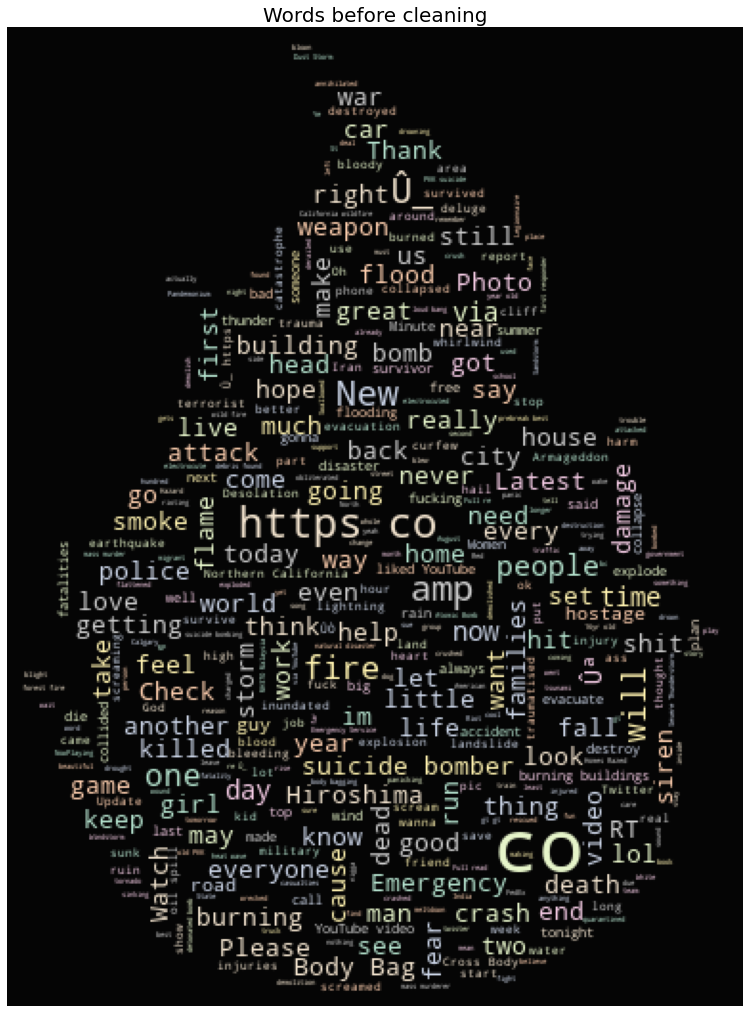

In [18]:
plt.figure(figsize=(20,18))
wc = WordCloud( background_color="black", max_words=10000, 
               mask=hcmask, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(words))
plt.title("Words before cleaning", fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

As you can see CO and HTTPS are the most occuring words which are not related to the topic of our analysis. The text is raw lets do some filtering to dive more deep into our analysis

## Natural Language Processing

Behind the scenes, text pre-processing can be boiled down to these few simple steps:

**Tokenization** - The process of mapping sentences from character to strings and strings into words are initially the basic steps of any NLP problem because to understand any text or document we need to understand the meaning of the text by interpreting words/sentences present in the text. .

**Stopwords** - Throw away any words that occur too frequently as its frequency of occurrence will not be useful in helping detecting relevant texts.

**Stemming** - the process of reducing inflected (or sometimes derived) words to their word stem, base or root form - generally a written form of the word

**Vectorization** - Converting text into vector format. One of the simplest is the famous bag-of-words approach, where you create a matrix (for each document or text in the corpus). In the simplest form, this matrix stores word frequencies (word counts) and is oft referred to as vectorization of the raw text.

 We will use library spacy for our processing

### Embeddings and Text Cleaning

When you have pre-trained embedding, it might not be a good idea to do standard preprocessing steps because some of the important information can be lost. It is easier to get as close to embedding vocabulary as possible. Train vocab and test vocab are created by counting the words in tweets to do this. 

Text cleaning is based on the following embedments: 

- GloVe-300d-840B 
- FastText-Crawl-300d-2M 

In [19]:
%%time

glove_embeddings = np.load('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', allow_pickle=True)
fasttext_embeddings = np.load('../input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl', allow_pickle=True)

CPU times: user 16.6 s, sys: 5.75 s, total: 22.3 s
Wall time: 32.2 s



Words are processed along with their counts in the intersection of vocab and embedding. Vocabulary terms that do not exist in embedding are stored together with their numbers in oov. N covered and n oov are the total number of counts used to measure percentages of coverage. 

There is more than 50 percent vocabulary and 80 percent text coverage without cleaning in both GloVe and FastText embeddings. Coverage for GloVe and FastText is very similar, but GloVe has slightly greater coverage.


In [20]:
def build_vocab(X):
    
    tweets = X.apply(lambda s: s.split()).values      
    vocab = {}
    
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab


def check_embeddings_coverage(X, embeddings):
    
    vocab = build_vocab(X)    
    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(disaster_tweets_train['text'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(disaster_tweets_test['text'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(disaster_tweets_train['text'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(disaster_tweets_test['text'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))


GloVe Embeddings cover 52.06% of vocabulary and 82.68% of text in Training Set
GloVe Embeddings cover 57.21% of vocabulary and 81.85% of text in Test Set
FastText Embeddings cover 51.52% of vocabulary and 81.84% of text in Training Set
FastText Embeddings cover 56.55% of vocabulary and 81.12% of text in Test Set


In [21]:
def clean(tweet): 
            
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"OutBid", "outbid", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
    tweet = re.sub(r"15PM", "15 PM", tweet)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
    tweet = re.sub(r"NANKANA", "Nankana", tweet)
    tweet = re.sub(r"SAHIB", "Sahib", tweet)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet)
    tweet = re.sub(r"PINER", "Piner", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"hempoil", "hemp oil", tweet)
    tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
    tweet = re.sub(r"tubestrike", "tube strike", tweet)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
    tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
    tweet = re.sub(r"TI5", "The International 5", tweet)
    tweet = re.sub(r"thehill", "the hill", tweet)
    tweet = re.sub(r"3others", "3 others", tweet)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
    tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
    tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
    tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet)
    tweet = re.sub(r"andword", "and word", tweet)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"57am", "57 am", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"under50", "under 50", tweet)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"amwriting", "am writing", tweet)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
    tweet = re.sub(r"Nowlike", "Now like", tweet)
    tweet = re.sub(r"seasonfrom", "season from", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"sicklife", "sick life", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
    tweet = re.sub(r"newauthors", "new authors", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"44PM", "44 PM", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"40PM", "40 PM", tweet)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
    tweet = re.sub(r"ithats", "that is", tweet)
    tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
    tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
    tweet = re.sub(r"02PM", "02 PM", tweet)
    tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
    tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
    tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
    tweet = re.sub(r"incubusband", "incubus band", tweet)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
    tweet = re.sub(r"win10", "Windows 10", tweet)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
    tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
    tweet = re.sub(r"crewlist", "crew list", tweet)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
    tweet = re.sub(r"pctool", "pc tool", tweet)
    tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
    tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
    tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
    tweet = re.sub(r"writerslife", "writers life", tweet)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
    tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet)
    tweet = re.sub(r"vscodc", "vsco DC", tweet)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet)
    tweet = re.sub(r"WorldOil", "World Oil", tweet)
    tweet = re.sub(r"redwedding", "red wedding", tweet)
    tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
    tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
    tweet = re.sub(r"bleased", "blessed", tweet)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
    tweet = re.sub(r"changetheworld", "change the world", tweet)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
    tweet = re.sub(r"letsFootball", "let us Football", tweet)
    tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
    tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
    tweet = re.sub(r"22PM", "22 PM", tweet)
    tweet = re.sub(r"54am", "54 AM", tweet)
    tweet = re.sub(r"38am", "38 AM", tweet)
    tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
    tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
    tweet = re.sub(r"2k15", "2015", tweet)
    tweet = re.sub(r"TheIran", "Iran", tweet)
    tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
    tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
    tweet = re.sub(r"defense_news", "defense news", tweet)
    tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
    tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
    tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"ineedcake", "I need cake", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
    tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
    tweet = re.sub(r"irongiant", "iron giant", tweet)
    tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
    tweet = re.sub(r"TimCook", "Tim Cook", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet)
    tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
    tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet)
    tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
    tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
    tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
    tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
    tweet = re.sub(r"NotSorry", "not sorry", tweet)
    tweet = re.sub(r"UseYourWords", "use your words", tweet)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"uiseful", "useful", tweet)
    tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
    tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
    tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
    tweet = re.sub(r"birdgang", "bird gang", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet)
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
    tweet = re.sub(r"sothathappened", "so that happened", tweet)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
    tweet = re.sub(r"NationFirst", "Nation First", tweet)
    tweet = re.sub(r"IndiaToday", "India Today", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"BidTime", "Bid Time", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
    tweet = re.sub(r"eatshit", "eat shit", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
    tweet = re.sub(r"facilitydude", "facility dude", tweet)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
    tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
    tweet = re.sub(r"RiverComplex", "River Complex", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"IranElection", "Iran Election", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"slownewsday", "slow news day", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
    tweet = re.sub(r"netbots", "net bots", tweet)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"EndofUS", "End of United States", tweet)
    tweet = re.sub(r"35PM", "35 PM", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"76mins", "76 minutes", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"livesmatter", "lives matter", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
    tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
    tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"YEEESSSS", "yes", tweet)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
    tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
    tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
    tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
    tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
    tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
    tweet = re.sub(r"FromTheField", "From the field", tweet)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
    tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
    tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
    tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
    tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
    tweet = re.sub(r"Evaucation", "evacuation", tweet)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
    tweet = re.sub(r"localplumber", "local plumber", tweet)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
    tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
    tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
    tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
    tweet = re.sub(r"wfocus", "focus", tweet)
    tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
    tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
    tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
    tweet = re.sub(r"bedhair", "bed hair", tweet)
    tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)
           
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')      
        
    # Acronyms
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)    
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)    
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)   
    
    # Grouping same words without embeddings
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)
    
    return tweet

In [22]:
disaster_tweets_train['text'] = disaster_tweets_train['text'].str.lower()
# removing special characters and numbers
disaster_tweets_train['text_cleaned'] = disaster_tweets_train['text'].apply(lambda s : clean(s))
disaster_tweets_test['text_cleaned'] = disaster_tweets_test['text'].apply(lambda s : clean(s))

In [23]:

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(disaster_tweets_train['text_cleaned'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(disaster_tweets_test['text_cleaned'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(disaster_tweets_train['text_cleaned'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(disaster_tweets_test['text_cleaned'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

GloVe Embeddings cover 74.92% of vocabulary and 95.91% of text in Training Set
GloVe Embeddings cover 88.09% of vocabulary and 97.32% of text in Test Set
FastText Embeddings cover 74.46% of vocabulary and 95.89% of text in Training Set
FastText Embeddings cover 87.80% of vocabulary and 97.25% of text in Test Set


After cleaning the tweets, glove_embeddings and fasttext_embeddings are deleted and garbage collected because they consume too much memory (10+ gigabytes).

In [24]:
del glove_embeddings, fasttext_embeddings, train_glove_oov, test_glove_oov, train_fasttext_oov, test_fasttext_oov
gc.collect()

31


### Tokenization

In [25]:
import spacy
nlp = spacy.load('en')

In [26]:
disaster_tweets_train_vi = disaster_tweets_train.copy()

In [27]:
disaster_tweets_train_vi['parsed'] = disaster_tweets_train_vi.text_cleaned.apply(nlp)

In [28]:
disaster_tweets_train_vi.head()

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,text_cleaned,parsed
0,1,no_keyword,no_location,our deeds are the reason of this #earthquake m...,1,13,13,6,0,4.384615,69,1,1,0,our deeds are the reason of this # earthquake...,"(our, deeds, are, the, reason, of, this, , #,..."
1,4,no_keyword,no_location,forest fire near la ronge sask. canada,1,7,7,0,0,4.571429,38,1,0,0,forest fire near la ronge sask . canada,"(forest, fire, near, la, ronge, sask, ., , ca..."
2,5,no_keyword,no_location,all residents asked to 'shelter in place' are ...,1,22,20,11,0,5.090909,133,3,0,0,all residents asked to ' shelter in place ' ...,"(all, residents, asked, to, , ', shelter, in,..."
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,8,8,1,0,7.125000,65,2,1,0,"13,000 people receive # wildfires evacuation ...","(13,000, people, receive, , #, wildfires, eva..."
4,7,no_keyword,no_location,just got sent this photo from ruby #alaska as ...,1,16,15,7,0,4.500000,88,2,2,0,just got sent this photo from ruby # alaska a...,"(just, got, sent, this, photo, from, ruby, , ..."


You can see the parsed text column and the text is tokenized after lemmetization and stemming

Here we are counting the number of documents in each key work category

In [29]:
print("Document Count")
print(disaster_tweets_train_vi.groupby('keyword')['text'].count())
print("Word Count")
disaster_tweets_train.groupby('keyword').apply(lambda x: x.text.apply(lambda x: len(x.split())).sum())

Document Count
keyword
ablaze                   36
accident                 35
aftershock               34
airplane%20accident      35
ambulance                38
annihilated              34
annihilation             29
apocalypse               32
armageddon               42
army                     34
arson                    32
arsonist                 34
attack                   36
attacked                 35
avalanche                30
battle                   26
bioterror                37
bioterrorism             30
blaze                    38
blazing                  34
bleeding                 35
blew%20up                33
blight                   32
blizzard                 37
blood                    35
bloody                   35
blown%20up               33
body%20bag               33
body%20bagging           33
body%20bags              41
bomb                     34
bombed                   38
bombing                  29
bridge%20collapse        35
buildings%20burning      

keyword
ablaze                   501
accident                 534
aftershock               507
airplane%20accident      536
ambulance                487
annihilated              534
annihilation             464
apocalypse               485
armageddon               606
army                     500
arson                    408
arsonist                 370
attack                   505
attacked                 557
avalanche                415
battle                   383
bioterror                552
bioterrorism             470
blaze                    486
blazing                  511
bleeding                 458
blew%20up                491
blight                   474
blizzard                 408
blood                    461
bloody                   500
blown%20up               566
body%20bag               582
body%20bagging           493
body%20bags              579
bomb                     449
bombed                   576
bombing                  396
bridge%20collapse        552
buildi

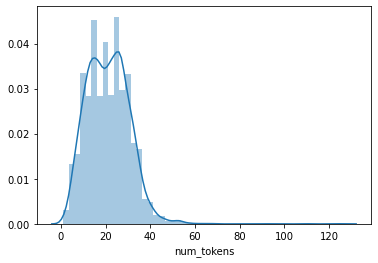

In [30]:
# Sum the number of tokens in each Doc
disaster_tweets_train_vi['num_tokens'] = [len(token) for token in disaster_tweets_train_vi.parsed]
# Visualize histogram of tokens per tweet
g = sns.distplot(disaster_tweets_train_vi.num_tokens)

In [31]:
disaster_tweets_train_vi

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,text_cleaned,parsed,num_tokens
0,1,no_keyword,no_location,our deeds are the reason of this #earthquake m...,1,13,13,6,0,4.384615,69,1,1,0,our deeds are the reason of this # earthquake...,"(our, deeds, are, the, reason, of, this, , #,...",15
1,4,no_keyword,no_location,forest fire near la ronge sask. canada,1,7,7,0,0,4.571429,38,1,0,0,forest fire near la ronge sask . canada,"(forest, fire, near, la, ronge, sask, ., , ca...",9
2,5,no_keyword,no_location,all residents asked to 'shelter in place' are ...,1,22,20,11,0,5.090909,133,3,0,0,all residents asked to ' shelter in place ' ...,"(all, residents, asked, to, , ', shelter, in,...",28
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,8,8,1,0,7.125000,65,2,1,0,"13,000 people receive # wildfires evacuation ...","(13,000, people, receive, , #, wildfires, eva...",10
4,7,no_keyword,no_location,just got sent this photo from ruby #alaska as ...,1,16,15,7,0,4.500000,88,2,2,0,just got sent this photo from ruby # alaska a...,"(just, got, sent, this, photo, from, ruby, , ...",20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,no_keyword,no_location,two giant cranes holding a bridge collapse int...,1,11,11,2,1,6.636364,83,5,0,0,two giant cranes holding a bridge collapse int...,"(two, giant, cranes, holding, a, bridge, colla...",10
7609,10870,no_keyword,no_location,@aria_ahrary @thetawniest the out of control w...,1,20,17,9,0,5.300000,125,5,0,2,@ Aria Ahrary @ thetawniest the out of contr...,"( , @, Aria, Ahrary, , @, thetawniest, the, o...",28
7610,10871,no_keyword,no_location,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1,8,8,1,1,7.250000,65,11,0,0,m1 . 94 [ 01 : 04 utc ] ? 5km s of volcano h...,"(m1, ., 94, , [, 01, :, 04, utc, ], , ?, 5, ...",20
7611,10872,no_keyword,no_location,police investigating after an e-bike collided ...,1,19,19,5,0,6.263158,137,5,0,0,police investigating after an e - bike collide...,"(police, investigating, after, an, e, -, bike,...",28


In [32]:
disaster_tweets_train_vi['target_alias'] = disaster_tweets_train_vi.target.map({1: "Disaster", 0 : "Not Disaster" })

In [33]:
corpus = st.CorpusFromParsedDocuments(disaster_tweets_train_vi, category_col = 'target_alias',parsed_col= 'parsed').build()

This shows the Top 10 most frequent used words by Disaster and non disaster tweet and how frequently each words are used per 25k words and what’s it’s tf-idf score

In [34]:
html = produce_scattertext_explorer(corpus,
                                    category= 'Disaster',
                                    category_name= 'Disaster-tweets',
                                    not_category_name= 'Not-Disaster-tweets',
                                    width_in_pixels=1000,
                                    minimum_term_frequency=5,
                                    transform=st.Scalers.scale,
                                    metadata=disaster_tweets_train_vi['keyword'])
file_name = 'DisasterTweetsScattertextScale.html'

open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1000, height=700)

This shows the chracteristic terms used by candidates from both categories of the target variable and which is more informative compared to the graph above


In [35]:
html = st.produce_scattertext_explorer(corpus,
                                       category= 'Disaster',
                                       category_name= 'Disaster-tweets',
                                       not_category_name= 'Not-Disaster-tweets',
                                       minimum_term_frequency=5,
                                       width_in_pixels=1000,
                                       transform=st.Scalers.log_scale_standardize)
file_name = 'DisasterTweetsScattertextScaleLog.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1200, height=700)

The follow visuals ranks each term by frequency percentile instead of raw frequencies

In [36]:
html = produce_scattertext_explorer(corpus,
                                    category= 'Disaster',
                                    category_name= 'Disaster-tweets',
                                    not_category_name= 'Not-Disaster-tweets',
                                    width_in_pixels=1000,
                                    minimum_term_frequency=5,
                                    transform=st.Scalers.percentile,
                                    metadata=disaster_tweets_train_vi['keyword'])
file_name = 'DisasterTweetsScattertextRankData.html'

open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1000, height=700)

#### Same text classified differently

From the analysis above we found few similar tweets are alternatively classified. Here we will get the missclassified tweets and classify it properly

In [37]:
df_mislabeled = disaster_tweets_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_mislabeled.index.tolist()

['like for the music video i want some real action shit like burning buildings and police chases not some weak ben winston shit',
 'rt notexplained: the only known image of infamous hijacker d.b. cooper. http://t.co/jlzk2hdetg',
 'wowo--=== 12000 nigerian refugees repatriated from cameroon',
 'hellfire is surrounded by desires so be careful and don\x89ûªt let your desires control you! #afterlife',
 'hellfire! we don\x89ûªt even want to think about it or mention it so let\x89ûªs not do anything that leads to it #islam!',
 'who is bringing the tornadoes and floods. who is bringing the climate change. god is after america he is plaguing her\n \n#farrakhan #quote',
 'i pledge allegiance to the p.o.p.e. and the burning buildings of epic city. ??????',
 '#allah describes piling up #wealth thinking it would last #forever as the description of the people of #hellfire in surah humaza. #reflect',
 '#foodscare #offers2go #nestleindia slips into loss after #magginoodle #ban unsafe and hazardous fo

In [38]:
disaster_tweets_train['target_relabeled'] = disaster_tweets_train['target'].copy() 

disaster_tweets_train.loc[disaster_tweets_train['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
disaster_tweets_train.loc[disaster_tweets_train['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
disaster_tweets_train.loc[disaster_tweets_train['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
disaster_tweets_train.loc[disaster_tweets_train['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
disaster_tweets_train.loc[disaster_tweets_train['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
disaster_tweets_train.loc[disaster_tweets_train['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
disaster_tweets_train.loc[disaster_tweets_train['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0
disaster_tweets_train.loc[disaster_tweets_train['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 1
disaster_tweets_train.loc[disaster_tweets_train['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
disaster_tweets_train.loc[disaster_tweets_train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
disaster_tweets_train.loc[disaster_tweets_train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
disaster_tweets_train.loc[disaster_tweets_train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
disaster_tweets_train.loc[disaster_tweets_train['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_relabeled'] = 0
disaster_tweets_train.loc[disaster_tweets_train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
disaster_tweets_train.loc[disaster_tweets_train['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 1
disaster_tweets_train.loc[disaster_tweets_train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0
disaster_tweets_train.loc[disaster_tweets_train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
disaster_tweets_train.loc[disaster_tweets_train['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0

In [39]:
df_train_data = disaster_tweets_train.copy()
df_test_data =  disaster_tweets_test.copy()

### Topic modelling

Topic modeling is one of the more complicated methods to identify natural topics in the text. A prime advantage of topic modeling is that it is an unsupervised technique. Model training and a labeled training dataset are not required.

There are quite a few algorithms for topic modeling:

- Latent Semantic Analysis (LSA)
- Probabilistic Latent Semantic Analysis (PLSA)
- Latent Dirichlet Allocation (LDA)
- Correlated Topic Model (CTM).

One of the most popular methods is **latent Dirichlet allocation**. The premise of LDA is that each text document comprises of several topics and each topic comprises of several words. The input required by LDA is merely the text documents and the expected number of topics.

In [40]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

 #### Lemmatization

In [41]:
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [42]:
# Storing the entire training text in a list
text = list(disaster_tweets_train.text_cleaned.values)
# Calling our overwritten Count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

#### Revisiting our Term frequencies

Having implemented our lemmatized count vectorizer, let us revist the plots for the term frquencies of the top 50 words (by frequency). As you can see from the plot, all our prior preprocessing efforts have not gone to waste. With the removal of stopwords, the remaining words seem much more meaningful where you can see that all the stopwords in the earlier term frequency plot

In [43]:
feature_names = tf_vectorizer.get_feature_names()
count_vec = np.asarray(tf.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))
# Now I want to extract out on the top 15 and bottom 15 words
Y = np.concatenate([y[0:15], y[-16:-1]])
X = np.concatenate([x[0:15], x[-16:-1]])

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[0:50],
            y = y[0:50],
            marker= dict(colorscale='RdBu',
                         color = y[0:50]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

fig.show()

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[-100:],
            y = y[-100:],
            marker= dict(colorscale='greens',
                         color = y[-100:]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Bottom 100 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

fig.show()

### Latent Dirichlet Allocation

In [44]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [45]:
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=11, random_state=0)

##### Topics generated by LDA
We will utilise our helper function we defined earlier "print_top_words" to return the top 10 words attributed to each of the LDA generated topics. To select the number of topics, this is handled through the parameter n_components in the function.

In [46]:
n_top_words = 30
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)



Topics in LDA model: 

Topic #0:california fire let ûªs come 10 say northern people end suspect market 30 time evacuate face affected flood pkk getting rule drought sue care thanks feeling trouble 50 doing storm

Topic #1:today want help city hostage say war hot read wound hope know panic food summer save free harm group power case effect storm hiroshima send memory survivor fight military miner

Topic #2:year people just old got wildfire photo great need wave wreckage collapse woman right flame officer heat natural day rescuer tsunami pic meltdown place bridge bomb making lady violent update

Topic #3:love û_ train going life plan wrecked rt stock hit story fear girl volcano fucking kid seismic caused high burning word came hurricane medium islam country support rubble line derailment

Topic #4:new emergency day good body best black bomb 2015 building movie run report siren tornado police bag man ruin riot tonight atomic baby gonna war smoke coming shot post land

Topic #5:suicide po

In [47]:
topic_words = list()
for j in range(10):
    topic_words.append([tf_feature_names[i] for i in lda.components_[j].argsort()[:-50 - 1 :-1]])

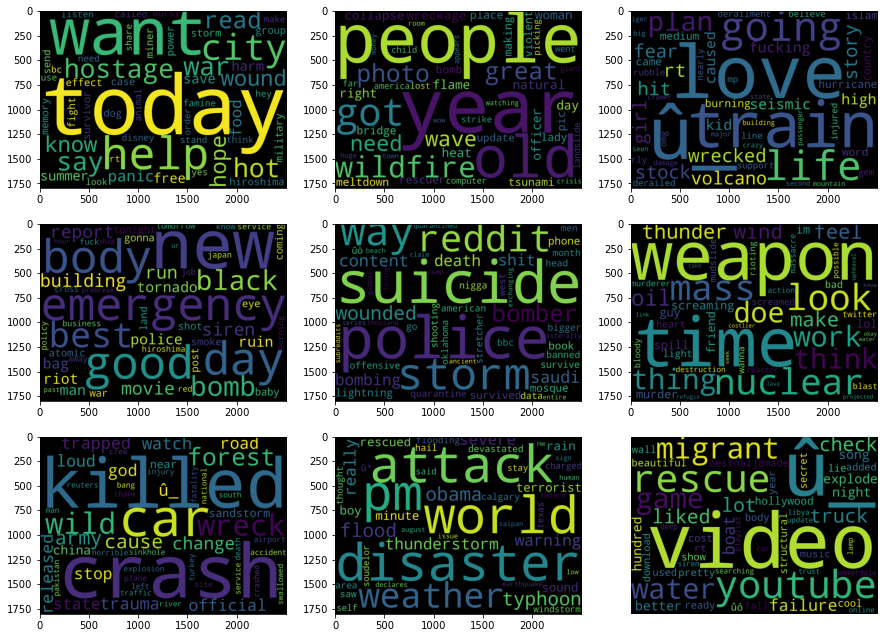

In [48]:
columns = 3
rows = 4
fig=plt.figure(figsize=(15, 15))
for i in range(1, 10):
    img =  WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(topic_words[i]))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    
plt.axis('off')
plt.show()


### Visualizing Embeddings

In [49]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Not')
            blue_patch = mpatches.Patch(color='blue', label='Real')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})


## SVM 

An SVM is a kind of large-margin classifier: it is a vector space based machine learning method where the goal is to find a decision boundary between two classes that is maximally far from any point in the training data (possibly discounting some points as outliers or noise).



In [50]:
tfidf = TfidfVectorizer()
classifier = LinearSVC()

In [51]:
x = disaster_tweets_train['text_cleaned']

y = disaster_tweets_train['target_relabeled']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

vectorisation of the train data

In [53]:
tfidf.fit(x)

TfidfVectorizer()

In [54]:
X_train_tf = tfidf.transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [55]:
classifier.fit(X_train_tf,y_train )

LinearSVC()

In [56]:
y_pred = classifier.predict(X_test_tf)

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       874
           1       0.80      0.70      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [58]:
Test = tfidf.transform(disaster_tweets_test['text_cleaned'])

In [59]:
y_pred_test= classifier.predict(Test)

In [60]:
predict_file = pd.DataFrame({'id':disaster_tweets_test['id'],'target':y_pred_test.round().astype(int)})
# predict_file.to_csv('submission.csv',index=False)

## LSTM


In [61]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [62]:
max_words = 4000
max_len = 40
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

#### RNN
Define the RNN structure.

In [63]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model_lstm = Model(inputs=inputs,outputs=layer)
    return model_lstm

call the function and compile the model.

In [64]:
model_lstm = RNN()
model_lstm.summary()
model_lstm.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 40)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 40, 50)            200000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                

Fit on the training data.

In [65]:
model_lstm.fit(sequences_matrix,y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
39/39 [==============================] - 1s 21ms/step - loss: 0.6200 - accuracy: 0.6533 - val_loss: 0.5330 - val_accuracy: 0.7266
Epoch 2/10
39/39 [==============================] - 0s 9ms/step - loss: 0.4083 - accuracy: 0.8255 - val_loss: 0.4599 - val_accuracy: 0.7915
Epoch 3/10
39/39 [==============================] - 0s 10ms/step - loss: 0.3332 - accuracy: 0.8686 - val_loss: 0.4600 - val_accuracy: 0.7931


The model performs well on the validation set and this configuration is chosen as the final model.

In [66]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)


Evaluate the model on the test set.

In [67]:
accr = model_lstm.evaluate(test_sequences_matrix,y_test)

48/48 [==============================] - 0s 3ms/step - loss: 0.4636 - accuracy: 0.7892


In [68]:
test_X = list(disaster_tweets_test["text_cleaned"])

# Convert text to sequences
sequences = tok.texts_to_sequences(test_X)

# Pad sequences
sequences_matrix = sequence.pad_sequences(sequences,
                             maxlen=max_len,
                             dtype='int32',
                             value=0)

# Predict sequences
predicted = model_lstm.predict(sequences_matrix)

binary_predicted = np.array(predicted) >= 0.5
targets = binary_predicted.astype(int).reshape((len(binary_predicted)))
# my_submission = pd.DataFrame({'id': disaster_tweets_test.id, 'target': targets})
# my_submission.to_csv('submission.csv', index=False)

print("Submission file created!")

Submission file created!


### Error Analysis For LSTM

Real values of testdata

In [69]:
predicted = pd.DataFrame(predicted)
predicted.columns = ['predicted']
predicted.to_csv('train_preds.csv', index=False)

In [70]:
df_train_preproc = disaster_tweets_train
df_train_preproc.to_csv('df_train_preprocessed.csv')

In [71]:
y_train[0:10]

4996    1
3263    0
4907    1
2855    1
4716    0
7538    1
3172    1
3932    1
5833    1
7173    0
Name: target_relabeled, dtype: int8

In [72]:
df_train_erroe = pd.read_csv("../input/nlp-getting-started/train.csv")
df_train_preproc = pd.read_csv("df_train_preprocessed.csv")
train_preds = pd.read_csv('train_preds.csv')

In [73]:
train_preds[0:10].T

,0,1,2,3,4,5,6,7,8,9
predicted,0.759881,0.906951,0.867073,0.52222,0.979783,0.696762,0.151796,0.147945,0.128088,0.165355


#### Add our predictions along the original data

In [74]:
combined = pd.concat([df_train_erroe, train_preds], axis=1, sort=False)
combined.head()

,id,keyword,location,text,target,predicted
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.759881
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.906951
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.867073
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.522220
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.979783


#### Count the error
Real value of class is 0 or 1, error is how far our prediction is from this.

In [75]:
combined['error'] = abs(combined['target'] - combined['predicted']) 
combined.head()

,id,keyword,location,text,target,predicted,error
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.759881,0.240119
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.906951,0.093049
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.867073,0.132927
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.522220,0.477780
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.979783,0.020217


In [76]:
pd.set_option('display.max_colwidth', None) 
combined.head()

,id,keyword,location,text,target,predicted,error
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,0.759881,0.240119
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.906951,0.093049
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,0.867073,0.132927
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,0.522220,0.477780
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,0.979783,0.020217


#### Sort the items in decreasing order of error amount

In [77]:
sorted = combined.sort_values(by=['error'], ascending=False)

### False Positive with biggest error - not disastrous but predicted strongly as disastrous

In [78]:
sorted[ sorted['target']==0] [0:14]

,id,keyword,location,text,target,predicted,error
2750,3953,devastation,uk,Obsolete devastation from Broad with the Ball. And Root doing it with Bat in hand. Great Day #ashes2015 #ENGvAUS http://t.co/a7TJAWWtJ7,0,0.999988,0.999988
1066,1538,bomb,keli x,HALSEY AND TROYE COLLAB WOULD BE BOMB,0,0.999980,0.999980
1072,1547,bomb,whs '17,@daniglasgow45 Happy birthday big D!!! I miss you girl hope you have a bomb one ???? http://t.co/cFouwPBRCG,0,0.999980,0.999980
2388,3433,derail,#MadeInNorthumberland,Various issues fail to derail homes bid http://t.co/zhsLl7swBh,0,0.999946,0.999946
1195,1721,buildings%20burning,NaN,@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!,0,0.999927,0.999927
943,1365,blown%20up,NaN,@KalinAndMyles @KalinWhite my ig is being blown up just with hackers I need it to stop #givebackkalinwhiteaccount,0,0.999924,0.999924
2369,3406,derail,Road to the Billionaires Club,@ModelBubbles GM! I pray any attack of the enemy 2 derail ur destiny is blocked by the Lord &amp; that He floods ur life w/heavenly Blessings,0,0.999913,0.999913
859,1241,blood,NaN,@SetZorah dad why dont you claim me that mean that not right we look the same same eyes same blood same xbox 360 SMH -.-,0,0.999912,0.999912
509,735,attacked,"Anna Maria, FL",@christinalavv @lindsay_wynn3 I just saw these tweets and I feel really attacked,0,0.999905,0.999905
947,1372,blown%20up,"Grimsby, England",My dogÛªs just blown his kennel up ÛÒ Bloody Yorkshire Terrorist,0,0.999900,0.999900


Here due to some disastorous keywords its predicted wrongly

### View False negatives - Disastrous but predicted as non disastrous

In [79]:
 pd.options.display.float_format = "{:.8f}".format

In [80]:
disastrous = sorted[sorted['target']==1]
disastrous[0:14]

,id,keyword,location,text,target,predicted,error
1110,1603,bombed,The land of New Jersey.,Shadowflame and the Wraith: Bombed http://t.co/LDBaO0rSuz via @amazon,1,0.01361326,0.98638674
437,635,arsonist,New York,Arsonist Sets NYC Vegetarian Restaurant on Fire: Police #NewYork - http://t.co/Nr7usT3uh8,1,0.01751275,0.98248725
2504,3595,desolate,the insane asylum.,@CorleoneDaBoss bc its risky and costly I don't see a need to do that when there isn't anything there. It's totally desolate.,1,0.01775654,0.98224346
53,77,ablaze,Anaheim,Police: Arsonist Deliberately Set Black Church In North CarolinaåÊAblaze http://t.co/pcXarbH9An,1,0.01916587,0.98083413
2454,3522,derailment,India,Madhya Pradesh Train Derailment: Village Youth Saved Many Lives,1,0.02041928,0.97958072
2456,3524,derailment,NaN,Madhya Pradesh Train Derailment: Village Youth Saved Many Lives: A group of villagers saved over 70 passengers' lives after two train...,1,0.02041928,0.97958072
462,667,attack,"West Bank, Gaza Strip",Israeli forces raid home of alleged car attack suspect http://t.co/3GVUS8NPpy #palestine,1,0.02252765,0.97747235
434,630,arsonist,California,Alleged East Bay serial arsonist arrested #SanFrancisco - http://t.co/ojuHfkHVb2,1,0.02375089,0.97624911
468,677,attack,NaN,Police: Assailant in latest US movie theatre attack was homeless had psychological issues http://t.co/zdCvlYq6qK,1,0.03049611,0.96950389
448,651,attack,NaN,http://t.co/pTKrXtZjtV Nashville Theater Attack: Will Gun Grabbers Now Demand ÛÏHatchet Control?Û,1,0.03067144,0.96932856


### Most correct predictions

In [81]:
sorted_increasing = combined.sort_values(by=['error'], ascending=True)
sorted_increasing[0:10]

,id,keyword,location,text,target,predicted,error
508,734,attacked,America,Christian Attacked by Muslims at the Temple Mount after Waving Israeli Flag via Pamela Geller - ... http://t.co/EMDJNNltP0,1,0.99999475,0.00000525
2050,2942,danger,ALWAYS DYING NEVER RESTING,SO THIRSTY YALL IN DANGER OF DEHYDRATION,1,0.99997880,0.00002120
2759,3962,devastation,contactSimpleNews@gmail.com,70 Years After Atomic Bombs Japan Still Struggles With War Past: The anniversary of the devastation wrought b... http://t.co/LtVVPfLSg8,1,0.99996960,0.00003040
2747,3950,devastation,St Joseph de Beauce,In this fragile global economy considering the devastation the alternatives would cause ... it's the best reason .. https://t.co/zwVyisyP2B,1,0.99995065,0.00004935
502,727,attacked,"San Francisco, CA",Kelly Osbourne attacked for racist Donald Trump remark about Latinos on The View http://t.co/7nAgdSAdWP,1,0.99994206,0.00005794
72,104,accident,"Walker County, Alabama",Reported motor vehicle accident in Curry on Herman Rd near Stephenson involving an overturned vehicle. Please use... http://t.co/YbJezKuRW1,1,0.99992955,0.00007045
74,107,accident,North Carolina,I-77 Mile Marker 31 South Mooresville Iredell Vehicle Accident Ramp Closed at 8/6 1:18 PM,1,0.99992955,0.00007045
1189,1712,bridge%20collapse,NaN,Two cranes restoring a bridge in the central Dutch town of Alphen aan den Rijn collapse on to buildings with rescuers searching for,1,0.99992657,0.00007343
1191,1716,bridge%20collapse,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/9asc1hhFNJ,1,0.99992657,0.00007343
3051,4378,earthquake,NaN,Contruction upgrading ferries to earthquake standards in Vashon Mukilteo: The upgrades will bring the vulnera... http://t.co/Au5jWGT0ar,1,0.99992657,0.00007343


#### Limitaions of LSTM

Attention can only deal with fixed-length text strings. The text has to be split into a certain number of segments or chunks before being fed into the system as input This chunking of text causes context fragmentation. For example, if a sentence is split from the middle, then a significant amount of context is lost. In other words, the text is split without respecting the sentence or any other semantic boundary

But,undoutedly transformer inspired BERT and all the following breakthroughs in NLP.

In [82]:

K = 3
skf = StratifiedKFold(n_splits=K, random_state=SEED, shuffle=True)

DISASTER = df_train_data['target'] == 1
print('Whole Training Set Shape = {}'.format(df_train_data.shape))
print('Whole Training Set Unique keyword Count = {}'.format(df_train_data['keyword'].nunique()))
print('Whole Training Set Target Rate (Disaster) {}/{} (Not Disaster)'.format(df_train_data[DISASTER]['target_relabeled'].count(), df_train_data[~DISASTER]['target_relabeled'].count()))

for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train_data['text_cleaned'], df_train_data['target']), 1):
    print('\nFold {} Training Set Shape = {} - Validation Set Shape = {}'.format(fold, df_train_data.loc[trn_idx, 'text_cleaned'].shape, df_train_data.loc[val_idx, 'text_cleaned'].shape))
    print('Fold {} Training Set Unique keyword Count = {} - Validation Set Unique keyword Count = {}'.format(fold, df_train_data.loc[trn_idx, 'keyword'].nunique(), df_train_data.loc[val_idx, 'keyword'].nunique()))

Whole Training Set Shape = (7613, 16)
Whole Training Set Unique keyword Count = 222
Whole Training Set Target Rate (Disaster) 3271/4342 (Not Disaster)

Fold 1 Training Set Shape = (5075,) - Validation Set Shape = (2538,)
Fold 1 Training Set Unique keyword Count = 222 - Validation Set Unique keyword Count = 222

Fold 2 Training Set Shape = (5075,) - Validation Set Shape = (2538,)
Fold 2 Training Set Unique keyword Count = 222 - Validation Set Unique keyword Count = 222

Fold 3 Training Set Shape = (5076,) - Validation Set Shape = (2537,)
Fold 3 Training Set Unique keyword Count = 222 - Validation Set Unique keyword Count = 222


## BERT

In [83]:
class ClassificationReport(Callback):
    
    def __init__(self, train_data=(), validation_data=()):
        super(Callback, self).__init__()
        
        self.X_train, self.y_train = train_data
        self.train_precision_scores = []
        self.train_recall_scores = []
        self.train_f1_scores = []
        
        self.X_val, self.y_val = validation_data
        self.val_precision_scores = []
        self.val_recall_scores = []
        self.val_f1_scores = [] 
               
    def on_epoch_end(self, epoch, logs={}):
        train_predictions = np.round(self.model.predict(self.X_train, verbose=0))        
        train_precision = precision_score(self.y_train, train_predictions, average='macro')
        train_recall = recall_score(self.y_train, train_predictions, average='macro')
        train_f1 = f1_score(self.y_train, train_predictions, average='macro')
        self.train_precision_scores.append(train_precision)        
        self.train_recall_scores.append(train_recall)
        self.train_f1_scores.append(train_f1)
        
        val_predictions = np.round(self.model.predict(self.X_val, verbose=0))
        val_precision = precision_score(self.y_val, val_predictions, average='macro')
        val_recall = recall_score(self.y_val, val_predictions, average='macro')
        val_f1 = f1_score(self.y_val, val_predictions, average='macro')
        self.val_precision_scores.append(val_precision)        
        self.val_recall_scores.append(val_recall)        
        self.val_f1_scores.append(val_f1)
        
        print('\nEpoch: {} - Training Precision: {:.6} - Training Recall: {:.6} - Training F1: {:.6}'.format(epoch + 1, train_precision, train_recall, train_f1))
        print('Epoch: {} - Validation Precision: {:.6} - Validation Recall: {:.6} - Validation F1: {:.6}'.format(epoch + 1, val_precision, val_recall, val_f1)) 

In [84]:
%%time

bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)

CPU times: user 13.2 s, sys: 1.63 s, total: 14.8 s
Wall time: 16.5 s


### Architecture

In [85]:
class DisasterDetector:
    
    def __init__(self, bert_layer, max_seq_length=128, lr=0.0001, epochs=15, batch_size=32):
        
        # BERT and Tokenization params
        self.bert_layer = bert_layer
        
        self.max_seq_length = max_seq_length        
        vocab_file = self.bert_layer.resolved_object.vocab_file.asset_path.numpy()
        do_lower_case = self.bert_layer.resolved_object.do_lower_case.numpy()
        self.tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
        
        # Learning control params
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        
        self.models = []
        self.scores = {}
        
        
    def encode(self, texts):
                
        all_tokens = []
        all_masks = []
        all_segments = []

        for text in texts:
            text = self.tokenizer.tokenize(text)
            text = text[:self.max_seq_length - 2]
            input_sequence = ['[CLS]'] + text + ['[SEP]']
            pad_len = self.max_seq_length - len(input_sequence)

            tokens = self.tokenizer.convert_tokens_to_ids(input_sequence)
            tokens += [0] * pad_len
            pad_masks = [1] * len(input_sequence) + [0] * pad_len
            segment_ids = [0] * self.max_seq_length

            all_tokens.append(tokens)
            all_masks.append(pad_masks)
            all_segments.append(segment_ids)

        return np.array(all_tokens), np.array(all_masks), np.array(all_segments)
    
    
    def build_model(self):
        
        input_word_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_word_ids')
        input_mask = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_mask')
        segment_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='segment_ids')    
        
        pooled_output, sequence_output = self.bert_layer([input_word_ids, input_mask, segment_ids])   
        clf_output = sequence_output[:, 0, :]
        out = Dense(1, activation='sigmoid')(clf_output)
        
        model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
        optimizer = SGD(learning_rate=self.lr, momentum=0.8)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        return model
    
    
    def train(self, X):
        
        for fold, (trn_idx, val_idx) in enumerate(skf.split(X['text_cleaned'], X['keyword'])):
            
            print('\nFold {}\n'.format(fold))
        
            X_trn_encoded = self.encode(X.loc[trn_idx, 'text_cleaned'].str.lower())
            y_trn = X.loc[trn_idx, 'target_relabeled']
            X_val_encoded = self.encode(X.loc[val_idx, 'text_cleaned'].str.lower())
            y_val = X.loc[val_idx, 'target_relabeled']
        
            # Callbacks
            metrics = ClassificationReport(train_data=(X_trn_encoded, y_trn), validation_data=(X_val_encoded, y_val))
            
            # Model
            model = self.build_model()        
            model.fit(X_trn_encoded, y_trn, validation_data=(X_val_encoded, y_val), callbacks=[metrics], epochs=self.epochs, batch_size=self.batch_size)
            
            self.models.append(model)
            self.scores[fold] = {
                'train': {
                    'precision': metrics.train_precision_scores,
                    'recall': metrics.train_recall_scores,
                    'f1': metrics.train_f1_scores                    
                },
                'validation': {
                    'precision': metrics.val_precision_scores,
                    'recall': metrics.val_recall_scores,
                    'f1': metrics.val_f1_scores                    
                }
            }
                    
                
    def plot_learning_curve(self):
        
        fig, axes = plt.subplots(nrows=K, ncols=2, figsize=(20, K * 6), dpi=100)
    
        for i in range(K):
            
            # Classification Report curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[i].history.history['val_accuracy'], ax=axes[i][0], label='val_accuracy')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['precision'], ax=axes[i][0], label='val_precision')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['recall'], ax=axes[i][0], label='val_recall')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['f1'], ax=axes[i][0], label='val_f1')        

            axes[i][0].legend() 
            axes[i][0].set_title('Fold {} Validation Classification Report'.format(i), fontsize=14)

            # Loss curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['loss'], ax=axes[i][1], label='train_loss')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['val_loss'], ax=axes[i][1], label='val_loss')

            axes[i][1].legend() 
            axes[i][1].set_title('Fold {} Train / Validation Loss'.format(i), fontsize=14)

            for j in range(2):
                axes[i][j].set_xlabel('Epoch', size=12)
                axes[i][j].tick_params(axis='x', labelsize=12)
                axes[i][j].tick_params(axis='y', labelsize=12)

        plt.show()
        
        
    def predict(self, X):
        
        X_test_encoded = self.encode(X['text_cleaned'].str.lower())
        y_pred = np.zeros((X_test_encoded[0].shape[0], 1))

        for model in self.models:
            y_pred += model.predict(X_test_encoded) / len(self.models)

        return y_pred

In [86]:
df_train_data

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,text_cleaned,target_relabeled
0,1,no_keyword,no_location,our deeds are the reason of this #earthquake may allah forgive us all,1,13,13,6,0,4.38461538,69,1,1,0,our deeds are the reason of this # earthquake may allah forgive us all,1
1,4,no_keyword,no_location,forest fire near la ronge sask. canada,1,7,7,0,0,4.57142857,38,1,0,0,forest fire near la ronge sask . canada,1
2,5,no_keyword,no_location,all residents asked to 'shelter in place' are being notified by officers. no other evacuation or shelter in place orders are expected,1,22,20,11,0,5.09090909,133,3,0,0,all residents asked to ' shelter in place ' are being notified by officers . no other evacuation or shelter in place orders are expected,1
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation orders in california",1,8,8,1,0,7.12500000,65,2,1,0,"13,000 people receive # wildfires evacuation orders in california",1
4,7,no_keyword,no_location,just got sent this photo from ruby #alaska as smoke from #wildfires pours into a school,1,16,15,7,0,4.50000000,88,2,2,0,just got sent this photo from ruby # alaska as smoke from # wildfires pours into a school,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,no_keyword,no_location,two giant cranes holding a bridge collapse into nearby homes http://t.co/stfmbbzfb5,1,11,11,2,1,6.63636364,83,5,0,0,two giant cranes holding a bridge collapse into nearby homes,1
7609,10870,no_keyword,no_location,@aria_ahrary @thetawniest the out of control wild fires in california even in the northern part of the state. very troubling.,1,20,17,9,0,5.30000000,125,5,0,2,@ Aria Ahrary @ thetawniest the out of control wild fires in california even in the northern part of the state . very troubling .,1
7610,10871,no_keyword,no_location,m1.94 [01:04 utc]?5km s of volcano hawaii. http://t.co/zdtoyd8ebj,1,8,8,1,1,7.25000000,65,11,0,0,m1 . 94 [ 01 : 04 utc ] ? 5km s of volcano hawaii .,1
7611,10872,no_keyword,no_location,police investigating after an e-bike collided with a car in little portugal. e-bike rider suffered serious non-life threatening injuries.,1,19,19,5,0,6.26315789,137,5,0,0,police investigating after an e - bike collided with a car in little portugal . e - bike rider suffered serious non - life threatening injuries .,1


In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scattertext as st
import plotly.graph_objects as go
from plotly.offline import plot
from imread import imread, imsave
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud, STOPWORDS
from IPython.display import IFrame
import os, pkgutil, json, urllib
from urllib.request import urlopen
from IPython.core.display import display, HTML
from scattertext import CorpusFromPandas, produce_scattertext_explorer
from IPython.display import IFrame
from sklearn.svm import LinearSVC

import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import tokenization

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

In [88]:
clf = DisasterDetector(bert_layer, max_seq_length=128, lr=0.0001, epochs=10, batch_size=32)

clf.train(df_train_data)


Fold 0

Epoch 1/10
159/159 [==============================] - ETA: 0s - loss: 0.6186 - accuracy: 0.6609
Epoch: 1 - Training Precision: 0.749284 - Training Recall: 0.734883 - Training F1: 0.738501
Epoch: 1 - Validation Precision: 0.738732 - Validation Recall: 0.725288 - Validation F1: 0.727988
159/159 [==============================] - 122s 769ms/step - loss: 0.6186 - accuracy: 0.6609 - val_loss: 0.5518 - val_accuracy: 0.7384
Epoch 2/10
159/159 [==============================] - ETA: 0s - loss: 0.4964 - accuracy: 0.7706
Epoch: 2 - Training Precision: 0.789595 - Training Recall: 0.781285 - Training F1: 0.784227
Epoch: 2 - Validation Precision: 0.7758 - Validation Recall: 0.766698 - Validation F1: 0.769396
159/159 [==============================] - 118s 743ms/step - loss: 0.4964 - accuracy: 0.7706 - val_loss: 0.4900 - val_accuracy: 0.7762
Epoch 3/10
159/159 [==============================] - ETA: 0s - loss: 0.4442 - accuracy: 0.8039
Epoch: 3 - Training Precision: 0.818139 - Training Reca

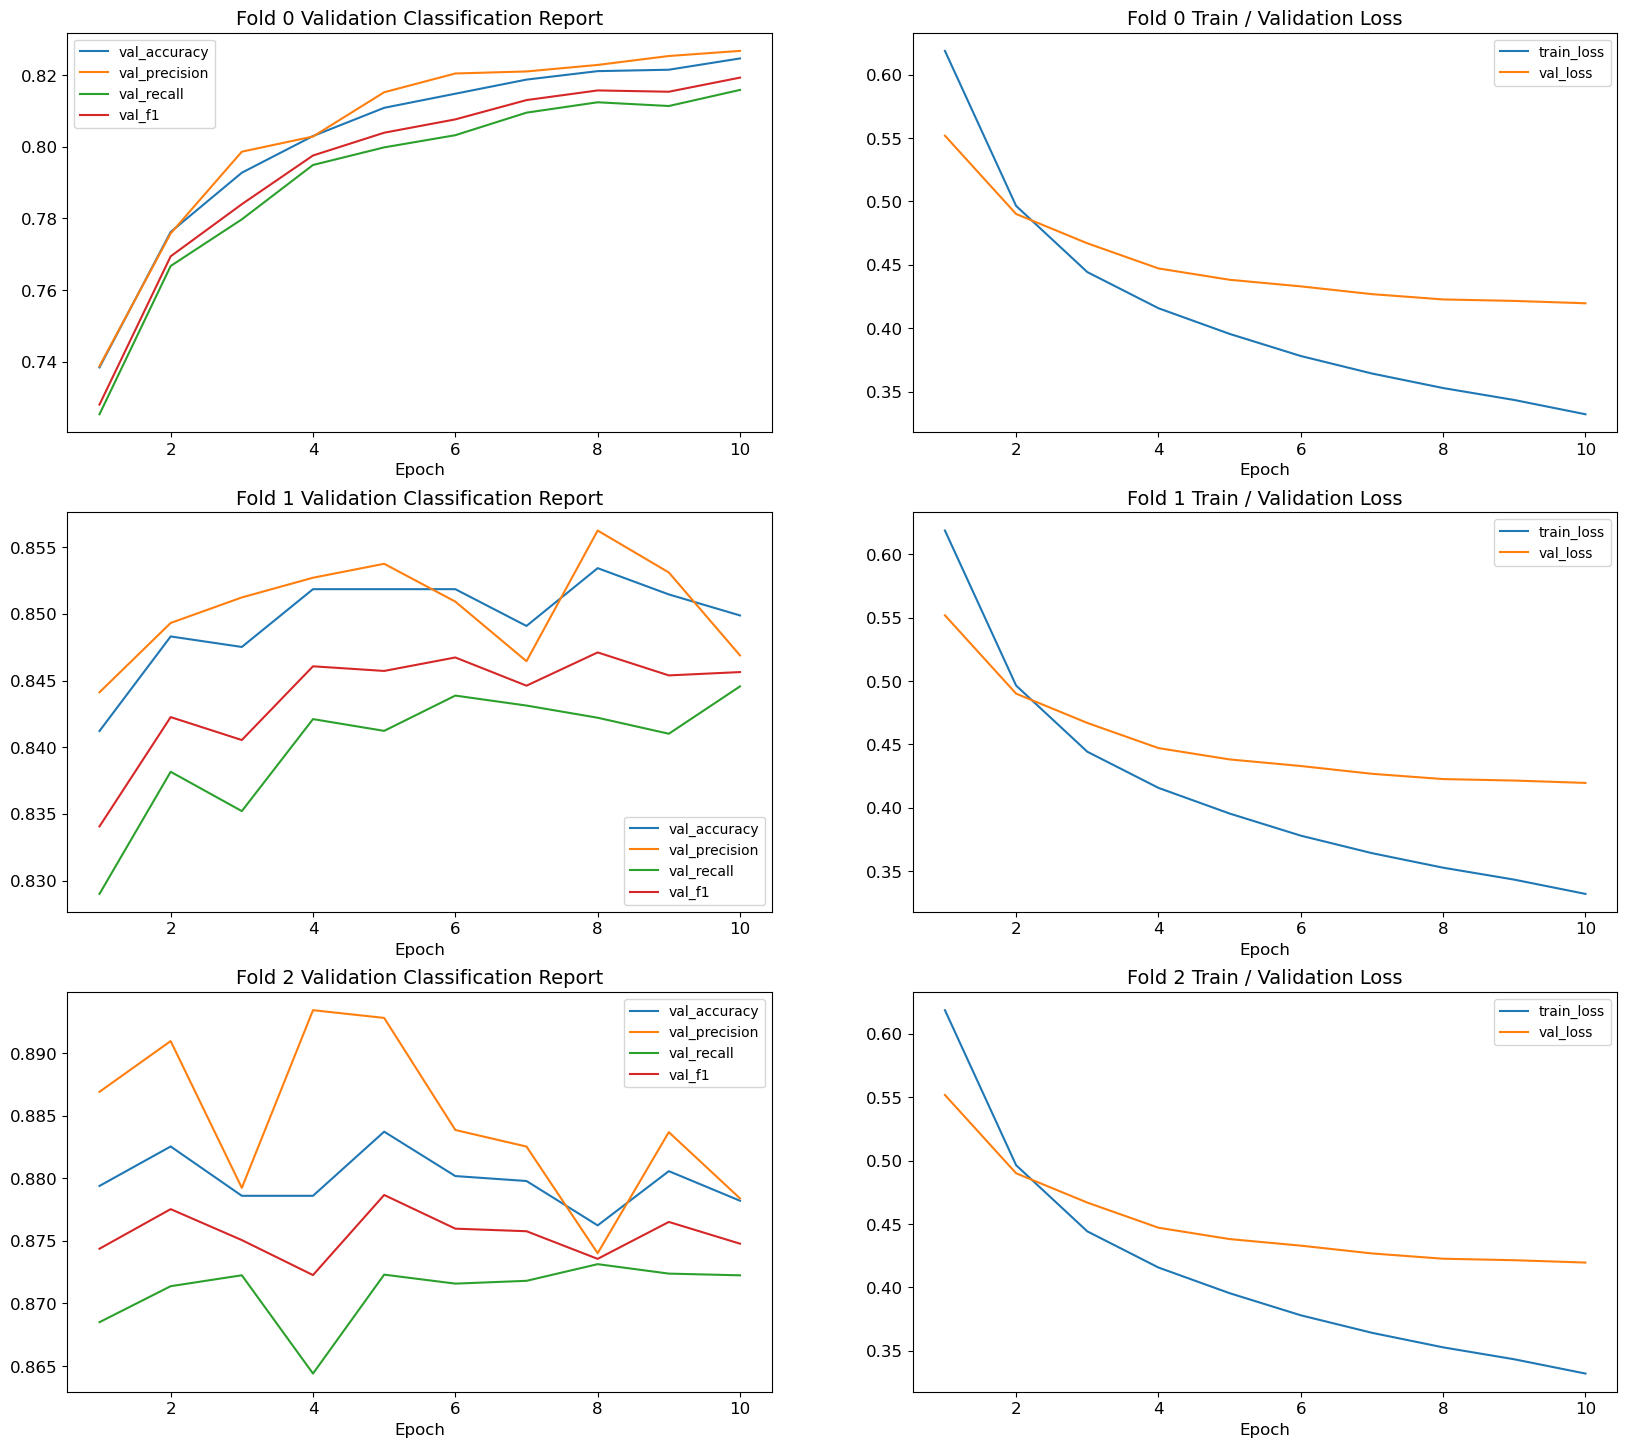

In [89]:
clf.plot_learning_curve()

In [90]:
y_pred = clf.predict(df_test_data)

model_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
model_submission['target'] = np.round(y_pred).astype('int')
model_submission.to_csv('submission.csv', index=False)
model_submission.describe()

,id,target
count,3263.00000000,3263.00000000
mean,5427.15292675,0.37174379
std,3146.42722150,0.48334454
min,0.00000000,0.00000000
25%,2683.00000000,0.00000000
50%,5500.00000000,0.00000000
75%,8176.00000000,1.00000000
max,10875.00000000,1.00000000
